# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 6.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.8 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.8 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [8]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [9]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [10]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [11]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 0.8), constraint=constraints.positive)

    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 0.8), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [12]:
# def to_device_and_dtype(tensor, device):
#     return tensor.to(device).float()

In [13]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    #chord = torch.zeros(npcs).float()
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord
    #return to_device_and_dtype(chord, device)

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs
    # obs["c"] = torch.tensor([c['label'] for c in chords]).long()
    # obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords]).long()
    # return {k: to_device_and_dtype(v, device) for k, v in obs.items()}

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [14]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [15]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [16]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [17]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # apply gradient clipping
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [18]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [19]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [20]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/200000 [00:00<?, ?it/s]<ipython-input-17-390aaa289ab3>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 3/200000 [00:00<2:26:34, 22.74it/s]

Step 0 : loss = 3727527.740960735


  0%|          | 107/200000 [00:03<1:15:50, 43.93it/s]

Step 100 : loss = 2071933.944737635


  0%|          | 209/200000 [00:05<1:03:38, 52.33it/s]

Step 200 : loss = 1978715.4471692573


  0%|          | 311/200000 [00:07<59:00, 56.40it/s]

Step 300 : loss = 1851439.7029843738


  0%|          | 407/200000 [00:09<59:47, 55.63it/s]  

Step 400 : loss = 1880672.5659554978


  0%|          | 508/200000 [00:11<1:19:18, 41.92it/s]

Step 500 : loss = 1825208.8112703902


  0%|          | 606/200000 [00:14<1:22:37, 40.22it/s]

Step 600 : loss = 1829049.2872990898


  0%|          | 709/200000 [00:16<1:17:58, 42.60it/s]

Step 700 : loss = 1835181.5407065782


  0%|          | 805/200000 [00:18<1:02:32, 53.08it/s]

Step 800 : loss = 1814995.5519945696


  0%|          | 907/200000 [00:20<59:07, 56.12it/s]

Step 900 : loss = 1810154.2771893363


  1%|          | 1010/200000 [00:22<57:26, 57.74it/s]

Step 1000 : loss = 1824022.8407580145


  1%|          | 1112/200000 [00:23<57:30, 57.64it/s]

Step 1100 : loss = 1800449.36022266


  1%|          | 1209/200000 [00:25<57:55, 57.20it/s]

Step 1200 : loss = 1805360.54711683


  1%|          | 1306/200000 [00:27<1:15:20, 43.95it/s]

Step 1300 : loss = 1814329.616216244


  1%|          | 1406/200000 [00:29<1:18:29, 42.17it/s]

Step 1400 : loss = 1807967.2637972115


  1%|          | 1508/200000 [00:32<1:12:57, 45.35it/s]

Step 1500 : loss = 1798709.6083362491


  1%|          | 1610/200000 [00:34<58:24, 56.60it/s]

Step 1600 : loss = 1814924.6943554427


  1%|          | 1709/200000 [00:35<58:13, 56.77it/s]

Step 1700 : loss = 1808274.9743758503


  1%|          | 1810/200000 [00:37<56:38, 58.32it/s]

Step 1800 : loss = 1806258.6510313363


  1%|          | 1910/200000 [00:39<59:46, 55.23it/s]

Step 1900 : loss = 1788171.1860715852


  1%|          | 2007/200000 [00:40<54:32, 60.50it/s]

Step 2000 : loss = 1804047.0789330842


  1%|          | 2107/200000 [00:42<1:12:59, 45.19it/s]

Step 2100 : loss = 1808981.313356268


  1%|          | 2207/200000 [00:45<1:16:22, 43.16it/s]

Step 2200 : loss = 1794867.0531319603


  1%|          | 2307/200000 [00:47<1:18:18, 42.08it/s]

Step 2300 : loss = 1804528.8198739265


  1%|          | 2411/200000 [00:49<56:44, 58.03it/s]

Step 2400 : loss = 1797031.0405444498


  1%|▏         | 2510/200000 [00:51<57:08, 57.60it/s]

Step 2500 : loss = 1795887.942225872


  1%|▏         | 2611/200000 [00:53<55:25, 59.35it/s]

Step 2600 : loss = 1795794.1312274612


  1%|▏         | 2708/200000 [00:54<56:30, 58.19it/s]

Step 2700 : loss = 1793351.51276785


  1%|▏         | 2811/200000 [00:56<55:25, 59.30it/s]

Step 2800 : loss = 1801939.7541897227


  1%|▏         | 2909/200000 [00:58<57:27, 57.17it/s]

Step 2900 : loss = 1800988.7770106832


  2%|▏         | 3006/200000 [01:00<1:15:57, 43.23it/s]

Step 3000 : loss = 1792045.0900567449


  2%|▏         | 3106/200000 [01:02<1:16:31, 42.88it/s]

Step 3100 : loss = 1805006.7814325436


  2%|▏         | 3213/200000 [01:04<56:00, 58.56it/s]

Step 3200 : loss = 1795641.4943809991


  2%|▏         | 3310/200000 [01:06<55:28, 59.09it/s]

Step 3300 : loss = 1781107.8435126853


  2%|▏         | 3413/200000 [01:08<54:32, 60.07it/s]

Step 3400 : loss = 1803108.8156361831


  2%|▏         | 3508/200000 [01:09<55:38, 58.85it/s]

Step 3500 : loss = 1793658.3604314355


  2%|▏         | 3612/200000 [01:11<54:58, 59.55it/s]

Step 3600 : loss = 1794945.9535551574


  2%|▏         | 3708/200000 [01:13<1:11:49, 45.55it/s]

Step 3700 : loss = 1806034.5338914227


  2%|▏         | 3807/200000 [01:15<1:21:45, 40.00it/s]

Step 3800 : loss = 1802491.1143753948


  2%|▏         | 3907/200000 [01:18<1:13:41, 44.35it/s]

Step 3900 : loss = 1793304.5233833073


  2%|▏         | 4008/200000 [01:20<58:33, 55.78it/s]  

Step 4000 : loss = 1795152.7236506727


  2%|▏         | 4108/200000 [01:22<57:41, 56.59it/s]

Step 4100 : loss = 1801904.8005473749


  2%|▏         | 4212/200000 [01:23<55:32, 58.76it/s]

Step 4200 : loss = 1806597.174281395


  2%|▏         | 4310/200000 [01:25<56:30, 57.71it/s]

Step 4300 : loss = 1807195.4563355579


  2%|▏         | 4413/200000 [01:27<54:07, 60.23it/s]

Step 4400 : loss = 1801620.4404995844


  2%|▏         | 4512/200000 [01:28<55:29, 58.71it/s]

Step 4500 : loss = 1789895.3077512553


  2%|▏         | 4608/200000 [01:30<1:14:32, 43.69it/s]

Step 4600 : loss = 1785428.3632212428


  2%|▏         | 4708/200000 [01:33<1:14:51, 43.48it/s]

Step 4700 : loss = 1784665.8433977743


  2%|▏         | 4808/200000 [01:35<1:22:11, 39.58it/s]

Step 4800 : loss = 1804434.5311764563


  2%|▏         | 4913/200000 [01:37<53:05, 61.25it/s]

Step 4900 : loss = 1789345.5305290595


  3%|▎         | 5011/200000 [01:38<54:36, 59.51it/s]

Step 5000 : loss = 1796071.588668215


  3%|▎         | 5110/200000 [01:40<54:05, 60.06it/s]

Step 5100 : loss = 1786429.286474463


  3%|▎         | 5207/200000 [01:42<54:58, 59.06it/s]

Step 5200 : loss = 1791377.3166273355


  3%|▎         | 5307/200000 [01:44<56:27, 57.48it/s]

Step 5300 : loss = 1805320.3680763403


  3%|▎         | 5406/200000 [01:45<59:44, 54.29it/s]

Step 5400 : loss = 1803714.331570997


  3%|▎         | 5508/200000 [01:48<1:17:37, 41.76it/s]

Step 5500 : loss = 1789077.8198725418


  3%|▎         | 5608/200000 [01:50<1:14:59, 43.20it/s]

Step 5600 : loss = 1794136.3772708578


  3%|▎         | 5710/200000 [01:52<57:16, 56.54it/s]

Step 5700 : loss = 1801271.683154463


  3%|▎         | 5812/200000 [01:54<55:00, 58.84it/s]

Step 5800 : loss = 1796646.5278172991


  3%|▎         | 5912/200000 [01:56<56:19, 57.43it/s]

Step 5900 : loss = 1794875.875149154


  3%|▎         | 6009/200000 [01:57<55:46, 57.97it/s]

Step 6000 : loss = 1789129.0861777423


  3%|▎         | 6107/200000 [01:59<55:42, 58.01it/s]

Step 6100 : loss = 1792201.2476540685


  3%|▎         | 6212/200000 [02:01<55:32, 58.15it/s]

Step 6200 : loss = 1786121.6009389856


  3%|▎         | 6309/200000 [02:03<1:15:02, 43.02it/s]

Step 6300 : loss = 1798558.2383334616


  3%|▎         | 6409/200000 [02:05<1:15:49, 42.55it/s]

Step 6400 : loss = 1801343.395936867


  3%|▎         | 6512/200000 [02:07<56:56, 56.63it/s]

Step 6500 : loss = 1803263.167181733


  3%|▎         | 6611/200000 [02:09<55:49, 57.73it/s]

Step 6600 : loss = 1791121.9924318008


  3%|▎         | 6707/200000 [02:11<54:18, 59.33it/s]

Step 6700 : loss = 1792647.4118065436


  3%|▎         | 6811/200000 [02:13<55:20, 58.19it/s]

Step 6800 : loss = 1789998.5170163573


  3%|▎         | 6909/200000 [02:14<56:57, 56.49it/s]

Step 6900 : loss = 1796266.2663841737


  4%|▎         | 7009/200000 [02:16<59:06, 54.42it/s]

Step 7000 : loss = 1802120.5536557166


  4%|▎         | 7106/200000 [02:18<1:14:27, 43.17it/s]

Step 7100 : loss = 1786482.2602025494


  4%|▎         | 7206/200000 [02:20<1:18:23, 40.99it/s]

Step 7200 : loss = 1793990.6717423613


  4%|▎         | 7306/200000 [02:23<1:16:18, 42.08it/s]

Step 7300 : loss = 1787780.4324288967


  4%|▎         | 7407/200000 [02:24<55:52, 57.45it/s]

Step 7400 : loss = 1792470.6843630585


  4%|▍         | 7512/200000 [02:26<53:48, 59.61it/s]

Step 7500 : loss = 1794584.6886186576


  4%|▍         | 7610/200000 [02:28<54:17, 59.05it/s]

Step 7600 : loss = 1797493.6812527787


  4%|▍         | 7711/200000 [02:30<52:15, 61.32it/s]

Step 7700 : loss = 1784491.3523600805


  4%|▍         | 7807/200000 [02:31<54:56, 58.31it/s]

Step 7800 : loss = 1801395.4678232656


  4%|▍         | 7909/200000 [02:33<1:06:42, 47.99it/s]

Step 7900 : loss = 1800155.9978500223


  4%|▍         | 8009/200000 [02:35<1:16:27, 41.85it/s]

Step 8000 : loss = 1794373.5490455474


  4%|▍         | 8109/200000 [02:38<1:15:57, 42.10it/s]

Step 8100 : loss = 1797493.5457728668


  4%|▍         | 8212/200000 [02:40<54:23, 58.78it/s]

Step 8200 : loss = 1796623.1930454618


  4%|▍         | 8311/200000 [02:41<53:07, 60.13it/s]

Step 8300 : loss = 1785070.6637500997


  4%|▍         | 8411/200000 [02:43<53:33, 59.62it/s]

Step 8400 : loss = 1797244.6645000721


  4%|▍         | 8510/200000 [02:45<58:30, 54.54it/s]

Step 8500 : loss = 1795166.7739763216


  4%|▍         | 8610/200000 [02:47<53:30, 59.62it/s]

Step 8600 : loss = 1795316.6802820517


  4%|▍         | 8712/200000 [02:48<53:00, 60.15it/s]

Step 8700 : loss = 1795168.4793231548


  4%|▍         | 8807/200000 [02:51<1:11:31, 44.56it/s]

Step 8800 : loss = 1778720.4869564814


  4%|▍         | 8907/200000 [02:53<1:15:05, 42.41it/s]

Step 8900 : loss = 1805020.4068446048


  5%|▍         | 9009/200000 [02:55<57:49, 55.04it/s]  

Step 9000 : loss = 1789725.1538277066


  5%|▍         | 9109/200000 [02:57<53:53, 59.04it/s]

Step 9100 : loss = 1806722.4899010786


  5%|▍         | 9208/200000 [02:58<55:24, 57.39it/s]

Step 9200 : loss = 1789103.203404798


  5%|▍         | 9312/200000 [03:00<55:19, 57.45it/s]

Step 9300 : loss = 1796146.7158319012


  5%|▍         | 9411/200000 [03:02<56:06, 56.61it/s]

Step 9400 : loss = 1795648.6148509518


  5%|▍         | 9508/200000 [03:04<56:06, 56.58it/s]

Step 9500 : loss = 1790080.2273727455


  5%|▍         | 9609/200000 [03:06<1:10:17, 45.14it/s]

Step 9600 : loss = 1790741.751208743


  5%|▍         | 9704/200000 [03:08<1:17:20, 41.01it/s]

Step 9700 : loss = 1787162.7018419418


  5%|▍         | 9808/200000 [03:10<1:10:51, 44.74it/s]

Step 9800 : loss = 1810430.6434459954


  5%|▍         | 9907/200000 [03:12<54:24, 58.24it/s]

Step 9900 : loss = 1795393.6491877371


  5%|▌         | 10013/200000 [03:14<53:26, 59.25it/s]

Step 10000 : loss = 1791909.1077469857


  5%|▌         | 10107/200000 [03:16<51:54, 60.97it/s]

Step 10100 : loss = 1785327.3084497955


  5%|▌         | 10210/200000 [03:17<53:28, 59.15it/s]

Step 10200 : loss = 1800820.455648162


  5%|▌         | 10313/200000 [03:19<52:49, 59.84it/s]

Step 10300 : loss = 1787035.4604043756


  5%|▌         | 10404/200000 [03:21<1:03:09, 50.03it/s]

Step 10400 : loss = 1784092.4677889373


  5%|▌         | 10505/200000 [03:23<1:16:22, 41.35it/s]

Step 10500 : loss = 1793711.4872773835


  5%|▌         | 10605/200000 [03:25<1:15:52, 41.60it/s]

Step 10600 : loss = 1797914.6288507737


  5%|▌         | 10706/200000 [03:27<55:23, 56.96it/s]

Step 10700 : loss = 1796761.2402203875


  5%|▌         | 10807/200000 [03:29<52:23, 60.19it/s]

Step 10800 : loss = 1789371.4267592924


  5%|▌         | 10907/200000 [03:31<53:32, 58.86it/s]

Step 10900 : loss = 1792697.967551332


  6%|▌         | 11009/200000 [03:33<55:37, 56.63it/s]

Step 11000 : loss = 1797109.3652906322


  6%|▌         | 11108/200000 [03:34<51:46, 60.80it/s]

Step 11100 : loss = 1789110.251985873


  6%|▌         | 11207/200000 [03:36<55:49, 56.37it/s]

Step 11200 : loss = 1793196.8296741769


  6%|▌         | 11308/200000 [03:38<1:11:40, 43.87it/s]

Step 11300 : loss = 1785847.5216572364


  6%|▌         | 11408/200000 [03:41<1:10:59, 44.27it/s]

Step 11400 : loss = 1790751.6153778532


  6%|▌         | 11510/200000 [03:43<55:13, 56.89it/s]

Step 11500 : loss = 1780598.9916684171


  6%|▌         | 11610/200000 [03:44<53:08, 59.08it/s]

Step 11600 : loss = 1788726.9708617115


  6%|▌         | 11712/200000 [03:46<53:33, 58.60it/s]

Step 11700 : loss = 1786937.272222402


  6%|▌         | 11811/200000 [03:48<54:34, 57.48it/s]

Step 11800 : loss = 1794665.6140523423


  6%|▌         | 11910/200000 [03:49<53:08, 59.00it/s]

Step 11900 : loss = 1799398.3228469682


  6%|▌         | 12012/200000 [03:51<54:33, 57.42it/s]

Step 12000 : loss = 1793441.5502937739


  6%|▌         | 12108/200000 [03:53<1:12:24, 43.25it/s]

Step 12100 : loss = 1792460.5734087282


  6%|▌         | 12208/200000 [03:56<1:10:28, 44.41it/s]

Step 12200 : loss = 1795455.775190721


  6%|▌         | 12308/200000 [03:58<1:17:55, 40.15it/s]

Step 12300 : loss = 1801264.7936115158


  6%|▌         | 12407/200000 [04:00<51:53, 60.25it/s]

Step 12400 : loss = 1790127.9430902048


  6%|▋         | 12510/200000 [04:01<53:43, 58.16it/s]

Step 12500 : loss = 1797151.712892253


  6%|▋         | 12608/200000 [04:03<59:31, 52.46it/s]

Step 12600 : loss = 1794506.5627089243


  6%|▋         | 12712/200000 [04:05<54:09, 57.64it/s]

Step 12700 : loss = 1793655.8069595154


  6%|▋         | 12811/200000 [04:07<55:27, 56.26it/s]

Step 12800 : loss = 1791903.4566647108


  6%|▋         | 12908/200000 [04:09<1:09:46, 44.69it/s]

Step 12900 : loss = 1785623.918325344


  7%|▋         | 13008/200000 [04:11<1:14:22, 41.91it/s]

Step 13000 : loss = 1791363.9604750075


  7%|▋         | 13107/200000 [04:14<1:19:16, 39.29it/s]

Step 13100 : loss = 1789337.9781841645


  7%|▋         | 13212/200000 [04:15<54:26, 57.19it/s]

Step 13200 : loss = 1795731.287447451


  7%|▋         | 13311/200000 [04:17<54:30, 57.09it/s]

Step 13300 : loss = 1790257.644040024


  7%|▋         | 13409/200000 [04:19<55:02, 56.50it/s]

Step 13400 : loss = 1801034.5152313248


  7%|▋         | 13509/200000 [04:21<54:08, 57.42it/s]

Step 13500 : loss = 1793516.5379786056


  7%|▋         | 13609/200000 [04:22<52:10, 59.54it/s]

Step 13600 : loss = 1791762.7068415857


  7%|▋         | 13708/200000 [04:24<1:03:39, 48.77it/s]

Step 13700 : loss = 1796748.9854327952


  7%|▋         | 13809/200000 [04:27<1:13:09, 42.42it/s]

Step 13800 : loss = 1796709.7785956091


  7%|▋         | 13904/200000 [04:29<1:15:42, 40.97it/s]

Step 13900 : loss = 1785737.7354941308


  7%|▋         | 14011/200000 [04:31<57:05, 54.30it/s]

Step 14000 : loss = 1788169.2462646617


  7%|▋         | 14107/200000 [04:33<57:22, 54.00it/s]

Step 14100 : loss = 1797868.381043512


  7%|▋         | 14209/200000 [04:35<54:31, 56.80it/s]

Step 14200 : loss = 1789738.3552805672


  7%|▋         | 14312/200000 [04:36<56:00, 55.26it/s]

Step 14300 : loss = 1793183.739683257


  7%|▋         | 14410/200000 [04:38<55:04, 56.16it/s]

Step 14400 : loss = 1789652.9716031293


  7%|▋         | 14506/200000 [04:40<1:05:52, 46.93it/s]

Step 14500 : loss = 1794103.6987515579


  7%|▋         | 14606/200000 [04:42<1:14:35, 41.42it/s]

Step 14600 : loss = 1785922.0893739446


  7%|▋         | 14706/200000 [04:45<1:10:49, 43.61it/s]

Step 14700 : loss = 1789318.4901492822


  7%|▋         | 14807/200000 [04:47<57:20, 53.83it/s]

Step 14800 : loss = 1795736.504448394


  7%|▋         | 14909/200000 [04:49<54:22, 56.73it/s]

Step 14900 : loss = 1789813.1215462165


  8%|▊         | 15013/200000 [04:51<52:02, 59.25it/s]

Step 15000 : loss = 1791441.270296663


  8%|▊         | 15110/200000 [04:52<55:05, 55.94it/s]

Step 15100 : loss = 1783020.1167120968


  8%|▊         | 15208/200000 [04:54<54:39, 56.35it/s]

Step 15200 : loss = 1789972.1413974063


  8%|▊         | 15310/200000 [04:56<53:27, 57.58it/s]

Step 15300 : loss = 1786937.6723154453


  8%|▊         | 15407/200000 [04:58<1:13:26, 41.89it/s]

Step 15400 : loss = 1793436.3580420762


  8%|▊         | 15507/200000 [05:00<1:11:05, 43.26it/s]

Step 15500 : loss = 1798388.4065992609


  8%|▊         | 15612/200000 [05:03<54:24, 56.49it/s]

Step 15600 : loss = 1785449.1086064773


  8%|▊         | 15710/200000 [05:04<52:23, 58.63it/s]

Step 15700 : loss = 1793060.2669578395


  8%|▊         | 15808/200000 [05:07<1:33:05, 32.98it/s]

Step 15800 : loss = 1795081.2286956687


  8%|▊         | 15912/200000 [05:09<53:02, 57.85it/s]

Step 15900 : loss = 1789925.4898297759


  8%|▊         | 16010/200000 [05:10<57:58, 52.89it/s]

Step 16000 : loss = 1805145.0027080101


  8%|▊         | 16109/200000 [05:12<1:11:00, 43.16it/s]

Step 16100 : loss = 1788818.024464292


  8%|▊         | 16209/200000 [05:15<1:10:28, 43.47it/s]

Step 16200 : loss = 1789854.3677015149


  8%|▊         | 16304/200000 [05:17<1:12:52, 42.02it/s]

Step 16300 : loss = 1796221.5533138148


  8%|▊         | 16410/200000 [05:19<52:13, 58.59it/s]

Step 16400 : loss = 1799560.780700204


  8%|▊         | 16510/200000 [05:21<52:31, 58.23it/s]

Step 16500 : loss = 1791509.9733175384


  8%|▊         | 16610/200000 [05:22<52:59, 57.67it/s]

Step 16600 : loss = 1810997.1797261043


  8%|▊         | 16711/200000 [05:24<53:01, 57.61it/s]

Step 16700 : loss = 1798809.7069084437


  8%|▊         | 16809/200000 [05:26<52:48, 57.81it/s]

Step 16800 : loss = 1781632.7214216045


  8%|▊         | 16910/200000 [05:28<54:03, 56.44it/s]

Step 16900 : loss = 1801410.65224067


  9%|▊         | 17007/200000 [05:30<1:09:44, 43.73it/s]

Step 17000 : loss = 1803218.4604977844


  9%|▊         | 17107/200000 [05:32<1:11:56, 42.37it/s]

Step 17100 : loss = 1790617.8889736193


  9%|▊         | 17209/200000 [05:34<54:02, 56.37it/s]

Step 17200 : loss = 1783070.09046268


  9%|▊         | 17312/200000 [05:36<55:05, 55.27it/s]

Step 17300 : loss = 1793836.41962856


  9%|▊         | 17407/200000 [05:38<52:30, 57.96it/s]

Step 17400 : loss = 1798413.641294018


  9%|▉         | 17511/200000 [05:40<52:37, 57.79it/s]

Step 17500 : loss = 1790879.3934878614


  9%|▉         | 17609/200000 [05:41<52:46, 57.60it/s]

Step 17600 : loss = 1790545.265733398


  9%|▉         | 17712/200000 [05:43<51:08, 59.41it/s]

Step 17700 : loss = 1790587.8865985465


  9%|▉         | 17808/200000 [05:45<1:18:59, 38.44it/s]

Step 17800 : loss = 1788508.9498265071


  9%|▉         | 17907/200000 [05:48<1:15:11, 40.36it/s]

Step 17900 : loss = 1796328.8291671416


  9%|▉         | 18012/200000 [05:50<57:22, 52.87it/s]

Step 18000 : loss = 1789028.0927131297


  9%|▉         | 18109/200000 [05:52<50:59, 59.45it/s]

Step 18100 : loss = 1789013.8681474563


  9%|▉         | 18210/200000 [05:53<52:37, 57.57it/s]

Step 18200 : loss = 1783627.890297608


  9%|▉         | 18312/200000 [05:55<51:45, 58.51it/s]

Step 18300 : loss = 1784653.4000794005


  9%|▉         | 18411/200000 [05:57<51:04, 59.26it/s]

Step 18400 : loss = 1780097.6517397652


  9%|▉         | 18510/200000 [05:58<50:49, 59.51it/s]

Step 18500 : loss = 1786018.6178220897


  9%|▉         | 18608/200000 [06:00<1:07:44, 44.63it/s]

Step 18600 : loss = 1791612.522645336


  9%|▉         | 18708/200000 [06:03<1:13:58, 40.85it/s]

Step 18700 : loss = 1797319.3991460728


  9%|▉         | 18808/200000 [06:05<1:12:15, 41.80it/s]

Step 18800 : loss = 1792601.4807109418


  9%|▉         | 18912/200000 [06:07<52:10, 57.85it/s]

Step 18900 : loss = 1793883.5060855066


 10%|▉         | 19010/200000 [06:09<54:33, 55.29it/s]

Step 19000 : loss = 1793686.6071194056


 10%|▉         | 19108/200000 [06:11<55:40, 54.15it/s]

Step 19100 : loss = 1803682.5345175387


 10%|▉         | 19207/200000 [06:12<51:06, 58.96it/s]

Step 19200 : loss = 1806280.0135928683


 10%|▉         | 19311/200000 [06:14<51:57, 57.96it/s]

Step 19300 : loss = 1791236.0741928136


 10%|▉         | 19409/200000 [06:16<1:06:11, 45.47it/s]

Step 19400 : loss = 1780249.4346227492


 10%|▉         | 19509/200000 [06:18<1:13:08, 41.13it/s]

Step 19500 : loss = 1792657.137168348


 10%|▉         | 19608/200000 [06:21<1:12:00, 41.75it/s]

Step 19600 : loss = 1791959.0480711749


 10%|▉         | 19712/200000 [06:23<52:30, 57.23it/s]

Step 19700 : loss = 1796275.7390574268


 10%|▉         | 19810/200000 [06:24<53:39, 55.97it/s]

Step 19800 : loss = 1803707.9236077932


 10%|▉         | 19911/200000 [06:26<53:07, 56.49it/s]

Step 19900 : loss = 1792409.5175715673


 10%|█         | 20012/200000 [06:28<50:38, 59.24it/s]

Step 20000 : loss = 1800371.2687797244


 10%|█         | 20113/200000 [06:30<50:12, 59.71it/s]

Step 20100 : loss = 1782412.6875814137


 10%|█         | 20207/200000 [06:31<56:53, 52.67it/s]

Step 20200 : loss = 1787962.748262902


 10%|█         | 20309/200000 [06:34<1:09:27, 43.11it/s]

Step 20300 : loss = 1802566.2624108223


 10%|█         | 20409/200000 [06:36<1:10:49, 42.26it/s]

Step 20400 : loss = 1793919.791711591


 10%|█         | 20512/200000 [06:38<53:19, 56.09it/s]

Step 20500 : loss = 1791641.2403532164


 10%|█         | 20610/200000 [06:40<52:36, 56.83it/s]

Step 20600 : loss = 1786256.087766435


 10%|█         | 20710/200000 [06:42<51:21, 58.18it/s]

Step 20700 : loss = 1802348.555014663


 10%|█         | 20812/200000 [06:43<50:42, 58.89it/s]

Step 20800 : loss = 1788825.7103987425


 10%|█         | 20909/200000 [06:45<49:26, 60.37it/s]

Step 20900 : loss = 1799886.3090295726


 11%|█         | 21009/200000 [06:47<49:26, 60.35it/s]

Step 21000 : loss = 1794120.3191624735


 11%|█         | 21108/200000 [06:49<1:06:09, 45.06it/s]

Step 21100 : loss = 1798200.9295772323


 11%|█         | 21208/200000 [06:51<1:07:57, 43.85it/s]

Step 21200 : loss = 1792775.076418538


 11%|█         | 21310/200000 [06:54<1:02:27, 47.68it/s]

Step 21300 : loss = 1794659.9369912716


 11%|█         | 21410/200000 [06:55<52:04, 57.16it/s]

Step 21400 : loss = 1800408.7889018892


 11%|█         | 21510/200000 [06:57<51:40, 57.57it/s]

Step 21500 : loss = 1788455.7285872349


 11%|█         | 21609/200000 [06:59<50:52, 58.44it/s]

Step 21600 : loss = 1796640.6410274298


 11%|█         | 21708/200000 [07:00<50:20, 59.03it/s]

Step 21700 : loss = 1800976.8846841722


 11%|█         | 21808/200000 [07:02<54:22, 54.62it/s]

Step 21800 : loss = 1792665.5688230786


 11%|█         | 21906/200000 [07:04<1:08:26, 43.37it/s]

Step 21900 : loss = 1796230.0261417641


 11%|█         | 22006/200000 [07:06<1:13:56, 40.12it/s]

Step 22000 : loss = 1783041.0491645928


 11%|█         | 22106/200000 [07:09<1:10:22, 42.13it/s]

Step 22100 : loss = 1781337.8133366136


 11%|█         | 22210/200000 [07:11<49:42, 59.61it/s]

Step 22200 : loss = 1797377.8907398211


 11%|█         | 22308/200000 [07:12<52:23, 56.53it/s]

Step 22300 : loss = 1786616.5052955286


 11%|█         | 22412/200000 [07:14<50:32, 58.55it/s]

Step 22400 : loss = 1793585.5889073806


 11%|█▏        | 22510/200000 [07:16<51:49, 57.08it/s]

Step 22500 : loss = 1793048.413667344


 11%|█▏        | 22606/200000 [07:18<51:26, 57.48it/s]

Step 22600 : loss = 1812552.3888792177


 11%|█▏        | 22705/200000 [07:19<52:37, 56.14it/s]

Step 22700 : loss = 1794159.3916091463


 11%|█▏        | 22807/200000 [07:22<1:09:56, 42.22it/s]

Step 22800 : loss = 1794243.0874841805


 11%|█▏        | 22907/200000 [07:24<1:11:20, 41.37it/s]

Step 22900 : loss = 1796589.5968257505


 12%|█▏        | 23013/200000 [07:26<49:59, 59.01it/s]

Step 23000 : loss = 1797790.0735950416


 12%|█▏        | 23111/200000 [07:28<52:30, 56.15it/s]

Step 23100 : loss = 1790816.7152736166


 12%|█▏        | 23210/200000 [07:30<50:06, 58.80it/s]

Step 23200 : loss = 1794194.5503323702


 12%|█▏        | 23309/200000 [07:31<50:41, 58.10it/s]

Step 23300 : loss = 1795559.2452318557


 12%|█▏        | 23409/200000 [07:33<51:12, 57.47it/s]

Step 23400 : loss = 1799376.5455506672


 12%|█▏        | 23507/200000 [07:35<51:30, 57.11it/s]

Step 23500 : loss = 1784451.1615519724


 12%|█▏        | 23609/200000 [07:37<1:06:08, 44.45it/s]

Step 23600 : loss = 1802265.835854186


 12%|█▏        | 23709/200000 [07:39<1:05:30, 44.86it/s]

Step 23700 : loss = 1790584.529895028


 12%|█▏        | 23811/200000 [07:42<59:23, 49.44it/s]  

Step 23800 : loss = 1797397.3540082022


 12%|█▏        | 23911/200000 [07:43<51:17, 57.23it/s]

Step 23900 : loss = 1799189.360639854


 12%|█▏        | 24012/200000 [07:45<50:20, 58.27it/s]

Step 24000 : loss = 1793178.4951874


 12%|█▏        | 24110/200000 [07:47<48:31, 60.41it/s]

Step 24100 : loss = 1789687.7704572112


 12%|█▏        | 24207/200000 [07:48<52:29, 55.82it/s]

Step 24200 : loss = 1798901.6586501002


 12%|█▏        | 24308/200000 [07:50<50:40, 57.78it/s]

Step 24300 : loss = 1805096.513545418


 12%|█▏        | 24409/200000 [07:52<1:06:38, 43.92it/s]

Step 24400 : loss = 1801768.3862956031


 12%|█▏        | 24508/200000 [07:54<1:16:01, 38.47it/s]

Step 24500 : loss = 1789838.7866766658


 12%|█▏        | 24608/200000 [07:57<1:05:33, 44.59it/s]

Step 24600 : loss = 1798025.5278441794


 12%|█▏        | 24710/200000 [07:59<51:01, 57.25it/s]

Step 24700 : loss = 1783502.4901603747


 12%|█▏        | 24811/200000 [08:00<48:12, 60.57it/s]

Step 24800 : loss = 1790015.716948627


 12%|█▏        | 24907/200000 [08:02<51:33, 56.60it/s]

Step 24900 : loss = 1792714.5332924938


 13%|█▎        | 25008/200000 [08:04<51:18, 56.85it/s]

Step 25000 : loss = 1794253.7063661749


 13%|█▎        | 25111/200000 [08:05<47:44, 61.05it/s]

Step 25100 : loss = 1794396.1738315932


 13%|█▎        | 25210/200000 [08:07<49:29, 58.86it/s]

Step 25200 : loss = 1795053.9490118031


 13%|█▎        | 25309/200000 [08:09<1:07:20, 43.24it/s]

Step 25300 : loss = 1786076.355649585


 13%|█▎        | 25409/200000 [08:12<1:06:32, 43.72it/s]

Step 25400 : loss = 1789768.666108748


 13%|█▎        | 25511/200000 [08:14<53:02, 54.83it/s]

Step 25500 : loss = 1794453.3880282328


 13%|█▎        | 25612/200000 [08:16<49:19, 58.92it/s]

Step 25600 : loss = 1788334.314773424


 13%|█▎        | 25707/200000 [08:17<51:05, 56.85it/s]

Step 25700 : loss = 1786611.17529028


 13%|█▎        | 25808/200000 [08:19<48:20, 60.06it/s]

Step 25800 : loss = 1795264.8904014132


 13%|█▎        | 25910/200000 [08:21<48:29, 59.84it/s]

Step 25900 : loss = 1777123.9446387996


 13%|█▎        | 26007/200000 [08:22<49:54, 58.11it/s]

Step 26000 : loss = 1791749.6850905155


 13%|█▎        | 26106/200000 [08:24<1:05:24, 44.31it/s]

Step 26100 : loss = 1785097.9237341848


 13%|█▎        | 26206/200000 [08:27<1:04:01, 45.24it/s]

Step 26200 : loss = 1790499.04454525


 13%|█▎        | 26306/200000 [08:29<1:09:37, 41.58it/s]

Step 26300 : loss = 1788512.864539952


 13%|█▎        | 26411/200000 [08:31<50:51, 56.88it/s]

Step 26400 : loss = 1789752.4659904032


 13%|█▎        | 26507/200000 [08:33<49:11, 58.78it/s]

Step 26500 : loss = 1792882.6262539644


 13%|█▎        | 26612/200000 [08:34<48:34, 59.49it/s]

Step 26600 : loss = 1796567.433131977


 13%|█▎        | 26710/200000 [08:36<47:29, 60.81it/s]

Step 26700 : loss = 1789532.3483316458


 13%|█▎        | 26807/200000 [08:38<51:12, 56.36it/s]

Step 26800 : loss = 1793473.5786925496


 13%|█▎        | 26910/200000 [08:39<49:33, 58.20it/s]

Step 26900 : loss = 1796762.1163585824


 14%|█▎        | 27008/200000 [08:42<1:06:33, 43.31it/s]

Step 27000 : loss = 1793550.1025789268


 14%|█▎        | 27108/200000 [08:44<1:08:34, 42.02it/s]

Step 27100 : loss = 1794347.6648848522


 14%|█▎        | 27210/200000 [08:46<50:59, 56.48it/s]

Step 27200 : loss = 1797603.6876616473


 14%|█▎        | 27310/200000 [08:48<51:05, 56.33it/s]

Step 27300 : loss = 1778078.5866914876


 14%|█▎        | 27407/200000 [08:50<47:05, 61.08it/s]

Step 27400 : loss = 1798801.081344619


 14%|█▍        | 27508/200000 [08:51<48:41, 59.04it/s]

Step 27500 : loss = 1804127.171710699


 14%|█▍        | 27607/200000 [08:53<48:32, 59.19it/s]

Step 27600 : loss = 1789736.518175139


 14%|█▍        | 27711/200000 [08:55<47:16, 60.73it/s]

Step 27700 : loss = 1795915.389818167


 14%|█▍        | 27807/200000 [08:57<1:03:51, 44.94it/s]

Step 27800 : loss = 1795541.7590501164


 14%|█▍        | 27907/200000 [08:59<1:08:11, 42.06it/s]

Step 27900 : loss = 1798674.0340945404


 14%|█▍        | 28007/200000 [09:01<1:05:27, 43.79it/s]

Step 28000 : loss = 1792661.2764219139


 14%|█▍        | 28108/200000 [09:03<47:48, 59.93it/s]

Step 28100 : loss = 1789780.8134720079


 14%|█▍        | 28210/200000 [09:05<49:48, 57.48it/s]

Step 28200 : loss = 1790209.141588377


 14%|█▍        | 28309/200000 [09:07<50:23, 56.78it/s]

Step 28300 : loss = 1789917.5897976104


 14%|█▍        | 28412/200000 [09:08<51:05, 55.97it/s]

Step 28400 : loss = 1786887.0241327044


 14%|█▍        | 28510/200000 [09:10<50:57, 56.09it/s]

Step 28500 : loss = 1786731.3454613364


 14%|█▍        | 28606/200000 [09:12<1:04:25, 44.33it/s]

Step 28600 : loss = 1793013.342350964


 14%|█▍        | 28706/200000 [09:15<1:14:42, 38.21it/s]

Step 28700 : loss = 1798266.733231477


 14%|█▍        | 28804/200000 [09:17<1:09:42, 40.93it/s]

Step 28800 : loss = 1792038.6350326205


 14%|█▍        | 28909/200000 [09:19<49:41, 57.38it/s]

Step 28900 : loss = 1795179.3346609464


 15%|█▍        | 29008/200000 [09:21<47:31, 59.97it/s]

Step 29000 : loss = 1793318.7777551026


 15%|█▍        | 29108/200000 [09:23<49:05, 58.01it/s]

Step 29100 : loss = 1796604.1854293612


 15%|█▍        | 29207/200000 [09:24<51:32, 55.22it/s]

Step 29200 : loss = 1792286.9028319488


 15%|█▍        | 29307/200000 [09:26<48:23, 58.78it/s]

Step 29300 : loss = 1796476.41196749


 15%|█▍        | 29410/200000 [09:28<53:22, 53.28it/s]

Step 29400 : loss = 1790575.198299299


 15%|█▍        | 29505/200000 [09:31<1:13:06, 38.87it/s]

Step 29500 : loss = 1801956.7558603245


 15%|█▍        | 29608/200000 [09:33<1:14:22, 38.18it/s]

Step 29600 : loss = 1796586.8970196988


 15%|█▍        | 29710/200000 [09:36<53:03, 53.49it/s]

Step 29700 : loss = 1803961.3792507825


 15%|█▍        | 29806/200000 [09:37<53:19, 53.20it/s]

Step 29800 : loss = 1796406.3254004


 15%|█▍        | 29909/200000 [09:39<54:15, 52.25it/s]

Step 29900 : loss = 1789650.7911037288


 15%|█▌        | 30011/200000 [09:41<54:24, 52.08it/s]

Step 30000 : loss = 1792597.741564528


 15%|█▌        | 30107/200000 [09:43<51:58, 54.48it/s]

Step 30100 : loss = 1790318.0722019293


 15%|█▌        | 30206/200000 [09:45<1:09:00, 41.01it/s]

Step 30200 : loss = 1794600.0180009585


 15%|█▌        | 30308/200000 [09:48<1:13:04, 38.70it/s]

Step 30300 : loss = 1799726.8819031208


 15%|█▌        | 30406/200000 [09:50<1:11:08, 39.73it/s]

Step 30400 : loss = 1795777.911090646


 15%|█▌        | 30511/200000 [09:52<49:22, 57.21it/s]

Step 30500 : loss = 1785683.441875978


 15%|█▌        | 30608/200000 [09:54<50:55, 55.44it/s]

Step 30600 : loss = 1788718.8404908609


 15%|█▌        | 30710/200000 [09:56<49:18, 57.22it/s]

Step 30700 : loss = 1784542.0880974515


 15%|█▌        | 30808/200000 [09:58<49:58, 56.42it/s]

Step 30800 : loss = 1799174.0115929272


 15%|█▌        | 30910/200000 [09:59<50:15, 56.07it/s]

Step 30900 : loss = 1789868.353956914


 16%|█▌        | 31007/200000 [10:01<58:45, 47.93it/s]

Step 31000 : loss = 1788160.3647823322


 16%|█▌        | 31108/200000 [10:04<1:08:33, 41.06it/s]

Step 31100 : loss = 1783074.4894226375


 16%|█▌        | 31207/200000 [10:06<1:05:15, 43.11it/s]

Step 31200 : loss = 1781192.8251448134


 16%|█▌        | 31307/200000 [10:08<49:17, 57.05it/s]

Step 31300 : loss = 1788832.6612696312


 16%|█▌        | 31412/200000 [10:10<48:26, 58.01it/s]

Step 31400 : loss = 1804850.068662712


 16%|█▌        | 31509/200000 [10:11<49:06, 57.18it/s]

Step 31500 : loss = 1787992.7476819814


 16%|█▌        | 31611/200000 [10:13<49:48, 56.34it/s]

Step 31600 : loss = 1785633.62095858


 16%|█▌        | 31709/200000 [10:15<49:00, 57.22it/s]

Step 31700 : loss = 1794535.8136370294


 16%|█▌        | 31809/200000 [10:17<49:14, 56.93it/s]

Step 31800 : loss = 1794199.018163147


 16%|█▌        | 31907/200000 [10:19<1:05:56, 42.49it/s]

Step 31900 : loss = 1799096.0610272093


 16%|█▌        | 32007/200000 [10:22<1:08:10, 41.07it/s]

Step 32000 : loss = 1792304.7501724367


 16%|█▌        | 32107/200000 [10:24<49:58, 55.98it/s]

Step 32100 : loss = 1797519.9982346115


 16%|█▌        | 32211/200000 [10:26<48:31, 57.64it/s]

Step 32200 : loss = 1788023.8449057364


 16%|█▌        | 32311/200000 [10:27<50:35, 55.24it/s]

Step 32300 : loss = 1785243.2868299847


 16%|█▌        | 32410/200000 [10:29<47:44, 58.50it/s]

Step 32400 : loss = 1793648.2022481188


 16%|█▋        | 32507/200000 [10:31<49:20, 56.58it/s]

Step 32500 : loss = 1778973.6805267313


 16%|█▋        | 32609/200000 [10:33<49:09, 56.75it/s]

Step 32600 : loss = 1794753.9868350914


 16%|█▋        | 32709/200000 [10:35<1:09:49, 39.93it/s]

Step 32700 : loss = 1782914.6291620634


 16%|█▋        | 32809/200000 [10:37<1:07:18, 41.40it/s]

Step 32800 : loss = 1797835.2271565702


 16%|█▋        | 32910/200000 [10:40<50:06, 55.58it/s]

Step 32900 : loss = 1780552.2610021457


 17%|█▋        | 33012/200000 [10:41<47:27, 58.65it/s]

Step 33000 : loss = 1785346.1442210558


 17%|█▋        | 33108/200000 [10:43<47:07, 59.02it/s]

Step 33100 : loss = 1782330.0276925687


 17%|█▋        | 33212/200000 [10:45<47:50, 58.11it/s]

Step 33200 : loss = 1790019.8961807191


 17%|█▋        | 33313/200000 [10:46<47:08, 58.94it/s]

Step 33300 : loss = 1789239.7370178462


 17%|█▋        | 33407/200000 [10:48<46:03, 60.27it/s]

Step 33400 : loss = 1791237.033143316


 17%|█▋        | 33506/200000 [10:50<1:02:02, 44.72it/s]

Step 33500 : loss = 1798368.17207541


 17%|█▋        | 33606/200000 [10:52<1:04:32, 42.97it/s]

Step 33600 : loss = 1787016.2271758742


 17%|█▋        | 33706/200000 [10:55<1:07:09, 41.27it/s]

Step 33700 : loss = 1785278.7606599745


 17%|█▋        | 33806/200000 [10:57<51:08, 54.17it/s]

Step 33800 : loss = 1791722.6155314283


 17%|█▋        | 33908/200000 [10:58<48:27, 57.12it/s]

Step 33900 : loss = 1790800.4625633787


 17%|█▋        | 34012/200000 [11:00<47:46, 57.90it/s]

Step 34000 : loss = 1790865.2680177842


 17%|█▋        | 34112/200000 [11:02<48:01, 57.57it/s]

Step 34100 : loss = 1791160.0356383156


 17%|█▋        | 34209/200000 [11:04<46:47, 59.06it/s]

Step 34200 : loss = 1783707.6242645406


 17%|█▋        | 34306/200000 [11:05<56:13, 49.12it/s]

Step 34300 : loss = 1805517.8454099682


 17%|█▋        | 34407/200000 [11:08<1:04:16, 42.94it/s]

Step 34400 : loss = 1807256.1399399666


 17%|█▋        | 34507/200000 [11:10<1:03:18, 43.56it/s]

Step 34500 : loss = 1794765.642767735


 17%|█▋        | 34610/200000 [11:12<49:16, 55.95it/s]

Step 34600 : loss = 1789639.6425252804


 17%|█▋        | 34708/200000 [11:14<48:57, 56.26it/s]

Step 34700 : loss = 1790639.9910378223


 17%|█▋        | 34810/200000 [11:16<50:51, 54.13it/s]

Step 34800 : loss = 1795717.7135163285


 17%|█▋        | 34912/200000 [11:18<48:50, 56.34it/s]

Step 34900 : loss = 1797904.7919961023


 18%|█▊        | 35009/200000 [11:19<48:57, 56.17it/s]

Step 35000 : loss = 1793460.8344298624


 18%|█▊        | 35109/200000 [11:21<46:44, 58.79it/s]

Step 35100 : loss = 1792768.3903743457


 18%|█▊        | 35208/200000 [11:23<1:05:22, 42.01it/s]

Step 35200 : loss = 1794884.2340183475


 18%|█▊        | 35308/200000 [11:26<1:05:39, 41.81it/s]

Step 35300 : loss = 1792471.824484324


 18%|█▊        | 35410/200000 [11:28<49:13, 55.73it/s]

Step 35400 : loss = 1792584.3440327328


 18%|█▊        | 35509/200000 [11:30<46:59, 58.33it/s]

Step 35500 : loss = 1789077.9577624253


 18%|█▊        | 35608/200000 [11:31<48:00, 57.06it/s]

Step 35600 : loss = 1793524.1658225078


 18%|█▊        | 35711/200000 [11:33<49:38, 55.15it/s]

Step 35700 : loss = 1794540.5287989054


 18%|█▊        | 35808/200000 [11:35<50:46, 53.90it/s]

Step 35800 : loss = 1802740.841686692


 18%|█▊        | 35910/200000 [11:37<48:10, 56.77it/s]

Step 35900 : loss = 1788750.3781165322


 18%|█▊        | 36006/200000 [11:39<1:05:37, 41.65it/s]

Step 36000 : loss = 1781759.4956848752


 18%|█▊        | 36110/200000 [11:42<1:01:52, 44.15it/s]

Step 36100 : loss = 1789564.3601626754


 18%|█▊        | 36207/200000 [11:44<52:04, 52.43it/s]

Step 36200 : loss = 1795671.0716222909


 18%|█▊        | 36308/200000 [11:46<45:04, 60.53it/s]

Step 36300 : loss = 1797088.42355482


 18%|█▊        | 36407/200000 [11:47<47:58, 56.82it/s]

Step 36400 : loss = 1783967.9856402932


 18%|█▊        | 36512/200000 [11:49<48:58, 55.63it/s]

Step 36500 : loss = 1789169.6622940511


 18%|█▊        | 36611/200000 [11:51<47:54, 56.83it/s]

Step 36600 : loss = 1785864.8067195192


 18%|█▊        | 36709/200000 [11:53<48:13, 56.43it/s]

Step 36700 : loss = 1793645.395157401


 18%|█▊        | 36809/200000 [11:55<1:03:12, 43.03it/s]

Step 36800 : loss = 1798561.3007121324


 18%|█▊        | 36909/200000 [11:57<1:03:13, 42.99it/s]

Step 36900 : loss = 1784616.221051569


 19%|█▊        | 37007/200000 [12:00<1:16:53, 35.33it/s]

Step 37000 : loss = 1795452.792791419


 19%|█▊        | 37108/200000 [12:01<48:54, 55.51it/s]

Step 37100 : loss = 1793217.4820837243


 19%|█▊        | 37210/200000 [12:03<47:48, 56.76it/s]

Step 37200 : loss = 1800128.5799225355


 19%|█▊        | 37309/200000 [12:05<49:19, 54.97it/s]

Step 37300 : loss = 1795557.6567928395


 19%|█▊        | 37407/200000 [12:07<47:27, 57.11it/s]

Step 37400 : loss = 1799002.705946501


 19%|█▉        | 37512/200000 [12:09<47:04, 57.52it/s]

Step 37500 : loss = 1790422.743445905


 19%|█▉        | 37608/200000 [12:11<1:04:40, 41.85it/s]

Step 37600 : loss = 1793253.0118059006


 19%|█▉        | 37708/200000 [12:13<1:03:28, 42.62it/s]

Step 37700 : loss = 1803554.7490906543


 19%|█▉        | 37808/200000 [12:15<1:08:17, 39.58it/s]

Step 37800 : loss = 1794010.092377427


 19%|█▉        | 37908/200000 [12:17<46:01, 58.71it/s]

Step 37900 : loss = 1796273.9705948473


 19%|█▉        | 38011/200000 [12:19<45:39, 59.13it/s]

Step 38000 : loss = 1799364.895910874


 19%|█▉        | 38108/200000 [12:21<48:30, 55.62it/s]

Step 38100 : loss = 1795982.5282127594


 19%|█▉        | 38207/200000 [12:22<46:40, 57.77it/s]

Step 38200 : loss = 1798498.264153357


 19%|█▉        | 38309/200000 [12:25<1:34:32, 28.51it/s]

Step 38300 : loss = 1800830.7197131084


 19%|█▉        | 38408/200000 [12:27<1:06:00, 40.80it/s]

Step 38400 : loss = 1788258.3753301883


 19%|█▉        | 38508/200000 [12:30<1:04:05, 42.00it/s]

Step 38500 : loss = 1790329.540012091


 19%|█▉        | 38608/200000 [12:32<1:01:15, 43.91it/s]

Step 38600 : loss = 1786597.6993854041


 19%|█▉        | 38711/200000 [12:34<47:15, 56.88it/s]

Step 38700 : loss = 1802285.0481464383


 19%|█▉        | 38809/200000 [12:36<49:00, 54.82it/s]

Step 38800 : loss = 1800551.6420055097


 19%|█▉        | 38912/200000 [12:37<46:54, 57.24it/s]

Step 38900 : loss = 1782556.4271874998


 20%|█▉        | 39009/200000 [12:39<46:42, 57.45it/s]

Step 39000 : loss = 1791381.642139361


 20%|█▉        | 39112/200000 [12:41<46:01, 58.27it/s]

Step 39100 : loss = 1785460.3950357966


 20%|█▉        | 39206/200000 [12:43<1:04:28, 41.57it/s]

Step 39200 : loss = 1792468.885681755


 20%|█▉        | 39306/200000 [12:45<1:00:32, 44.24it/s]

Step 39300 : loss = 1784707.5368244275


 20%|█▉        | 39406/200000 [12:47<1:01:21, 43.62it/s]

Step 39400 : loss = 1788139.7608576724


 20%|█▉        | 39511/200000 [12:50<46:54, 57.03it/s]

Step 39500 : loss = 1795751.72192801


 20%|█▉        | 39608/200000 [12:51<46:28, 57.51it/s]

Step 39600 : loss = 1796228.0469509624


 20%|█▉        | 39707/200000 [12:53<48:35, 54.97it/s]

Step 39700 : loss = 1791039.2848360986


 20%|█▉        | 39811/200000 [12:55<46:39, 57.22it/s]

Step 39800 : loss = 1793244.8042376922


 20%|█▉        | 39907/200000 [12:56<47:01, 56.75it/s]

Step 39900 : loss = 1794619.0411993088


 20%|██        | 40006/200000 [12:58<50:35, 52.71it/s]

Step 40000 : loss = 1787866.7559421891


 20%|██        | 40107/200000 [13:01<1:00:04, 44.37it/s]

Step 40100 : loss = 1793365.4169564168


 20%|██        | 40206/200000 [13:03<1:04:34, 41.25it/s]

Step 40200 : loss = 1792671.0665464844


 20%|██        | 40311/200000 [13:05<47:22, 56.18it/s]

Step 40300 : loss = 1786968.1735484656


 20%|██        | 40409/200000 [13:07<46:17, 57.47it/s]

Step 40400 : loss = 1787592.5491559207


 20%|██        | 40510/200000 [13:09<45:32, 58.38it/s]

Step 40500 : loss = 1796002.442623178


 20%|██        | 40612/200000 [13:10<46:17, 57.39it/s]

Step 40600 : loss = 1797942.777617014


 20%|██        | 40709/200000 [13:12<48:01, 55.28it/s]

Step 40700 : loss = 1795940.1920099887


 20%|██        | 40808/200000 [13:14<48:01, 55.24it/s]

Step 40800 : loss = 1792723.1865716057


 20%|██        | 40909/200000 [13:16<1:03:34, 41.71it/s]

Step 40900 : loss = 1797492.2152544765


 21%|██        | 41009/200000 [13:19<1:04:06, 41.34it/s]

Step 41000 : loss = 1802405.059520111


 21%|██        | 41109/200000 [13:21<49:41, 53.29it/s]

Step 41100 : loss = 1786257.9567127936


 21%|██        | 41210/200000 [13:23<46:58, 56.33it/s]

Step 41200 : loss = 1792112.6446420378


 21%|██        | 41307/200000 [13:24<46:03, 57.43it/s]

Step 41300 : loss = 1786941.5655570494


 21%|██        | 41409/200000 [13:26<46:29, 56.85it/s]

Step 41400 : loss = 1800368.4959915292


 21%|██        | 41512/200000 [13:28<47:16, 55.88it/s]

Step 41500 : loss = 1791046.4232759404


 21%|██        | 41610/200000 [13:30<45:30, 58.02it/s]

Step 41600 : loss = 1791670.1737325718


 21%|██        | 41708/200000 [13:32<1:01:23, 42.97it/s]

Step 41700 : loss = 1784943.7181495493


 21%|██        | 41807/200000 [13:34<1:05:03, 40.53it/s]

Step 41800 : loss = 1799886.7193856407


 21%|██        | 41907/200000 [13:36<1:03:46, 41.32it/s]

Step 41900 : loss = 1791523.7055513116


 21%|██        | 42011/200000 [13:38<48:30, 54.28it/s]

Step 42000 : loss = 1792387.4892773037


 21%|██        | 42110/200000 [13:40<46:25, 56.68it/s]

Step 42100 : loss = 1795983.130325751


 21%|██        | 42208/200000 [13:42<45:35, 57.69it/s]

Step 42200 : loss = 1796492.565154891


 21%|██        | 42307/200000 [13:43<47:29, 55.34it/s]

Step 42300 : loss = 1791152.6958224745


 21%|██        | 42411/200000 [13:45<45:05, 58.25it/s]

Step 42400 : loss = 1799528.6555946656


 21%|██▏       | 42507/200000 [13:47<56:27, 46.50it/s]

Step 42500 : loss = 1780535.5778575416


 21%|██▏       | 42606/200000 [13:50<1:04:17, 40.80it/s]

Step 42600 : loss = 1797912.3972174358


 21%|██▏       | 42706/200000 [13:52<1:01:29, 42.63it/s]

Step 42700 : loss = 1788062.9138295571


 21%|██▏       | 42811/200000 [13:54<50:15, 52.12it/s]

Step 42800 : loss = 1785952.9038685411


 21%|██▏       | 42907/200000 [13:56<45:10, 57.95it/s]

Step 42900 : loss = 1798018.4131500497


 22%|██▏       | 43010/200000 [13:58<45:44, 57.20it/s]

Step 43000 : loss = 1806362.450319292


 22%|██▏       | 43112/200000 [13:59<46:33, 56.17it/s]

Step 43100 : loss = 1792301.0473587243


 22%|██▏       | 43212/200000 [14:01<45:51, 56.97it/s]

Step 43200 : loss = 1797354.8048134637


 22%|██▏       | 43310/200000 [14:03<46:26, 56.23it/s]

Step 43300 : loss = 1792362.690683326


 22%|██▏       | 43407/200000 [14:05<1:01:50, 42.20it/s]

Step 43400 : loss = 1782882.2196163882


 22%|██▏       | 43507/200000 [14:08<1:01:22, 42.50it/s]

Step 43500 : loss = 1789571.3199863918


 22%|██▏       | 43608/200000 [14:10<48:19, 53.94it/s]

Step 43600 : loss = 1787138.5427694675


 22%|██▏       | 43707/200000 [14:12<48:15, 53.97it/s]

Step 43700 : loss = 1793872.3499898906


 22%|██▏       | 43811/200000 [14:13<45:09, 57.64it/s]

Step 43800 : loss = 1794034.0298087932


 22%|██▏       | 43908/200000 [14:15<46:41, 55.72it/s]

Step 43900 : loss = 1785314.559258126


 22%|██▏       | 44010/200000 [14:17<46:05, 56.41it/s]

Step 44000 : loss = 1790273.418078731


 22%|██▏       | 44107/200000 [14:19<45:11, 57.49it/s]

Step 44100 : loss = 1793834.13616919


 22%|██▏       | 44205/200000 [14:21<1:00:51, 42.67it/s]

Step 44200 : loss = 1779673.993785274


 22%|██▏       | 44305/200000 [14:23<1:01:55, 41.91it/s]

Step 44300 : loss = 1781397.8194211721


 22%|██▏       | 44409/200000 [14:26<52:20, 49.55it/s]

Step 44400 : loss = 1790969.5506908116


 22%|██▏       | 44511/200000 [14:27<47:28, 54.59it/s]

Step 44500 : loss = 1797482.388776894


 22%|██▏       | 44609/200000 [14:29<45:05, 57.44it/s]

Step 44600 : loss = 1788778.158764354


 22%|██▏       | 44708/200000 [14:31<45:15, 57.19it/s]

Step 44700 : loss = 1799085.9154804328


 22%|██▏       | 44806/200000 [14:33<47:03, 54.96it/s]

Step 44800 : loss = 1799589.622228496


 22%|██▏       | 44907/200000 [14:34<44:33, 58.01it/s]

Step 44900 : loss = 1788710.5093700173


 23%|██▎       | 45007/200000 [14:37<59:34, 43.36it/s]

Step 45000 : loss = 1777162.284714946


 23%|██▎       | 45106/200000 [14:39<1:07:17, 38.36it/s]

Step 45100 : loss = 1789254.893889404


 23%|██▎       | 45210/200000 [14:41<59:59, 43.00it/s]  

Step 45200 : loss = 1796680.6156997525


 23%|██▎       | 45309/200000 [14:43<43:44, 58.95it/s]

Step 45300 : loss = 1791937.71299918


 23%|██▎       | 45408/200000 [14:45<44:21, 58.09it/s]

Step 45400 : loss = 1791568.8318412923


 23%|██▎       | 45511/200000 [14:47<45:05, 57.11it/s]

Step 45500 : loss = 1785798.665285004


 23%|██▎       | 45608/200000 [14:48<44:24, 57.95it/s]

Step 45600 : loss = 1786164.723272527


 23%|██▎       | 45711/200000 [14:50<46:24, 55.41it/s]

Step 45700 : loss = 1795403.9674926559


 23%|██▎       | 45809/200000 [14:52<1:00:34, 42.43it/s]

Step 45800 : loss = 1793815.1383841373


 23%|██▎       | 45909/200000 [14:55<58:46, 43.70it/s]

Step 45900 : loss = 1788728.508323289


 23%|██▎       | 46004/200000 [14:57<1:00:17, 42.57it/s]

Step 46000 : loss = 1802960.6527906412


 23%|██▎       | 46107/200000 [14:59<46:44, 54.88it/s]

Step 46100 : loss = 1799839.5521545704


 23%|██▎       | 46208/200000 [15:01<43:40, 58.69it/s]

Step 46200 : loss = 1789433.1595335149


 23%|██▎       | 46308/200000 [15:02<45:16, 56.58it/s]

Step 46300 : loss = 1793718.5787061884


 23%|██▎       | 46407/200000 [15:04<43:43, 58.55it/s]

Step 46400 : loss = 1783507.0517686699


 23%|██▎       | 46509/200000 [15:06<45:09, 56.66it/s]

Step 46500 : loss = 1788977.6077575386


 23%|██▎       | 46606/200000 [15:08<49:01, 52.16it/s]

Step 46600 : loss = 1790715.85902228


 23%|██▎       | 46707/200000 [15:10<57:21, 44.54it/s]

Step 46700 : loss = 1794919.9628092507


 23%|██▎       | 46807/200000 [15:12<1:00:50, 41.97it/s]

Step 46800 : loss = 1789441.585473292


 23%|██▎       | 46908/200000 [15:15<47:08, 54.13it/s]

Step 46900 : loss = 1788231.1807046807


 24%|██▎       | 47012/200000 [15:17<44:30, 57.29it/s]

Step 47000 : loss = 1785589.6251037144


 24%|██▎       | 47109/200000 [15:18<46:29, 54.80it/s]

Step 47100 : loss = 1793262.0665502541


 24%|██▎       | 47211/200000 [15:20<45:46, 55.64it/s]

Step 47200 : loss = 1798612.2254700416


 24%|██▎       | 47308/200000 [15:22<44:27, 57.25it/s]

Step 47300 : loss = 1785802.6884256266


 24%|██▎       | 47413/200000 [15:24<43:21, 58.66it/s]

Step 47400 : loss = 1789339.2133211386


 24%|██▍       | 47505/200000 [15:26<1:01:16, 41.48it/s]

Step 47500 : loss = 1788130.48463938


 24%|██▍       | 47605/200000 [15:28<1:03:36, 39.93it/s]

Step 47600 : loss = 1790704.7152539515


 24%|██▍       | 47708/200000 [15:31<46:23, 54.72it/s]

Step 47700 : loss = 1791846.8008406945


 24%|██▍       | 47811/200000 [15:32<46:24, 54.65it/s]

Step 47800 : loss = 1791920.9490643595


 24%|██▍       | 47907/200000 [15:34<44:46, 56.62it/s]

Step 47900 : loss = 1784603.3490845668


 24%|██▍       | 48009/200000 [15:36<45:23, 55.81it/s]

Step 48000 : loss = 1788263.1938716979


 24%|██▍       | 48112/200000 [15:38<45:16, 55.91it/s]

Step 48100 : loss = 1796355.8670874205


 24%|██▍       | 48211/200000 [15:40<43:15, 58.48it/s]

Step 48200 : loss = 1810260.4031048142


 24%|██▍       | 48306/200000 [15:42<1:01:50, 40.89it/s]

Step 48300 : loss = 1794832.8764039564


 24%|██▍       | 48406/200000 [15:44<1:00:38, 41.66it/s]

Step 48400 : loss = 1792383.2212447445


 24%|██▍       | 48508/200000 [15:47<50:20, 50.16it/s]

Step 48500 : loss = 1783667.6795579647


 24%|██▍       | 48610/200000 [15:48<46:51, 53.84it/s]

Step 48600 : loss = 1796067.3702956107


 24%|██▍       | 48712/200000 [15:50<46:35, 54.12it/s]

Step 48700 : loss = 1795212.465606466


 24%|██▍       | 48808/200000 [15:52<44:19, 56.84it/s]

Step 48800 : loss = 1797807.23534923


 24%|██▍       | 48911/200000 [15:54<44:38, 56.42it/s]

Step 48900 : loss = 1791229.2912081701


 25%|██▍       | 49007/200000 [15:56<45:04, 55.84it/s]

Step 49000 : loss = 1802789.4862051292


 25%|██▍       | 49106/200000 [15:58<1:03:13, 39.77it/s]

Step 49100 : loss = 1791772.9296234616


 25%|██▍       | 49208/200000 [16:00<57:16, 43.87it/s]

Step 49200 : loss = 1789047.153338674


 25%|██▍       | 49309/200000 [16:03<57:43, 43.51it/s]  

Step 49300 : loss = 1787466.7403381588


 25%|██▍       | 49411/200000 [16:04<45:36, 55.02it/s]

Step 49400 : loss = 1794632.8612305734


 25%|██▍       | 49508/200000 [16:06<44:47, 55.99it/s]

Step 49500 : loss = 1791678.5434553537


 25%|██▍       | 49610/200000 [16:08<42:00, 59.66it/s]

Step 49600 : loss = 1795607.829133744


 25%|██▍       | 49710/200000 [16:10<45:10, 55.44it/s]

Step 49700 : loss = 1795588.3017501067


 25%|██▍       | 49808/200000 [16:11<43:50, 57.11it/s]

Step 49800 : loss = 1807560.1835172994


 25%|██▍       | 49908/200000 [16:13<56:32, 44.24it/s]

Step 49900 : loss = 1800099.0911999044


 25%|██▌       | 50008/200000 [16:16<59:55, 41.72it/s]  

Step 50000 : loss = 1798237.467887364


 25%|██▌       | 50108/200000 [16:18<59:38, 41.88it/s]  

Step 50100 : loss = 1804904.6371256835


 25%|██▌       | 50207/200000 [16:20<44:26, 56.18it/s]

Step 50200 : loss = 1795094.9151093187


 25%|██▌       | 50311/200000 [16:22<44:51, 55.61it/s]

Step 50300 : loss = 1800785.6359365245


 25%|██▌       | 50410/200000 [16:24<42:12, 59.07it/s]

Step 50400 : loss = 1786516.4792564807


 25%|██▌       | 50508/200000 [16:25<44:11, 56.38it/s]

Step 50500 : loss = 1796172.2796852868


 25%|██▌       | 50612/200000 [16:27<44:01, 56.56it/s]

Step 50600 : loss = 1789895.268165151


 25%|██▌       | 50705/200000 [16:29<44:00, 56.55it/s]

Step 50700 : loss = 1797508.2803632289


 25%|██▌       | 50807/200000 [16:31<57:12, 43.47it/s]

Step 50800 : loss = 1788754.5121235587


 25%|██▌       | 50907/200000 [16:34<59:56, 41.45it/s]

Step 50900 : loss = 1785914.599187788


 26%|██▌       | 51010/200000 [16:36<46:06, 53.86it/s]

Step 51000 : loss = 1797106.8400226885


 26%|██▌       | 51110/200000 [16:37<41:16, 60.12it/s]

Step 51100 : loss = 1786344.3463680784


 26%|██▌       | 51211/200000 [16:39<43:26, 57.07it/s]

Step 51200 : loss = 1781838.978246231


 26%|██▌       | 51313/200000 [16:41<42:45, 57.96it/s]

Step 51300 : loss = 1786761.1447180407


 26%|██▌       | 51411/200000 [16:43<43:10, 57.37it/s]

Step 51400 : loss = 1791009.8967563785


 26%|██▌       | 51510/200000 [16:44<42:21, 58.42it/s]

Step 51500 : loss = 1791620.8839289255


 26%|██▌       | 51609/200000 [16:47<55:43, 44.38it/s]

Step 51600 : loss = 1785932.0506666345


 26%|██▌       | 51709/200000 [16:49<58:38, 42.15it/s]

Step 51700 : loss = 1786080.001769282


 26%|██▌       | 51804/200000 [16:51<1:07:03, 36.83it/s]

Step 51800 : loss = 1796375.3752893417


 26%|██▌       | 51907/200000 [16:53<43:27, 56.81it/s]

Step 51900 : loss = 1791971.0883648526


 26%|██▌       | 52011/200000 [16:55<43:13, 57.07it/s]

Step 52000 : loss = 1789862.5518827036


 26%|██▌       | 52107/200000 [16:57<45:07, 54.61it/s]

Step 52100 : loss = 1788877.600163641


 26%|██▌       | 52209/200000 [16:59<44:30, 55.34it/s]

Step 52200 : loss = 1788195.8270637516


 26%|██▌       | 52311/200000 [17:00<44:11, 55.70it/s]

Step 52300 : loss = 1796654.7783282476


 26%|██▌       | 52409/200000 [17:02<57:14, 42.97it/s]

Step 52400 : loss = 1785209.2282094867


 26%|██▋       | 52509/200000 [17:05<56:48, 43.27it/s]

Step 52500 : loss = 1792046.2630692197


 26%|██▋       | 52607/200000 [17:07<1:00:48, 40.39it/s]

Step 52600 : loss = 1798058.506460052


 26%|██▋       | 52710/200000 [17:09<44:16, 55.45it/s]

Step 52700 : loss = 1796018.5134920543


 26%|██▋       | 52807/200000 [17:11<44:29, 55.14it/s]

Step 52800 : loss = 1785137.2379001419


 26%|██▋       | 52910/200000 [17:13<43:38, 56.17it/s]

Step 52900 : loss = 1794781.0750373192


 27%|██▋       | 53007/200000 [17:14<43:09, 56.77it/s]

Step 53000 : loss = 1786167.4496185132


 27%|██▋       | 53109/200000 [17:16<45:02, 54.36it/s]

Step 53100 : loss = 1786113.2900183685


 27%|██▋       | 53209/200000 [17:18<55:50, 43.81it/s]

Step 53200 : loss = 1798297.1951050437


 27%|██▋       | 53309/200000 [17:21<1:00:56, 40.12it/s]

Step 53300 : loss = 1793833.6687343777


 27%|██▋       | 53409/200000 [17:23<1:00:21, 40.48it/s]

Step 53400 : loss = 1795831.5277797526


 27%|██▋       | 53510/200000 [17:25<43:31, 56.09it/s]

Step 53500 : loss = 1792513.8872356564


 27%|██▋       | 53606/200000 [17:27<42:39, 57.20it/s]

Step 53600 : loss = 1795224.8390035173


 27%|██▋       | 53709/200000 [17:29<44:29, 54.80it/s]

Step 53700 : loss = 1781528.9022358425


 27%|██▋       | 53812/200000 [17:31<42:40, 57.10it/s]

Step 53800 : loss = 1789592.577124307


 27%|██▋       | 53908/200000 [17:32<44:57, 54.15it/s]

Step 53900 : loss = 1799252.7454794592


 27%|██▋       | 54004/200000 [17:34<48:34, 50.09it/s]

Step 54000 : loss = 1801518.7695060882


 27%|██▋       | 54105/200000 [17:37<56:40, 42.91it/s]

Step 54100 : loss = 1796342.2457671422


 27%|██▋       | 54205/200000 [17:39<56:44, 42.82it/s]

Step 54200 : loss = 1799345.7218850192


 27%|██▋       | 54311/200000 [17:41<46:05, 52.68it/s]

Step 54300 : loss = 1794174.3104572736


 27%|██▋       | 54409/200000 [17:43<42:48, 56.69it/s]

Step 54400 : loss = 1802573.624607056


 27%|██▋       | 54511/200000 [17:45<44:32, 54.44it/s]

Step 54500 : loss = 1790019.7469006106


 27%|██▋       | 54607/200000 [17:46<42:09, 57.49it/s]

Step 54600 : loss = 1795264.8543806768


 27%|██▋       | 54709/200000 [17:48<43:23, 55.80it/s]

Step 54700 : loss = 1790615.7189086932


 27%|██▋       | 54811/200000 [17:50<43:47, 55.25it/s]

Step 54800 : loss = 1800102.8714269113


 27%|██▋       | 54908/200000 [17:53<57:10, 42.30it/s]

Step 54900 : loss = 1797120.769218104


 28%|██▊       | 55008/200000 [17:55<58:15, 41.48it/s]

Step 55000 : loss = 1801688.4544596523


 28%|██▊       | 55110/200000 [17:57<46:05, 52.39it/s]

Step 55100 : loss = 1785202.6532741836


 28%|██▊       | 55207/200000 [17:59<43:24, 55.60it/s]

Step 55200 : loss = 1783133.1422844771


 28%|██▊       | 55309/200000 [18:01<43:17, 55.70it/s]

Step 55300 : loss = 1799900.225108053


 28%|██▊       | 55407/200000 [18:03<42:36, 56.56it/s]

Step 55400 : loss = 1790425.319248477


 28%|██▊       | 55511/200000 [18:04<42:59, 56.02it/s]

Step 55500 : loss = 1792609.128209332


 28%|██▊       | 55608/200000 [18:06<43:16, 55.62it/s]

Step 55600 : loss = 1794095.2816519798


 28%|██▊       | 55706/200000 [18:08<57:03, 42.15it/s]

Step 55700 : loss = 1801552.2796539715


 28%|██▊       | 55806/200000 [18:11<53:48, 44.66it/s]

Step 55800 : loss = 1791170.9842742132


 28%|██▊       | 55907/200000 [18:13<1:00:12, 39.89it/s]

Step 55900 : loss = 1791985.8211145964


 28%|██▊       | 56012/200000 [18:15<41:59, 57.16it/s]

Step 56000 : loss = 1798878.5779249708


 28%|██▊       | 56109/200000 [18:17<41:51, 57.30it/s]

Step 56100 : loss = 1790138.0908595969


 28%|██▊       | 56211/200000 [18:19<41:58, 57.10it/s]

Step 56200 : loss = 1797196.5463706024


 28%|██▊       | 56307/200000 [18:20<42:20, 56.56it/s]

Step 56300 : loss = 1799761.52631773


 28%|██▊       | 56407/200000 [18:22<41:27, 57.72it/s]

Step 56400 : loss = 1793650.7439198818


 28%|██▊       | 56506/200000 [18:24<53:20, 44.83it/s]

Step 56500 : loss = 1788198.7084351312


 28%|██▊       | 56606/200000 [18:26<56:19, 42.43it/s]

Step 56600 : loss = 1789785.8510266566


 28%|██▊       | 56706/200000 [18:29<57:45, 41.35it/s]

Step 56700 : loss = 1790289.354633242


 28%|██▊       | 56808/200000 [18:31<41:48, 57.08it/s]

Step 56800 : loss = 1806085.5227493132


 28%|██▊       | 56911/200000 [18:33<41:54, 56.92it/s]

Step 56900 : loss = 1795756.4398684734


 29%|██▊       | 57011/200000 [18:34<40:21, 59.04it/s]

Step 57000 : loss = 1797993.7826583725


 29%|██▊       | 57108/200000 [18:36<40:59, 58.11it/s]

Step 57100 : loss = 1785564.8035880062


 29%|██▊       | 57211/200000 [18:38<41:42, 57.06it/s]

Step 57200 : loss = 1791748.7458832224


 29%|██▊       | 57304/200000 [18:40<46:30, 51.13it/s]

Step 57300 : loss = 1792560.3310119407


 29%|██▊       | 57405/200000 [18:42<54:32, 43.57it/s]

Step 57400 : loss = 1795852.534313655


 29%|██▉       | 57505/200000 [18:44<56:20, 42.15it/s]

Step 57500 : loss = 1796645.2179559025


 29%|██▉       | 57611/200000 [18:47<42:00, 56.50it/s]

Step 57600 : loss = 1793082.9598500573


 29%|██▉       | 57709/200000 [18:48<41:17, 57.44it/s]

Step 57700 : loss = 1796178.88027146


 29%|██▉       | 57807/200000 [18:50<41:28, 57.13it/s]

Step 57800 : loss = 1788405.2767335563


 29%|██▉       | 57910/200000 [18:52<42:58, 55.11it/s]

Step 57900 : loss = 1790292.6133538617


 29%|██▉       | 58008/200000 [18:54<41:10, 57.47it/s]

Step 58000 : loss = 1789513.868586252


 29%|██▉       | 58111/200000 [18:56<41:41, 56.73it/s]

Step 58100 : loss = 1802560.270935609


 29%|██▉       | 58206/200000 [18:58<57:17, 41.25it/s]

Step 58200 : loss = 1785949.7905822129


 29%|██▉       | 58308/200000 [19:00<56:51, 41.54it/s]

Step 58300 : loss = 1783841.4559826204


 29%|██▉       | 58409/200000 [19:03<50:07, 47.08it/s]

Step 58400 : loss = 1798000.9406262522


 29%|██▉       | 58511/200000 [19:04<42:36, 55.35it/s]

Step 58500 : loss = 1797133.9290020608


 29%|██▉       | 58608/200000 [19:06<41:17, 57.07it/s]

Step 58600 : loss = 1803403.5945130917


 29%|██▉       | 58711/200000 [19:08<42:33, 55.34it/s]

Step 58700 : loss = 1786016.2043732535


 29%|██▉       | 58808/200000 [19:10<43:00, 54.72it/s]

Step 58800 : loss = 1795086.9192368106


 29%|██▉       | 58912/200000 [19:12<40:50, 57.58it/s]

Step 58900 : loss = 1791508.933249752


 30%|██▉       | 59005/200000 [19:14<56:44, 41.42it/s]

Step 59000 : loss = 1780540.7525823163


 30%|██▉       | 59108/200000 [19:16<1:00:34, 38.77it/s]

Step 59100 : loss = 1798982.2000340987


 30%|██▉       | 59208/200000 [19:19<56:36, 41.45it/s]

Step 59200 : loss = 1801981.3593791032


 30%|██▉       | 59310/200000 [19:20<43:10, 54.31it/s]

Step 59300 : loss = 1785374.8397915617


 30%|██▉       | 59407/200000 [19:22<40:44, 57.52it/s]

Step 59400 : loss = 1786945.4745240342


 30%|██▉       | 59511/200000 [19:24<41:47, 56.03it/s]

Step 59500 : loss = 1790721.9621838145


 30%|██▉       | 59607/200000 [19:26<42:41, 54.80it/s]

Step 59600 : loss = 1795444.3873188328


 30%|██▉       | 59709/200000 [19:28<42:00, 55.66it/s]

Step 59700 : loss = 1792269.9096921473


 30%|██▉       | 59805/200000 [19:30<54:05, 43.20it/s]

Step 59800 : loss = 1804061.924163741


 30%|██▉       | 59905/200000 [19:32<58:43, 39.76it/s]

Step 59900 : loss = 1795463.7414605801


 30%|███       | 60005/200000 [19:34<55:26, 42.09it/s]

Step 60000 : loss = 1787406.3393340958


 30%|███       | 60110/200000 [19:36<41:19, 56.43it/s]

Step 60100 : loss = 1788025.0883069807


 30%|███       | 60207/200000 [19:38<41:56, 55.56it/s]

Step 60200 : loss = 1789465.296903864


 30%|███       | 60309/200000 [19:40<41:35, 55.97it/s]

Step 60300 : loss = 1800402.052749359


 30%|███       | 60411/200000 [19:42<42:24, 54.86it/s]

Step 60400 : loss = 1803270.6944551936


 30%|███       | 60507/200000 [19:44<42:43, 54.42it/s]

Step 60500 : loss = 1810606.8060482652


 30%|███       | 60607/200000 [19:46<52:10, 44.52it/s]

Step 60600 : loss = 1798058.842204457


 30%|███       | 60706/200000 [19:48<58:59, 39.35it/s]

Step 60700 : loss = 1794295.8693271033


 30%|███       | 60806/200000 [19:50<54:58, 42.20it/s]

Step 60800 : loss = 1781488.171261523


 30%|███       | 60908/200000 [19:53<42:20, 54.75it/s]

Step 60900 : loss = 1796892.710218757


 31%|███       | 61011/200000 [19:54<42:03, 55.08it/s]

Step 61000 : loss = 1786073.9657576212


 31%|███       | 61107/200000 [19:56<42:37, 54.32it/s]

Step 61100 : loss = 1790519.2993941538


 31%|███       | 61209/200000 [19:58<40:33, 57.02it/s]

Step 61200 : loss = 1783287.5260701976


 31%|███       | 61307/200000 [20:00<40:24, 57.21it/s]

Step 61300 : loss = 1783019.5168626055


 31%|███       | 61409/200000 [20:02<41:46, 55.30it/s]

Step 61400 : loss = 1795620.973903121


 31%|███       | 61506/200000 [20:04<54:09, 42.62it/s]

Step 61500 : loss = 1795732.8856747034


 31%|███       | 61606/200000 [20:06<53:40, 42.97it/s]

Step 61600 : loss = 1783995.1486934402


 31%|███       | 61708/200000 [20:09<43:04, 53.51it/s]

Step 61700 : loss = 1786272.1077954879


 31%|███       | 61810/200000 [20:10<41:13, 55.87it/s]

Step 61800 : loss = 1798812.4321922765


 31%|███       | 61907/200000 [20:12<42:06, 54.67it/s]

Step 61900 : loss = 1790000.157373452


 31%|███       | 62010/200000 [20:14<42:32, 54.07it/s]

Step 62000 : loss = 1787719.2112031747


 31%|███       | 62112/200000 [20:16<41:24, 55.50it/s]

Step 62100 : loss = 1792551.974074065


 31%|███       | 62209/200000 [20:18<40:47, 56.29it/s]

Step 62200 : loss = 1798314.2897633552


 31%|███       | 62307/200000 [20:20<53:22, 42.99it/s]

Step 62300 : loss = 1795144.6734363874


 31%|███       | 62407/200000 [20:22<52:44, 43.48it/s]

Step 62400 : loss = 1799064.9422985509


 31%|███▏      | 62510/200000 [20:25<46:12, 49.59it/s]

Step 62500 : loss = 1796386.3638414263


 31%|███▏      | 62613/200000 [20:26<39:33, 57.89it/s]

Step 62600 : loss = 1802893.5768485358


 31%|███▏      | 62710/200000 [20:28<41:40, 54.90it/s]

Step 62700 : loss = 1797741.9111249098


 31%|███▏      | 62807/200000 [20:30<40:29, 56.48it/s]

Step 62800 : loss = 1788843.0866633614


 31%|███▏      | 62910/200000 [20:32<40:19, 56.66it/s]

Step 62900 : loss = 1799427.359242152


 32%|███▏      | 63007/200000 [20:33<39:45, 57.42it/s]

Step 63000 : loss = 1793380.0381363495


 32%|███▏      | 63106/200000 [20:36<52:36, 43.36it/s]

Step 63100 : loss = 1794516.083421969


 32%|███▏      | 63210/200000 [20:38<53:09, 42.89it/s]

Step 63200 : loss = 1801890.26311151


 32%|███▏      | 63305/200000 [20:40<57:50, 39.39it/s]

Step 63300 : loss = 1782895.233919247


 32%|███▏      | 63412/200000 [20:42<40:14, 56.57it/s]

Step 63400 : loss = 1797000.6605131803


 32%|███▏      | 63508/200000 [20:44<40:06, 56.71it/s]

Step 63500 : loss = 1798966.3121995814


 32%|███▏      | 63607/200000 [20:46<40:11, 56.55it/s]

Step 63600 : loss = 1788797.5112303314


 32%|███▏      | 63706/200000 [20:48<38:29, 59.02it/s]

Step 63700 : loss = 1795589.4765769062


 32%|███▏      | 63812/200000 [20:49<38:38, 58.75it/s]

Step 63800 : loss = 1794256.0983158571


 32%|███▏      | 63905/200000 [20:51<53:56, 42.05it/s]

Step 63900 : loss = 1792998.5006107632


 32%|███▏      | 64005/200000 [20:54<53:25, 42.42it/s]

Step 64000 : loss = 1797663.679548773


 32%|███▏      | 64105/200000 [20:56<53:24, 42.41it/s]

Step 64100 : loss = 1784792.7138698297


 32%|███▏      | 64209/200000 [20:58<40:24, 56.00it/s]

Step 64200 : loss = 1794635.5014168255


 32%|███▏      | 64309/200000 [21:00<39:20, 57.47it/s]

Step 64300 : loss = 1788801.9827837797


 32%|███▏      | 64412/200000 [21:02<39:23, 57.36it/s]

Step 64400 : loss = 1793094.8755375138


 32%|███▏      | 64509/200000 [21:03<40:12, 56.15it/s]

Step 64500 : loss = 1786358.1441207067


 32%|███▏      | 64612/200000 [21:05<39:36, 56.97it/s]

Step 64600 : loss = 1793016.967546157


 32%|███▏      | 64710/200000 [21:07<44:05, 51.15it/s]

Step 64700 : loss = 1796715.3669396113


 32%|███▏      | 64806/200000 [21:09<50:59, 44.19it/s]

Step 64800 : loss = 1792797.3722960742


 32%|███▏      | 64906/200000 [21:12<56:09, 40.10it/s]

Step 64900 : loss = 1785673.877507637


 33%|███▎      | 65010/200000 [21:14<41:13, 54.57it/s]

Step 65000 : loss = 1794068.1347645293


 33%|███▎      | 65110/200000 [21:16<38:38, 58.19it/s]

Step 65100 : loss = 1786907.5296750762


 33%|███▎      | 65210/200000 [21:18<38:33, 58.25it/s]

Step 65200 : loss = 1789681.3994167112


 33%|███▎      | 65313/200000 [21:19<39:12, 57.25it/s]

Step 65300 : loss = 1791349.636234134


 33%|███▎      | 65410/200000 [21:21<40:15, 55.72it/s]

Step 65400 : loss = 1802397.553466464


 33%|███▎      | 65509/200000 [21:23<39:31, 56.71it/s]

Step 65500 : loss = 1790848.1040431662


 33%|███▎      | 65606/200000 [21:25<54:48, 40.86it/s]

Step 65600 : loss = 1785360.0966055244


 33%|███▎      | 65705/200000 [21:28<54:48, 40.84it/s]

Step 65700 : loss = 1789670.8032300156


 33%|███▎      | 65812/200000 [21:30<42:30, 52.61it/s]

Step 65800 : loss = 1786530.5491477747


 33%|███▎      | 65911/200000 [21:32<39:23, 56.72it/s]

Step 65900 : loss = 1789167.0953243077


 33%|███▎      | 66009/200000 [21:34<40:10, 55.58it/s]

Step 66000 : loss = 1789507.8933235873


 33%|███▎      | 66109/200000 [21:36<38:20, 58.20it/s]

Step 66100 : loss = 1792110.6717035274


 33%|███▎      | 66207/200000 [21:38<38:55, 57.28it/s]

Step 66200 : loss = 1795950.1017005867


 33%|███▎      | 66310/200000 [21:40<40:39, 54.79it/s]

Step 66300 : loss = 1793235.3306590696


 33%|███▎      | 66406/200000 [21:42<50:27, 44.13it/s]

Step 66400 : loss = 1796305.2176745434


 33%|███▎      | 66506/200000 [21:44<54:07, 41.10it/s]

Step 66500 : loss = 1791372.4595406398


 33%|███▎      | 66607/200000 [21:47<41:53, 53.07it/s]

Step 66600 : loss = 1790692.8265173966


 33%|███▎      | 66709/200000 [21:48<39:14, 56.60it/s]

Step 66700 : loss = 1789459.1818461525


 33%|███▎      | 66811/200000 [21:50<38:39, 57.42it/s]

Step 66800 : loss = 1791421.1818093439


 33%|███▎      | 66908/200000 [21:52<40:55, 54.21it/s]

Step 66900 : loss = 1792691.0331195593


 34%|███▎      | 67012/200000 [21:54<38:35, 57.43it/s]

Step 67000 : loss = 1798392.276638538


 34%|███▎      | 67109/200000 [21:55<40:54, 54.15it/s]

Step 67100 : loss = 1790623.5561259717


 34%|███▎      | 67206/200000 [21:58<51:18, 43.13it/s]

Step 67200 : loss = 1788180.4202429056


 34%|███▎      | 67306/200000 [22:00<55:16, 40.01it/s]

Step 67300 : loss = 1780504.602554945


 34%|███▎      | 67411/200000 [22:03<48:45, 45.32it/s]

Step 67400 : loss = 1799250.0891387893


 34%|███▍      | 67507/200000 [22:04<41:42, 52.94it/s]

Step 67500 : loss = 1792073.2047953564


 34%|███▍      | 67611/200000 [22:06<40:02, 55.10it/s]

Step 67600 : loss = 1805157.1205655911


 34%|███▍      | 67707/200000 [22:08<39:26, 55.91it/s]

Step 67700 : loss = 1789780.1273250426


 34%|███▍      | 67810/200000 [22:10<38:47, 56.80it/s]

Step 67800 : loss = 1791301.5986663266


 34%|███▍      | 67912/200000 [22:12<40:26, 54.43it/s]

Step 67900 : loss = 1790462.8277905541


 34%|███▍      | 68006/200000 [22:14<59:55, 36.72it/s]

Step 68000 : loss = 1791893.996727429


 34%|███▍      | 68108/200000 [22:16<54:09, 40.59it/s]

Step 68100 : loss = 1791483.0160585402


 34%|███▍      | 68208/200000 [22:19<55:19, 39.70it/s]

Step 68200 : loss = 1790106.8855478403


 34%|███▍      | 68309/200000 [22:21<38:56, 56.36it/s]

Step 68300 : loss = 1788011.8504768573


 34%|███▍      | 68407/200000 [22:22<40:12, 54.56it/s]

Step 68400 : loss = 1791713.361863133


 34%|███▍      | 68509/200000 [22:24<39:27, 55.53it/s]

Step 68500 : loss = 1797515.1332490724


 34%|███▍      | 68608/200000 [22:26<38:47, 56.45it/s]

Step 68600 : loss = 1785572.6761458972


 34%|███▍      | 68710/200000 [22:28<39:11, 55.84it/s]

Step 68700 : loss = 1790744.5087878976


 34%|███▍      | 68806/200000 [22:30<49:12, 44.44it/s]

Step 68800 : loss = 1795042.7979923072


 34%|███▍      | 68906/200000 [22:32<54:01, 40.44it/s]

Step 68900 : loss = 1797062.433200061


 35%|███▍      | 69006/200000 [22:34<51:07, 42.71it/s]

Step 69000 : loss = 1799948.267769266


 35%|███▍      | 69111/200000 [22:37<38:37, 56.48it/s]

Step 69100 : loss = 1790557.7726750295


 35%|███▍      | 69209/200000 [22:38<39:56, 54.57it/s]

Step 69200 : loss = 1806925.7242998176


 35%|███▍      | 69312/200000 [22:40<38:52, 56.02it/s]

Step 69300 : loss = 1786472.5636918857


 35%|███▍      | 69411/200000 [22:42<38:59, 55.83it/s]

Step 69400 : loss = 1798465.381322181


 35%|███▍      | 69507/200000 [22:44<39:00, 55.75it/s]

Step 69500 : loss = 1799528.8442646258


 35%|███▍      | 69609/200000 [22:46<42:42, 50.88it/s]

Step 69600 : loss = 1795208.0304482565


 35%|███▍      | 69710/200000 [22:48<49:27, 43.91it/s]

Step 69700 : loss = 1797628.6659871216


 35%|███▍      | 69805/200000 [22:50<51:17, 42.31it/s]

Step 69800 : loss = 1796129.8212725557


 35%|███▍      | 69910/200000 [22:52<41:23, 52.37it/s]

Step 69900 : loss = 1787069.7560822791


 35%|███▌      | 70007/200000 [22:54<38:48, 55.83it/s]

Step 70000 : loss = 1790774.1128773475


 35%|███▌      | 70110/200000 [22:56<39:21, 55.01it/s]

Step 70100 : loss = 1805046.6700658186


 35%|███▌      | 70206/200000 [22:58<38:05, 56.78it/s]

Step 70200 : loss = 1797336.6160400636


 35%|███▌      | 70310/200000 [23:00<37:29, 57.66it/s]

Step 70300 : loss = 1792241.3546236688


 35%|███▌      | 70413/200000 [23:01<37:57, 56.90it/s]

Step 70400 : loss = 1798602.3921371936


 35%|███▌      | 70508/200000 [23:04<50:33, 42.69it/s]

Step 70500 : loss = 1782872.6431587967


 35%|███▌      | 70608/200000 [23:06<49:31, 43.54it/s]

Step 70600 : loss = 1804609.5069908272


 35%|███▌      | 70709/200000 [23:08<48:11, 44.72it/s]

Step 70700 : loss = 1799384.6567119423


 35%|███▌      | 70807/200000 [23:10<38:01, 56.62it/s]

Step 70800 : loss = 1784744.2128054735


 35%|███▌      | 70912/200000 [23:12<37:35, 57.23it/s]

Step 70900 : loss = 1793610.2051839244


 36%|███▌      | 71008/200000 [23:14<39:16, 54.74it/s]

Step 71000 : loss = 1801684.025204707


 36%|███▌      | 71111/200000 [23:16<37:17, 57.60it/s]

Step 71100 : loss = 1786545.1844245098


 36%|███▌      | 71207/200000 [23:17<37:59, 56.50it/s]

Step 71200 : loss = 1786978.2406908835


 36%|███▌      | 71308/200000 [23:19<50:29, 42.48it/s]

Step 71300 : loss = 1787127.079142397


 36%|███▌      | 71408/200000 [23:22<55:01, 38.94it/s]

Step 71400 : loss = 1789246.134521894


 36%|███▌      | 71506/200000 [23:24<49:05, 43.62it/s]

Step 71500 : loss = 1793523.4918463617


 36%|███▌      | 71610/200000 [23:26<37:19, 57.34it/s]

Step 71600 : loss = 1794991.8406022382


 36%|███▌      | 71712/200000 [23:28<37:16, 57.36it/s]

Step 71700 : loss = 1799736.7099959536


 36%|███▌      | 71808/200000 [23:30<37:50, 56.46it/s]

Step 71800 : loss = 1798551.2991191489


 36%|███▌      | 71910/200000 [23:32<38:05, 56.04it/s]

Step 71900 : loss = 1784338.8920723507


 36%|███▌      | 72007/200000 [23:33<36:40, 58.17it/s]

Step 72000 : loss = 1787771.0238320702


 36%|███▌      | 72109/200000 [23:35<47:18, 45.05it/s]

Step 72100 : loss = 1792264.7412366583


 36%|███▌      | 72209/200000 [23:38<52:47, 40.35it/s]

Step 72200 : loss = 1799713.7411691372


 36%|███▌      | 72309/200000 [23:40<51:40, 41.18it/s]

Step 72300 : loss = 1799957.179855


 36%|███▌      | 72412/200000 [23:42<38:29, 55.23it/s]

Step 72400 : loss = 1790720.1059218685


 36%|███▋      | 72508/200000 [23:44<37:56, 55.99it/s]

Step 72500 : loss = 1797690.8159642653


 36%|███▋      | 72607/200000 [23:46<36:58, 57.42it/s]

Step 72600 : loss = 1792922.1384455757


 36%|███▋      | 72709/200000 [23:48<38:10, 55.56it/s]

Step 72700 : loss = 1790951.9172426811


 36%|███▋      | 72811/200000 [23:49<37:56, 55.88it/s]

Step 72800 : loss = 1785558.4110787066


 36%|███▋      | 72908/200000 [23:51<40:48, 51.91it/s]

Step 72900 : loss = 1790130.0225040754


 37%|███▋      | 73009/200000 [23:54<50:04, 42.27it/s]

Step 73000 : loss = 1794500.0249165273


 37%|███▋      | 73105/200000 [23:56<54:57, 38.49it/s]

Step 73100 : loss = 1785720.4478470732


 37%|███▋      | 73207/200000 [23:58<42:41, 49.50it/s]

Step 73200 : loss = 1796479.666528951


 37%|███▋      | 73312/200000 [24:00<36:22, 58.05it/s]

Step 73300 : loss = 1787251.6058970538


 37%|███▋      | 73408/200000 [24:02<39:56, 52.83it/s]

Step 73400 : loss = 1787346.4842581763


 37%|███▋      | 73511/200000 [24:04<36:49, 57.26it/s]

Step 73500 : loss = 1791849.946227702


 37%|███▋      | 73607/200000 [24:05<38:15, 55.06it/s]

Step 73600 : loss = 1796545.5337758304


 37%|███▋      | 73710/200000 [24:07<38:35, 54.55it/s]

Step 73700 : loss = 1790646.5965095176


 37%|███▋      | 73806/200000 [24:09<50:52, 41.34it/s]

Step 73800 : loss = 1783788.1439760025


 37%|███▋      | 73905/200000 [24:12<49:53, 42.12it/s]

Step 73900 : loss = 1801242.6255325354


 37%|███▋      | 74008/200000 [24:14<48:07, 43.64it/s]

Step 74000 : loss = 1788250.4756851445


 37%|███▋      | 74112/200000 [24:16<36:40, 57.20it/s]

Step 74100 : loss = 1797173.5719994595


 37%|███▋      | 74208/200000 [24:18<38:05, 55.05it/s]

Step 74200 : loss = 1794575.325998163


 37%|███▋      | 74310/200000 [24:20<37:33, 55.78it/s]

Step 74300 : loss = 1793870.2752407263


 37%|███▋      | 74409/200000 [24:21<35:40, 58.67it/s]

Step 74400 : loss = 1795218.107013675


 37%|███▋      | 74512/200000 [24:23<36:38, 57.08it/s]

Step 74500 : loss = 1794078.9190946352


 37%|███▋      | 74609/200000 [24:25<49:58, 41.82it/s]

Step 74600 : loss = 1790717.3590822048


 37%|███▋      | 74708/200000 [24:28<49:40, 42.03it/s]

Step 74700 : loss = 1788908.081333558


 37%|███▋      | 74808/200000 [24:30<48:57, 42.63it/s]

Step 74800 : loss = 1794868.1027724724


 37%|███▋      | 74911/200000 [24:32<37:47, 55.17it/s]

Step 74900 : loss = 1787921.4347452945


 38%|███▊      | 75007/200000 [24:34<39:56, 52.16it/s]

Step 75000 : loss = 1794736.2434103596


 38%|███▊      | 75110/200000 [24:36<36:28, 57.07it/s]

Step 75100 : loss = 1791274.1173814395


 38%|███▊      | 75209/200000 [24:37<36:18, 57.27it/s]

Step 75200 : loss = 1794375.030093725


 38%|███▊      | 75312/200000 [24:39<36:15, 57.31it/s]

Step 75300 : loss = 1790531.7175644916


 38%|███▊      | 75408/200000 [24:41<44:46, 46.37it/s]

Step 75400 : loss = 1797382.9509006338


 38%|███▊      | 75507/200000 [24:43<49:31, 41.89it/s]

Step 75500 : loss = 1785639.1358734288


 38%|███▊      | 75605/200000 [24:46<48:54, 42.39it/s]

Step 75600 : loss = 1790164.4269052194


 38%|███▊      | 75710/200000 [24:48<38:25, 53.91it/s]

Step 75700 : loss = 1786850.5120829074


 38%|███▊      | 75807/200000 [24:50<36:09, 57.26it/s]

Step 75800 : loss = 1786719.1713337342


 38%|███▊      | 75911/200000 [24:52<35:57, 57.50it/s]

Step 75900 : loss = 1794510.16090322


 38%|███▊      | 76007/200000 [24:53<37:19, 55.37it/s]

Step 76000 : loss = 1783003.476855648


 38%|███▊      | 76109/200000 [24:55<38:17, 53.92it/s]

Step 76100 : loss = 1785174.2371885902


 38%|███▊      | 76205/200000 [24:57<38:24, 53.71it/s]

Step 76200 : loss = 1785639.3670845355


 38%|███▊      | 76306/200000 [25:00<48:26, 42.56it/s]

Step 76300 : loss = 1801603.18772966


 38%|███▊      | 76405/200000 [25:02<53:15, 38.68it/s]

Step 76400 : loss = 1793517.118623647


 38%|███▊      | 76511/200000 [25:04<38:20, 53.68it/s]

Step 76500 : loss = 1791165.709400551


 38%|███▊      | 76607/200000 [25:06<39:23, 52.21it/s]

Step 76600 : loss = 1797687.516368534


 38%|███▊      | 76709/200000 [25:08<37:50, 54.30it/s]

Step 76700 : loss = 1792651.9360779263


 38%|███▊      | 76811/200000 [25:10<37:05, 55.34it/s]

Step 76800 : loss = 1791746.621875341


 38%|███▊      | 76908/200000 [25:12<36:36, 56.04it/s]

Step 76900 : loss = 1794227.1417468444


 39%|███▊      | 77010/200000 [25:14<36:25, 56.27it/s]

Step 77000 : loss = 1801113.5130935353


 39%|███▊      | 77109/200000 [25:16<50:09, 40.83it/s]

Step 77100 : loss = 1797141.1228348124


 39%|███▊      | 77206/200000 [25:18<50:36, 40.44it/s]

Step 77200 : loss = 1801724.6023983345


 39%|███▊      | 77309/200000 [25:21<39:58, 51.16it/s]

Step 77300 : loss = 1807157.2785131468


 39%|███▊      | 77407/200000 [25:22<35:51, 56.99it/s]

Step 77400 : loss = 1783329.7853182289


 39%|███▉      | 77510/200000 [25:24<36:17, 56.25it/s]

Step 77500 : loss = 1797827.046283573


 39%|███▉      | 77607/200000 [25:26<37:13, 54.80it/s]

Step 77600 : loss = 1797459.851754893


 39%|███▉      | 77709/200000 [25:28<35:49, 56.90it/s]

Step 77700 : loss = 1792691.1463317177


 39%|███▉      | 77812/200000 [25:30<35:51, 56.80it/s]

Step 77800 : loss = 1793533.5645057443


 39%|███▉      | 77908/200000 [25:32<46:46, 43.51it/s]

Step 77900 : loss = 1790873.1075567787


 39%|███▉      | 78006/200000 [25:34<50:45, 40.05it/s]

Step 78000 : loss = 1790871.2241130304


 39%|███▉      | 78106/200000 [25:37<51:17, 39.60it/s]

Step 78100 : loss = 1803125.4850777313


 39%|███▉      | 78208/200000 [25:39<37:39, 53.91it/s]

Step 78200 : loss = 1793016.6849604896


 39%|███▉      | 78310/200000 [25:41<35:57, 56.40it/s]

Step 78300 : loss = 1792129.761739496


 39%|███▉      | 78412/200000 [25:42<36:59, 54.79it/s]

Step 78400 : loss = 1793758.6920737852


 39%|███▉      | 78508/200000 [25:44<37:47, 53.58it/s]

Step 78500 : loss = 1786475.0574828729


 39%|███▉      | 78610/200000 [25:46<37:38, 53.74it/s]

Step 78600 : loss = 1788044.6672599958


 39%|███▉      | 78706/200000 [25:48<47:23, 42.66it/s]

Step 78700 : loss = 1792383.8675242187


 39%|███▉      | 78806/200000 [25:50<48:09, 41.94it/s]

Step 78800 : loss = 1792939.0707797112


 39%|███▉      | 78906/200000 [25:53<47:54, 42.13it/s]

Step 78900 : loss = 1793151.2831347205


 40%|███▉      | 79007/200000 [25:55<35:40, 56.53it/s]

Step 79000 : loss = 1791378.1013951888


 40%|███▉      | 79109/200000 [25:57<36:14, 55.61it/s]

Step 79100 : loss = 1795604.4906250257


 40%|███▉      | 79211/200000 [25:58<37:37, 53.51it/s]

Step 79200 : loss = 1796030.4629495936


 40%|███▉      | 79307/200000 [26:00<36:50, 54.61it/s]

Step 79300 : loss = 1785840.51898531


 40%|███▉      | 79409/200000 [26:02<36:25, 55.19it/s]

Step 79400 : loss = 1780246.6035417449


 40%|███▉      | 79505/200000 [26:04<43:38, 46.02it/s]

Step 79500 : loss = 1797340.469209958


 40%|███▉      | 79610/200000 [26:06<45:37, 43.98it/s]

Step 79600 : loss = 1781494.5364772493


 40%|███▉      | 79705/200000 [26:09<47:01, 42.63it/s]

Step 79700 : loss = 1786091.7052526418


 40%|███▉      | 79809/200000 [26:11<39:04, 51.28it/s]

Step 79800 : loss = 1802035.2041475063


 40%|███▉      | 79912/200000 [26:13<35:58, 55.64it/s]

Step 79900 : loss = 1788573.6508284009


 40%|████      | 80010/200000 [26:14<35:41, 56.03it/s]

Step 80000 : loss = 1797470.2209857297


 40%|████      | 80112/200000 [26:16<35:46, 55.85it/s]

Step 80100 : loss = 1792860.0592894321


 40%|████      | 80208/200000 [26:18<35:13, 56.69it/s]

Step 80200 : loss = 1788356.0878789918


 40%|████      | 80310/200000 [26:20<34:54, 57.15it/s]

Step 80300 : loss = 1787998.537841118


 40%|████      | 80406/200000 [26:22<47:05, 42.32it/s]

Step 80400 : loss = 1794543.7295822753


 40%|████      | 80506/200000 [26:24<45:09, 44.11it/s]

Step 80500 : loss = 1793196.5422014995


 40%|████      | 80605/200000 [26:27<51:11, 38.87it/s]

Step 80600 : loss = 1797084.9961587419


 40%|████      | 80712/200000 [26:29<36:04, 55.11it/s]

Step 80700 : loss = 1791730.428268141


 40%|████      | 80808/200000 [26:31<36:15, 54.79it/s]

Step 80800 : loss = 1788039.0237088548


 40%|████      | 80910/200000 [26:32<35:37, 55.73it/s]

Step 80900 : loss = 1792004.3388470728


 41%|████      | 81007/200000 [26:34<34:28, 57.52it/s]

Step 81000 : loss = 1788138.140457466


 41%|████      | 81112/200000 [26:36<34:38, 57.20it/s]

Step 81100 : loss = 1786520.5066740792


 41%|████      | 81208/200000 [26:38<44:43, 44.27it/s]

Step 81200 : loss = 1810640.1480757813


 41%|████      | 81308/200000 [26:40<47:22, 41.75it/s]

Step 81300 : loss = 1804014.5243561976


 41%|████      | 81408/200000 [26:43<47:57, 41.21it/s]

Step 81400 : loss = 1793904.1548502506


 41%|████      | 81511/200000 [26:45<35:56, 54.95it/s]

Step 81500 : loss = 1788524.5719580299


 41%|████      | 81607/200000 [26:47<33:53, 58.23it/s]

Step 81600 : loss = 1786002.42634467


 41%|████      | 81711/200000 [26:48<34:50, 56.58it/s]

Step 81700 : loss = 1786929.752528708


 41%|████      | 81811/200000 [26:50<33:52, 58.16it/s]

Step 81800 : loss = 1797958.3807014748


 41%|████      | 81909/200000 [26:52<34:47, 56.57it/s]

Step 81900 : loss = 1784923.5042418507


 41%|████      | 82005/200000 [26:54<41:37, 47.24it/s]

Step 82000 : loss = 1789941.2702759134


 41%|████      | 82107/200000 [26:56<50:12, 39.13it/s]

Step 82100 : loss = 1803201.1854220466


 41%|████      | 82206/200000 [26:59<45:45, 42.90it/s]

Step 82200 : loss = 1795207.7125145213


 41%|████      | 82308/200000 [27:01<36:09, 54.26it/s]

Step 82300 : loss = 1802551.3735039239


 41%|████      | 82406/200000 [27:03<34:46, 56.37it/s]

Step 82400 : loss = 1794156.3949556826


 41%|████▏     | 82508/200000 [27:04<35:17, 55.48it/s]

Step 82500 : loss = 1795050.3646149728


 41%|████▏     | 82611/200000 [27:06<34:21, 56.94it/s]

Step 82600 : loss = 1782617.5630627929


 41%|████▏     | 82707/200000 [27:08<35:54, 54.45it/s]

Step 82700 : loss = 1799351.6495366942


 41%|████▏     | 82810/200000 [27:10<34:47, 56.15it/s]

Step 82800 : loss = 1796124.7228994956


 41%|████▏     | 82909/200000 [27:12<47:10, 41.36it/s]

Step 82900 : loss = 1797681.950215585


 42%|████▏     | 83009/200000 [27:15<45:51, 42.52it/s]

Step 83000 : loss = 1788740.3046404915


 42%|████▏     | 83106/200000 [27:17<47:51, 40.71it/s]

Step 83100 : loss = 1786651.634685927


 42%|████▏     | 83208/200000 [27:19<36:19, 53.59it/s]

Step 83200 : loss = 1790112.5742126803


 42%|████▏     | 83310/200000 [27:21<35:35, 54.65it/s]

Step 83300 : loss = 1793903.4386416706


 42%|████▏     | 83412/200000 [27:23<34:46, 55.87it/s]

Step 83400 : loss = 1780285.5427830142


 42%|████▏     | 83508/200000 [27:24<34:52, 55.66it/s]

Step 83500 : loss = 1791532.9945574638


 42%|████▏     | 83611/200000 [27:26<34:27, 56.28it/s]

Step 83600 : loss = 1788037.8641137457


 42%|████▏     | 83706/200000 [27:28<47:51, 40.50it/s]

Step 83700 : loss = 1794881.5280871007


 42%|████▏     | 83806/200000 [27:30<44:17, 43.72it/s]

Step 83800 : loss = 1787955.0374327349


 42%|████▏     | 83905/200000 [27:33<49:54, 38.77it/s]

Step 83900 : loss = 1800002.4657083957


 42%|████▏     | 84012/200000 [27:35<33:57, 56.93it/s]

Step 84000 : loss = 1794051.6886253222


 42%|████▏     | 84110/200000 [27:37<34:16, 56.36it/s]

Step 84100 : loss = 1796760.447090417


 42%|████▏     | 84206/200000 [27:38<36:24, 53.02it/s]

Step 84200 : loss = 1794668.969227544


 42%|████▏     | 84309/200000 [27:40<34:09, 56.46it/s]

Step 84300 : loss = 1784667.2788076885


 42%|████▏     | 84411/200000 [27:42<34:57, 55.12it/s]

Step 84400 : loss = 1795490.814727703


 42%|████▏     | 84505/200000 [27:44<44:31, 43.23it/s]

Step 84500 : loss = 1797630.223167371


 42%|████▏     | 84607/200000 [27:46<45:30, 42.26it/s]

Step 84600 : loss = 1796931.6527850376


 42%|████▏     | 84707/200000 [27:49<44:41, 43.00it/s]

Step 84700 : loss = 1790578.1397834253


 42%|████▏     | 84812/200000 [27:51<34:10, 56.18it/s]

Step 84800 : loss = 1797144.2801309056


 42%|████▏     | 84908/200000 [27:53<33:54, 56.57it/s]

Step 84900 : loss = 1797135.5402563727


 43%|████▎     | 85010/200000 [27:55<34:23, 55.72it/s]

Step 85000 : loss = 1796465.2183521474


 43%|████▎     | 85112/200000 [27:56<36:00, 53.18it/s]

Step 85100 : loss = 1796239.3322833932


 43%|████▎     | 85208/200000 [27:58<34:14, 55.89it/s]

Step 85200 : loss = 1794793.4200026237


 43%|████▎     | 85311/200000 [28:00<36:11, 52.81it/s]

Step 85300 : loss = 1795835.272921719


 43%|████▎     | 85407/200000 [28:02<44:47, 42.63it/s]

Step 85400 : loss = 1801294.0976176145


 43%|████▎     | 85507/200000 [28:05<45:10, 42.24it/s]

Step 85500 : loss = 1795699.8412555554


 43%|████▎     | 85610/200000 [28:07<37:41, 50.57it/s]

Step 85600 : loss = 1788643.0987008198


 43%|████▎     | 85707/200000 [28:09<34:10, 55.74it/s]

Step 85700 : loss = 1792192.6290214474


 43%|████▎     | 85811/200000 [28:11<33:15, 57.22it/s]

Step 85800 : loss = 1790212.225546333


 43%|████▎     | 85907/200000 [28:12<35:08, 54.11it/s]

Step 85900 : loss = 1795110.8423379443


 43%|████▎     | 86011/200000 [28:14<33:47, 56.23it/s]

Step 86000 : loss = 1792180.5624299268


 43%|████▎     | 86108/200000 [28:16<34:18, 55.33it/s]

Step 86100 : loss = 1792628.419524597


 43%|████▎     | 86204/200000 [28:18<41:58, 45.19it/s]

Step 86200 : loss = 1779972.7437974594


 43%|████▎     | 86309/200000 [28:21<46:33, 40.70it/s]

Step 86300 : loss = 1787420.453420487


 43%|████▎     | 86409/200000 [28:23<44:59, 42.08it/s]

Step 86400 : loss = 1796908.6973304388


 43%|████▎     | 86511/200000 [28:25<34:39, 54.57it/s]

Step 86500 : loss = 1791251.5654805258


 43%|████▎     | 86607/200000 [28:27<34:55, 54.10it/s]

Step 86600 : loss = 1795714.2324818382


 43%|████▎     | 86709/200000 [28:29<33:59, 55.54it/s]

Step 86700 : loss = 1788446.8939095142


 43%|████▎     | 86811/200000 [28:31<33:29, 56.33it/s]

Step 86800 : loss = 1797883.5610533897


 43%|████▎     | 86907/200000 [28:32<34:26, 54.72it/s]

Step 86900 : loss = 1795242.5665773908


 44%|████▎     | 87006/200000 [28:34<43:08, 43.66it/s]

Step 87000 : loss = 1790536.0193051551


 44%|████▎     | 87108/200000 [28:37<45:59, 40.91it/s]

Step 87100 : loss = 1791869.313531594


 44%|████▎     | 87208/200000 [28:39<42:50, 43.88it/s]

Step 87200 : loss = 1791843.4991102354


 44%|████▎     | 87307/200000 [28:41<33:34, 55.95it/s]

Step 87300 : loss = 1789935.6523915548


 44%|████▎     | 87409/200000 [28:43<36:45, 51.05it/s]

Step 87400 : loss = 1790879.0589223448


 44%|████▍     | 87511/200000 [28:45<33:56, 55.23it/s]

Step 87500 : loss = 1785786.5949466224


 44%|████▍     | 87608/200000 [28:47<33:21, 56.14it/s]

Step 87600 : loss = 1791651.4583117703


 44%|████▍     | 87712/200000 [28:48<33:03, 56.61it/s]

Step 87700 : loss = 1786384.2055200504


 44%|████▍     | 87806/200000 [28:50<42:43, 43.77it/s]

Step 87800 : loss = 1789059.8880111766


 44%|████▍     | 87906/200000 [28:53<46:12, 40.44it/s]

Step 87900 : loss = 1785553.324969831


 44%|████▍     | 88006/200000 [28:55<45:58, 40.60it/s]

Step 88000 : loss = 1791652.9174187677


 44%|████▍     | 88109/200000 [28:57<33:05, 56.35it/s]

Step 88100 : loss = 1785537.877411857


 44%|████▍     | 88211/200000 [28:59<33:54, 54.96it/s]

Step 88200 : loss = 1786270.8115701405


 44%|████▍     | 88307/200000 [29:01<33:33, 55.47it/s]

Step 88300 : loss = 1794702.176085063


 44%|████▍     | 88409/200000 [29:03<33:55, 54.83it/s]

Step 88400 : loss = 1795096.0382375445


 44%|████▍     | 88511/200000 [29:04<32:51, 56.55it/s]

Step 88500 : loss = 1797631.4858674225


 44%|████▍     | 88607/200000 [29:06<32:48, 56.60it/s]

Step 88600 : loss = 1788707.9625233742


 44%|████▍     | 88710/200000 [29:09<44:03, 42.09it/s]

Step 88700 : loss = 1794602.9555162075


 44%|████▍     | 88805/200000 [29:11<42:55, 43.18it/s]

Step 88800 : loss = 1790192.0943278102


 44%|████▍     | 88910/200000 [29:13<37:26, 49.46it/s]

Step 88900 : loss = 1787701.2769290782


 45%|████▍     | 89008/200000 [29:15<32:07, 57.57it/s]

Step 89000 : loss = 1795631.6480744865


 45%|████▍     | 89106/200000 [29:17<33:16, 55.53it/s]

Step 89100 : loss = 1799270.000653654


 45%|████▍     | 89210/200000 [29:19<32:29, 56.84it/s]

Step 89200 : loss = 1790658.5572984482


 45%|████▍     | 89307/200000 [29:20<32:09, 57.37it/s]

Step 89300 : loss = 1792342.1964564486


 45%|████▍     | 89410/200000 [29:22<32:50, 56.12it/s]

Step 89400 : loss = 1796784.2148282076


 45%|████▍     | 89510/200000 [29:24<41:34, 44.29it/s]

Step 89500 : loss = 1789815.5401664628


 45%|████▍     | 89605/200000 [29:27<41:53, 43.92it/s]

Step 89600 : loss = 1785941.962461623


 45%|████▍     | 89705/200000 [29:29<45:13, 40.65it/s]

Step 89700 : loss = 1788644.1673802177


 45%|████▍     | 89812/200000 [29:31<33:05, 55.50it/s]

Step 89800 : loss = 1786094.7889944112


 45%|████▍     | 89909/200000 [29:33<32:30, 56.44it/s]

Step 89900 : loss = 1784830.9546627286


 45%|████▌     | 90008/200000 [29:35<31:45, 57.74it/s]

Step 90000 : loss = 1788858.9633940286


 45%|████▌     | 90112/200000 [29:36<32:12, 56.85it/s]

Step 90100 : loss = 1797101.3701777868


 45%|████▌     | 90211/200000 [29:38<32:34, 56.18it/s]

Step 90200 : loss = 1787102.7705398593


 45%|████▌     | 90309/200000 [29:40<38:20, 47.67it/s]

Step 90300 : loss = 1789981.0970670904


 45%|████▌     | 90409/200000 [29:42<44:50, 40.74it/s]

Step 90400 : loss = 1785883.4296969348


 45%|████▌     | 90504/200000 [29:45<44:05, 41.39it/s]

Step 90500 : loss = 1790385.1502683458


 45%|████▌     | 90613/200000 [29:47<32:43, 55.71it/s]

Step 90600 : loss = 1790015.9411888728


 45%|████▌     | 90711/200000 [29:49<33:06, 55.01it/s]

Step 90700 : loss = 1793363.7285487056


 45%|████▌     | 90810/200000 [29:51<32:03, 56.78it/s]

Step 90800 : loss = 1793547.4979906436


 45%|████▌     | 90909/200000 [29:52<32:33, 55.84it/s]

Step 90900 : loss = 1792514.7397655852


 46%|████▌     | 91011/200000 [29:54<33:45, 53.82it/s]

Step 91000 : loss = 1788785.2817817873


 46%|████▌     | 91109/200000 [29:56<31:31, 57.57it/s]

Step 91100 : loss = 1783343.8957242763


 46%|████▌     | 91208/200000 [29:58<45:00, 40.29it/s]

Step 91200 : loss = 1791869.3894583117


 46%|████▌     | 91308/200000 [30:01<41:36, 43.53it/s]

Step 91300 : loss = 1798827.8335444657


 46%|████▌     | 91407/200000 [30:03<39:19, 46.03it/s]

Step 91400 : loss = 1788729.3905585937


 46%|████▌     | 91509/200000 [30:05<32:59, 54.80it/s]

Step 91500 : loss = 1796845.8223882206


 46%|████▌     | 91608/200000 [30:07<32:00, 56.44it/s]

Step 91600 : loss = 1801134.4095728518


 46%|████▌     | 91712/200000 [30:08<31:29, 57.31it/s]

Step 91700 : loss = 1792274.97325898


 46%|████▌     | 91808/200000 [30:10<32:09, 56.06it/s]

Step 91800 : loss = 1801694.0338502857


 46%|████▌     | 91911/200000 [30:12<33:14, 54.19it/s]

Step 91900 : loss = 1799459.336077706


 46%|████▌     | 92006/200000 [30:14<40:57, 43.95it/s]

Step 92000 : loss = 1793393.1544155618


 46%|████▌     | 92106/200000 [30:16<43:00, 41.82it/s]

Step 92100 : loss = 1796973.0721183987


 46%|████▌     | 92206/200000 [30:18<41:38, 43.15it/s]

Step 92200 : loss = 1791589.9212523815


 46%|████▌     | 92311/200000 [30:21<33:15, 53.95it/s]

Step 92300 : loss = 1787583.2031279034


 46%|████▌     | 92407/200000 [30:22<31:27, 57.00it/s]

Step 92400 : loss = 1797320.7409926432


 46%|████▋     | 92509/200000 [30:24<32:33, 55.02it/s]

Step 92500 : loss = 1789996.6050075255


 46%|████▋     | 92611/200000 [30:26<31:56, 56.03it/s]

Step 92600 : loss = 1790904.701962532


 46%|████▋     | 92708/200000 [30:28<31:25, 56.89it/s]

Step 92700 : loss = 1797462.1377576403


 46%|████▋     | 92811/200000 [30:30<33:43, 52.97it/s]

Step 92800 : loss = 1792343.837276036


 46%|████▋     | 92907/200000 [30:32<42:36, 41.88it/s]

Step 92900 : loss = 1781609.930198672


 47%|████▋     | 93007/200000 [30:35<45:18, 39.35it/s]

Step 93000 : loss = 1793142.1276208698


 47%|████▋     | 93110/200000 [30:37<34:44, 51.27it/s]

Step 93100 : loss = 1792229.4863332093


 47%|████▋     | 93212/200000 [30:39<32:02, 55.53it/s]

Step 93200 : loss = 1785939.9900431584


 47%|████▋     | 93309/200000 [30:41<32:20, 54.97it/s]

Step 93300 : loss = 1791778.8379730887


 47%|████▋     | 93411/200000 [30:43<34:00, 52.25it/s]

Step 93400 : loss = 1793994.9286912787


 47%|████▋     | 93507/200000 [30:44<33:39, 52.73it/s]

Step 93500 : loss = 1796014.327207095


 47%|████▋     | 93610/200000 [30:46<32:21, 54.79it/s]

Step 93600 : loss = 1791468.7157037323


 47%|████▋     | 93706/200000 [30:49<42:19, 41.86it/s]

Step 93700 : loss = 1791723.0281946533


 47%|████▋     | 93808/200000 [30:51<43:36, 40.58it/s]

Step 93800 : loss = 1793152.5845630076


 47%|████▋     | 93912/200000 [30:54<33:33, 52.68it/s]

Step 93900 : loss = 1791782.0193072907


 47%|████▋     | 94008/200000 [30:55<32:17, 54.71it/s]

Step 94000 : loss = 1786954.2043835646


 47%|████▋     | 94110/200000 [30:57<34:13, 51.58it/s]

Step 94100 : loss = 1792023.7246451448


 47%|████▋     | 94206/200000 [30:59<32:52, 53.62it/s]

Step 94200 : loss = 1804331.522308398


 47%|████▋     | 94308/200000 [31:01<32:37, 54.01it/s]

Step 94300 : loss = 1793135.3323644928


 47%|████▋     | 94410/200000 [31:03<33:00, 53.31it/s]

Step 94400 : loss = 1799418.915532088


 47%|████▋     | 94509/200000 [31:05<41:35, 42.28it/s]

Step 94500 : loss = 1796243.2108510172


 47%|████▋     | 94608/200000 [31:08<40:10, 43.73it/s]

Step 94600 : loss = 1784851.5501533346


 47%|████▋     | 94710/200000 [31:10<35:25, 49.55it/s]

Step 94700 : loss = 1791209.7533098857


 47%|████▋     | 94807/200000 [31:12<30:23, 57.68it/s]

Step 94800 : loss = 1790004.4369308008


 47%|████▋     | 94910/200000 [31:14<31:47, 55.09it/s]

Step 94900 : loss = 1789995.0365792573


 48%|████▊     | 95009/200000 [31:15<30:07, 58.07it/s]

Step 95000 : loss = 1789180.9568610503


 48%|████▊     | 95111/200000 [31:17<31:58, 54.68it/s]

Step 95100 : loss = 1786636.710250074


 48%|████▊     | 95207/200000 [31:19<31:16, 55.86it/s]

Step 95200 : loss = 1768241.12871751


 48%|████▊     | 95307/200000 [31:21<38:29, 45.34it/s]

Step 95300 : loss = 1797568.2640210632


 48%|████▊     | 95406/200000 [31:23<43:58, 39.65it/s]

Step 95400 : loss = 1789293.236588084


 48%|████▊     | 95506/200000 [31:26<46:26, 37.50it/s]

Step 95500 : loss = 1797804.741982529


 48%|████▊     | 95607/200000 [31:28<31:15, 55.67it/s]

Step 95600 : loss = 1798851.432404806


 48%|████▊     | 95709/200000 [31:30<32:18, 53.79it/s]

Step 95700 : loss = 1795038.0368276243


 48%|████▊     | 95811/200000 [31:32<30:44, 56.48it/s]

Step 95800 : loss = 1790250.7279595092


 48%|████▊     | 95907/200000 [31:33<30:23, 57.08it/s]

Step 95900 : loss = 1791075.1000441452


 48%|████▊     | 96009/200000 [31:35<31:47, 54.52it/s]

Step 96000 : loss = 1786148.87890668


 48%|████▊     | 96108/200000 [31:37<38:46, 44.66it/s]

Step 96100 : loss = 1792825.0423148435


 48%|████▊     | 96208/200000 [31:39<42:28, 40.73it/s]

Step 96200 : loss = 1795731.096563181


 48%|████▊     | 96308/200000 [31:42<40:06, 43.10it/s]

Step 96300 : loss = 1803134.1719385765


 48%|████▊     | 96410/200000 [31:44<31:34, 54.69it/s]

Step 96400 : loss = 1790514.7198153397


 48%|████▊     | 96512/200000 [31:46<32:09, 53.64it/s]

Step 96500 : loss = 1788647.096629679


 48%|████▊     | 96608/200000 [31:48<31:23, 54.88it/s]

Step 96600 : loss = 1792170.5564524627


 48%|████▊     | 96711/200000 [31:49<31:12, 55.16it/s]

Step 96700 : loss = 1797823.2498648895


 48%|████▊     | 96807/200000 [31:51<32:24, 53.08it/s]

Step 96800 : loss = 1800299.9005415174


 48%|████▊     | 96909/200000 [31:53<31:41, 54.23it/s]

Step 96900 : loss = 1800593.7869534735


 49%|████▊     | 97010/200000 [31:56<39:16, 43.70it/s]

Step 97000 : loss = 1794097.0470076953


 49%|████▊     | 97105/200000 [31:58<37:13, 46.07it/s]

Step 97100 : loss = 1786432.8293872615


 49%|████▊     | 97209/200000 [32:00<42:24, 40.39it/s]

Step 97200 : loss = 1799665.3631177475


 49%|████▊     | 97310/200000 [32:02<31:28, 54.37it/s]

Step 97300 : loss = 1796768.1257435728


 49%|████▊     | 97412/200000 [32:04<31:26, 54.38it/s]

Step 97400 : loss = 1797052.4321481118


 49%|████▉     | 97508/200000 [32:06<31:12, 54.74it/s]

Step 97500 : loss = 1800469.0576952992


 49%|████▉     | 97610/200000 [32:07<30:10, 56.57it/s]

Step 97600 : loss = 1793582.5692957598


 49%|████▉     | 97707/200000 [32:09<30:05, 56.65it/s]

Step 97700 : loss = 1790415.6295759138


 49%|████▉     | 97809/200000 [32:11<39:26, 43.18it/s]

Step 97800 : loss = 1785513.1670933566


 49%|████▉     | 97909/200000 [32:14<42:13, 40.30it/s]

Step 97900 : loss = 1794901.3170669097


 49%|████▉     | 98008/200000 [32:16<44:35, 38.12it/s]

Step 98000 : loss = 1801166.7172668197


 49%|████▉     | 98112/200000 [32:18<31:10, 54.46it/s]

Step 98100 : loss = 1797333.4492549247


 49%|████▉     | 98208/200000 [32:20<29:39, 57.20it/s]

Step 98200 : loss = 1793306.759129258


 49%|████▉     | 98307/200000 [32:22<29:38, 57.19it/s]

Step 98300 : loss = 1793867.826285368


 49%|████▉     | 98411/200000 [32:24<30:20, 55.79it/s]

Step 98400 : loss = 1790206.424613229


 49%|████▉     | 98508/200000 [32:25<30:19, 55.78it/s]

Step 98500 : loss = 1790682.7461734714


 49%|████▉     | 98609/200000 [32:27<38:03, 44.39it/s]

Step 98600 : loss = 1786756.2005295008


 49%|████▉     | 98709/200000 [32:29<36:20, 46.45it/s]

Step 98700 : loss = 1789335.1528993559


 49%|████▉     | 98809/200000 [32:32<37:34, 44.88it/s]

Step 98800 : loss = 1789724.8366827592


 49%|████▉     | 98906/200000 [32:34<36:00, 46.79it/s]

Step 98900 : loss = 1798750.9631204694


 50%|████▉     | 99007/200000 [32:36<28:53, 58.27it/s]

Step 99000 : loss = 1792818.1279072284


 50%|████▉     | 99109/200000 [32:38<30:52, 54.46it/s]

Step 99100 : loss = 1786601.89446182


 50%|████▉     | 99213/200000 [32:40<28:43, 58.46it/s]

Step 99200 : loss = 1788529.7569591326


 50%|████▉     | 99310/200000 [32:41<30:05, 55.76it/s]

Step 99300 : loss = 1791292.183128404


 50%|████▉     | 99409/200000 [32:43<28:43, 58.35it/s]

Step 99400 : loss = 1797740.1165684771


 50%|████▉     | 99506/200000 [32:45<39:37, 42.27it/s]

Step 99500 : loss = 1795378.5604000257


 50%|████▉     | 99606/200000 [32:48<37:22, 44.77it/s]

Step 99600 : loss = 1798592.8186099518


 50%|████▉     | 99706/200000 [32:50<41:05, 40.67it/s]

Step 99700 : loss = 1791636.7270983069


 50%|████▉     | 99807/200000 [32:52<30:22, 54.98it/s]

Step 99800 : loss = 1796925.3656632474


 50%|████▉     | 99909/200000 [32:54<30:35, 54.54it/s]

Step 99900 : loss = 1795219.4064074215


 50%|█████     | 100011/200000 [32:56<29:34, 56.35it/s]

Step 100000 : loss = 1787641.9114940187


 50%|█████     | 100107/200000 [32:57<29:49, 55.82it/s]

Step 100100 : loss = 1788599.3448164603


 50%|█████     | 100209/200000 [33:00<43:39, 38.10it/s]

Step 100200 : loss = 1799108.8967477398


 50%|█████     | 100307/200000 [33:02<39:02, 42.57it/s]

Step 100300 : loss = 1803509.331619877


 50%|█████     | 100407/200000 [33:05<40:15, 41.23it/s]

Step 100400 : loss = 1796599.1419415358


 50%|█████     | 100507/200000 [33:07<40:16, 41.17it/s]

Step 100500 : loss = 1784785.4685460725


 50%|█████     | 100612/200000 [33:09<29:32, 56.08it/s]

Step 100600 : loss = 1796630.8272597617


 50%|█████     | 100709/200000 [33:11<30:20, 54.56it/s]

Step 100700 : loss = 1783742.67189379


 50%|█████     | 100811/200000 [33:13<29:33, 55.91it/s]

Step 100800 : loss = 1788314.7198015684


 50%|█████     | 100912/200000 [33:14<29:26, 56.08it/s]

Step 100900 : loss = 1803382.024563605


 51%|█████     | 101008/200000 [33:16<30:07, 54.76it/s]

Step 101000 : loss = 1796090.5718055833


 51%|█████     | 101107/200000 [33:18<40:43, 40.48it/s]

Step 101100 : loss = 1787405.7966122485


 51%|█████     | 101207/200000 [33:21<40:34, 40.59it/s]

Step 101200 : loss = 1790572.846383092


 51%|█████     | 101308/200000 [33:23<41:40, 39.47it/s]

Step 101300 : loss = 1790597.7960389392


 51%|█████     | 101408/200000 [33:25<29:22, 55.94it/s]

Step 101400 : loss = 1788990.9954549673


 51%|█████     | 101510/200000 [33:27<30:25, 53.95it/s]

Step 101500 : loss = 1791903.6387630654


 51%|█████     | 101612/200000 [33:29<30:34, 53.62it/s]

Step 101600 : loss = 1786017.8896180494


 51%|█████     | 101708/200000 [33:31<30:34, 53.58it/s]

Step 101700 : loss = 1798565.537747858


 51%|█████     | 101810/200000 [33:33<29:20, 55.78it/s]

Step 101800 : loss = 1790370.69234675


 51%|█████     | 101906/200000 [33:35<39:22, 41.51it/s]

Step 101900 : loss = 1793518.0957552101


 51%|█████     | 102005/200000 [33:37<40:35, 40.23it/s]

Step 102000 : loss = 1790715.9848776173


 51%|█████     | 102105/200000 [33:39<40:33, 40.23it/s]

Step 102100 : loss = 1789303.2409033438


 51%|█████     | 102209/200000 [33:42<30:11, 53.99it/s]

Step 102200 : loss = 1770749.828487837


 51%|█████     | 102311/200000 [33:44<30:44, 52.96it/s]

Step 102300 : loss = 1802000.5303328938


 51%|█████     | 102407/200000 [33:45<30:06, 54.02it/s]

Step 102400 : loss = 1797193.55196402


 51%|█████▏    | 102509/200000 [33:47<29:52, 54.37it/s]

Step 102500 : loss = 1785750.1220200018


 51%|█████▏    | 102611/200000 [33:49<30:07, 53.87it/s]

Step 102600 : loss = 1785938.530483956


 51%|█████▏    | 102706/200000 [33:51<35:35, 45.56it/s]

Step 102700 : loss = 1788020.0631298888


 51%|█████▏    | 102807/200000 [33:53<41:44, 38.80it/s]

Step 102800 : loss = 1796037.456595212


 51%|█████▏    | 102908/200000 [33:56<42:01, 38.51it/s]

Step 102900 : loss = 1791492.8124811025


 52%|█████▏    | 103008/200000 [33:58<31:32, 51.25it/s]

Step 103000 : loss = 1793566.668084437


 52%|█████▏    | 103110/200000 [34:00<29:30, 54.73it/s]

Step 103100 : loss = 1799924.1757700932


 52%|█████▏    | 103212/200000 [34:02<29:29, 54.69it/s]

Step 103200 : loss = 1790713.390169038


 52%|█████▏    | 103308/200000 [34:04<29:56, 53.82it/s]

Step 103300 : loss = 1786989.199145528


 52%|█████▏    | 103410/200000 [34:06<29:54, 53.81it/s]

Step 103400 : loss = 1798726.8851970956


 52%|█████▏    | 103505/200000 [34:08<36:13, 44.39it/s]

Step 103500 : loss = 1793494.8613139791


 52%|█████▏    | 103607/200000 [34:10<41:24, 38.80it/s]

Step 103600 : loss = 1789001.8954515173


 52%|█████▏    | 103708/200000 [34:13<39:33, 40.56it/s]

Step 103700 : loss = 1793781.5531246106


 52%|█████▏    | 103810/200000 [34:15<30:44, 52.16it/s]

Step 103800 : loss = 1798127.1129528824


 52%|█████▏    | 103912/200000 [34:17<29:45, 53.82it/s]

Step 103900 : loss = 1791955.68464608


 52%|█████▏    | 104008/200000 [34:19<28:59, 55.18it/s]

Step 104000 : loss = 1790740.0261260362


 52%|█████▏    | 104110/200000 [34:21<28:49, 55.46it/s]

Step 104100 : loss = 1793543.492092137


 52%|█████▏    | 104208/200000 [34:22<29:43, 53.72it/s]

Step 104200 : loss = 1783283.5009557044


 52%|█████▏    | 104304/200000 [34:24<33:13, 48.02it/s]

Step 104300 : loss = 1794470.4666498608


 52%|█████▏    | 104408/200000 [34:27<40:20, 39.49it/s]

Step 104400 : loss = 1788554.4871894568


 52%|█████▏    | 104505/200000 [34:29<39:58, 39.81it/s]

Step 104500 : loss = 1795217.290309707


 52%|█████▏    | 104610/200000 [34:32<28:29, 55.80it/s]

Step 104600 : loss = 1801896.7564088206


 52%|█████▏    | 104712/200000 [34:33<28:20, 56.04it/s]

Step 104700 : loss = 1794508.9795006416


 52%|█████▏    | 104808/200000 [34:35<28:52, 54.94it/s]

Step 104800 : loss = 1792106.5131842182


 52%|█████▏    | 104911/200000 [34:37<28:57, 54.71it/s]

Step 104900 : loss = 1792527.3539050524


 53%|█████▎    | 105007/200000 [34:39<29:11, 54.24it/s]

Step 105000 : loss = 1791082.3068725653


 53%|█████▎    | 105108/200000 [34:41<30:13, 52.34it/s]

Step 105100 : loss = 1787440.1055776337


 53%|█████▎    | 105209/200000 [34:43<36:21, 43.46it/s]

Step 105200 : loss = 1789690.8599933777


 53%|█████▎    | 105308/200000 [34:46<39:05, 40.37it/s]

Step 105300 : loss = 1788954.7994507137


 53%|█████▎    | 105411/200000 [34:48<29:17, 53.82it/s]

Step 105400 : loss = 1789549.5551757198


 53%|█████▎    | 105507/200000 [34:50<29:03, 54.21it/s]

Step 105500 : loss = 1796471.5131713129


 53%|█████▎    | 105610/200000 [34:52<27:58, 56.24it/s]

Step 105600 : loss = 1790357.5223316273


 53%|█████▎    | 105707/200000 [34:53<27:55, 56.27it/s]

Step 105700 : loss = 1786298.3684858005


 53%|█████▎    | 105810/200000 [34:55<28:56, 54.25it/s]

Step 105800 : loss = 1784965.9487795816


 53%|█████▎    | 105906/200000 [34:57<29:04, 53.93it/s]

Step 105900 : loss = 1788976.9552025602


 53%|█████▎    | 106008/200000 [35:00<39:06, 40.06it/s]

Step 106000 : loss = 1796900.2027669577


 53%|█████▎    | 106108/200000 [35:02<37:10, 42.10it/s]

Step 106100 : loss = 1804621.0304563409


 53%|█████▎    | 106209/200000 [35:04<33:16, 46.99it/s]

Step 106200 : loss = 1791781.711574877


 53%|█████▎    | 106309/200000 [35:06<29:39, 52.64it/s]

Step 106300 : loss = 1794043.5250411485


 53%|█████▎    | 106411/200000 [35:08<27:34, 56.58it/s]

Step 106400 : loss = 1792734.6394935062


 53%|█████▎    | 106507/200000 [35:10<28:44, 54.21it/s]

Step 106500 : loss = 1786353.6650470225


 53%|█████▎    | 106609/200000 [35:12<27:57, 55.67it/s]

Step 106600 : loss = 1783176.0549793541


 53%|█████▎    | 106711/200000 [35:14<27:39, 56.21it/s]

Step 106700 : loss = 1798700.1622816152


 53%|█████▎    | 106807/200000 [35:16<36:09, 42.96it/s]

Step 106800 : loss = 1799513.7295444503


 53%|█████▎    | 106907/200000 [35:18<38:35, 40.21it/s]

Step 106900 : loss = 1788629.4133570825


 54%|█████▎    | 107009/200000 [35:21<36:00, 43.05it/s]

Step 107000 : loss = 1787080.2592959045


 54%|█████▎    | 107109/200000 [35:23<28:18, 54.70it/s]

Step 107100 : loss = 1789424.8133424176


 54%|█████▎    | 107211/200000 [35:25<28:34, 54.11it/s]

Step 107200 : loss = 1797028.199630612


 54%|█████▎    | 107307/200000 [35:26<27:54, 55.36it/s]

Step 107300 : loss = 1789396.2626557178


 54%|█████▎    | 107409/200000 [35:28<27:55, 55.26it/s]

Step 107400 : loss = 1793392.7536401697


 54%|█████▍    | 107512/200000 [35:30<27:28, 56.09it/s]

Step 107500 : loss = 1799414.4991387718


 54%|█████▍    | 107605/200000 [35:32<36:01, 42.74it/s]

Step 107600 : loss = 1797315.705175328


 54%|█████▍    | 107709/200000 [35:35<36:29, 42.15it/s]

Step 107700 : loss = 1794309.4837665088


 54%|█████▍    | 107809/200000 [35:37<37:32, 40.92it/s]

Step 107800 : loss = 1795939.9229242858


 54%|█████▍    | 107912/200000 [35:39<28:05, 54.65it/s]

Step 107900 : loss = 1808076.1416020317


 54%|█████▍    | 108008/200000 [35:41<27:43, 55.31it/s]

Step 108000 : loss = 1793154.664575283


 54%|█████▍    | 108110/200000 [35:43<27:29, 55.70it/s]

Step 108100 : loss = 1783364.5427931976


 54%|█████▍    | 108207/200000 [35:44<28:14, 54.17it/s]

Step 108200 : loss = 1796365.3514458025


 54%|█████▍    | 108310/200000 [35:46<27:25, 55.74it/s]

Step 108300 : loss = 1791010.3513904673


 54%|█████▍    | 108410/200000 [35:48<33:48, 45.14it/s]

Step 108400 : loss = 1784164.4376977137


 54%|█████▍    | 108505/200000 [35:50<36:54, 41.32it/s]

Step 108500 : loss = 1790236.580086962


 54%|█████▍    | 108607/200000 [35:53<37:07, 41.02it/s]

Step 108600 : loss = 1791218.1462091738


 54%|█████▍    | 108708/200000 [35:55<28:26, 53.49it/s]

Step 108700 : loss = 1789122.4458917808


 54%|█████▍    | 108810/200000 [35:57<30:05, 50.50it/s]

Step 108800 : loss = 1794408.2668081075


 54%|█████▍    | 108912/200000 [35:59<27:36, 54.97it/s]

Step 108900 : loss = 1789282.5030598396


 55%|█████▍    | 109008/200000 [36:01<27:19, 55.50it/s]

Step 109000 : loss = 1789874.2756487266


 55%|█████▍    | 109110/200000 [36:03<27:41, 54.70it/s]

Step 109100 : loss = 1799763.3118973998


 55%|█████▍    | 109206/200000 [36:04<28:16, 53.51it/s]

Step 109200 : loss = 1785312.0868403672


 55%|█████▍    | 109306/200000 [36:07<36:07, 41.85it/s]

Step 109300 : loss = 1814094.0548458064


 55%|█████▍    | 109406/200000 [36:09<35:27, 42.58it/s]

Step 109400 : loss = 1788628.5147048223


 55%|█████▍    | 109511/200000 [36:12<29:51, 50.51it/s]

Step 109500 : loss = 1792507.0995244563


 55%|█████▍    | 109607/200000 [36:13<27:09, 55.46it/s]

Step 109600 : loss = 1793929.744540432


 55%|█████▍    | 109709/200000 [36:15<27:35, 54.54it/s]

Step 109700 : loss = 1795351.2571587


 55%|█████▍    | 109811/200000 [36:17<28:13, 53.24it/s]

Step 109800 : loss = 1795558.0174503399


 55%|█████▍    | 109907/200000 [36:19<27:44, 54.11it/s]

Step 109900 : loss = 1790046.5866934732


 55%|█████▌    | 110009/200000 [36:21<27:07, 55.28it/s]

Step 110000 : loss = 1789370.5052471594


 55%|█████▌    | 110106/200000 [36:23<35:01, 42.77it/s]

Step 110100 : loss = 1795618.2482447457


 55%|█████▌    | 110206/200000 [36:25<34:01, 43.98it/s]

Step 110200 : loss = 1801469.542296703


 55%|█████▌    | 110306/200000 [36:28<35:27, 42.17it/s]

Step 110300 : loss = 1802507.5366794693


 55%|█████▌    | 110408/200000 [36:30<26:20, 56.67it/s]

Step 110400 : loss = 1786365.4845805275


 55%|█████▌    | 110510/200000 [36:31<26:41, 55.88it/s]

Step 110500 : loss = 1792660.9696468583


 55%|█████▌    | 110612/200000 [36:33<27:46, 53.63it/s]

Step 110600 : loss = 1789654.8147734301


 55%|█████▌    | 110708/200000 [36:35<27:05, 54.92it/s]

Step 110700 : loss = 1783844.673197719


 55%|█████▌    | 110810/200000 [36:37<26:14, 56.64it/s]

Step 110800 : loss = 1789465.1389490387


 55%|█████▌    | 110909/200000 [36:39<34:59, 42.44it/s]

Step 110900 : loss = 1801137.7401087587


 56%|█████▌    | 111004/200000 [36:41<35:31, 41.75it/s]

Step 111000 : loss = 1789388.5407836868


 56%|█████▌    | 111109/200000 [36:44<35:26, 41.80it/s]

Step 111100 : loss = 1793088.6672142036


 56%|█████▌    | 111208/200000 [36:46<29:56, 49.43it/s]

Step 111200 : loss = 1791751.8428385896


 56%|█████▌    | 111311/200000 [36:48<26:56, 54.87it/s]

Step 111300 : loss = 1793276.2734027787


 56%|█████▌    | 111407/200000 [36:49<26:29, 55.74it/s]

Step 111400 : loss = 1800075.3522213926


 56%|█████▌    | 111510/200000 [36:51<26:23, 55.87it/s]

Step 111500 : loss = 1786708.5402001536


 56%|█████▌    | 111612/200000 [36:53<27:05, 54.39it/s]

Step 111600 : loss = 1801061.592970496


 56%|█████▌    | 111708/200000 [36:55<26:31, 55.47it/s]

Step 111700 : loss = 1809435.4050184172


 56%|█████▌    | 111807/200000 [36:57<36:42, 40.04it/s]

Step 111800 : loss = 1787436.8740089945


 56%|█████▌    | 111907/200000 [37:00<33:12, 44.21it/s]

Step 111900 : loss = 1790657.2347839791


 56%|█████▌    | 112007/200000 [37:02<35:13, 41.64it/s]

Step 112000 : loss = 1800596.193117698


 56%|█████▌    | 112107/200000 [37:04<26:34, 55.13it/s]

Step 112100 : loss = 1794589.2702973916


 56%|█████▌    | 112209/200000 [37:06<26:26, 55.32it/s]

Step 112200 : loss = 1796403.4903695593


 56%|█████▌    | 112311/200000 [37:08<26:46, 54.57it/s]

Step 112300 : loss = 1798854.4185756154


 56%|█████▌    | 112407/200000 [37:09<26:01, 56.10it/s]

Step 112400 : loss = 1792765.9309144628


 56%|█████▋    | 112509/200000 [37:11<26:48, 54.39it/s]

Step 112500 : loss = 1793677.4829026982


 56%|█████▋    | 112605/200000 [37:13<35:25, 41.12it/s]

Step 112600 : loss = 1785766.6945536702


 56%|█████▋    | 112705/200000 [37:16<36:23, 39.97it/s]

Step 112700 : loss = 1785690.9781682133


 56%|█████▋    | 112809/200000 [37:18<36:48, 39.48it/s]

Step 112800 : loss = 1791184.8931609665


 56%|█████▋    | 112907/200000 [37:20<26:20, 55.09it/s]

Step 112900 : loss = 1793784.274352576


 57%|█████▋    | 113009/200000 [37:22<26:18, 55.11it/s]

Step 113000 : loss = 1794370.6820265832


 57%|█████▋    | 113111/200000 [37:24<25:50, 56.05it/s]

Step 113100 : loss = 1784922.3239138082


 57%|█████▋    | 113207/200000 [37:26<26:24, 54.77it/s]

Step 113200 : loss = 1796250.1979393838


 57%|█████▋    | 113309/200000 [37:28<26:24, 54.72it/s]

Step 113300 : loss = 1796872.4107794035


 57%|█████▋    | 113405/200000 [37:29<31:25, 45.93it/s]

Step 113400 : loss = 1794393.1376638846


 57%|█████▋    | 113508/200000 [37:32<38:03, 37.87it/s]

Step 113500 : loss = 1789716.2646422884


 57%|█████▋    | 113610/200000 [37:35<34:22, 41.89it/s]

Step 113600 : loss = 1781353.6448515598


 57%|█████▋    | 113707/200000 [37:37<26:28, 54.32it/s]

Step 113700 : loss = 1791655.4154708954


 57%|█████▋    | 113809/200000 [37:39<26:05, 55.07it/s]

Step 113800 : loss = 1788711.4852285055


 57%|█████▋    | 113911/200000 [37:40<27:08, 52.87it/s]

Step 113900 : loss = 1788513.0671585428


 57%|█████▋    | 114007/200000 [37:42<26:08, 54.84it/s]

Step 114000 : loss = 1793096.791775176


 57%|█████▋    | 114109/200000 [37:44<26:15, 54.50it/s]

Step 114100 : loss = 1802033.7140679616


 57%|█████▋    | 114211/200000 [37:46<26:47, 53.37it/s]

Step 114200 : loss = 1789681.6704934034


 57%|█████▋    | 114309/200000 [37:48<34:02, 41.95it/s]

Step 114300 : loss = 1796631.9266920302


 57%|█████▋    | 114409/200000 [37:51<33:18, 42.82it/s]

Step 114400 : loss = 1784898.563335916


 57%|█████▋    | 114510/200000 [37:53<30:01, 47.46it/s]

Step 114500 : loss = 1796010.6043016857


 57%|█████▋    | 114607/200000 [37:55<25:01, 56.88it/s]

Step 114600 : loss = 1785493.5301863644


 57%|█████▋    | 114709/200000 [37:57<25:45, 55.18it/s]

Step 114700 : loss = 1790804.5756208643


 57%|█████▋    | 114811/200000 [37:59<26:28, 53.63it/s]

Step 114800 : loss = 1789976.8057144142


 57%|█████▋    | 114907/200000 [38:00<25:49, 54.93it/s]

Step 114900 : loss = 1789818.9804892421


 58%|█████▊    | 115009/200000 [38:02<25:50, 54.82it/s]

Step 115000 : loss = 1788021.2572262646


 58%|█████▊    | 115105/200000 [38:05<33:27, 42.30it/s]

Step 115100 : loss = 1790021.60968255


 58%|█████▊    | 115205/200000 [38:07<33:09, 42.62it/s]

Step 115200 : loss = 1790305.6650961929


 58%|█████▊    | 115306/200000 [38:09<37:55, 37.22it/s]

Step 115300 : loss = 1798293.0566935698


 58%|█████▊    | 115408/200000 [38:11<25:04, 56.21it/s]

Step 115400 : loss = 1782857.2750544953


 58%|█████▊    | 115510/200000 [38:13<26:27, 53.21it/s]

Step 115500 : loss = 1795757.6236119051


 58%|█████▊    | 115606/200000 [38:15<26:13, 53.65it/s]

Step 115600 : loss = 1796963.2428603854


 58%|█████▊    | 115708/200000 [38:17<26:34, 52.85it/s]

Step 115700 : loss = 1807821.3840698376


 58%|█████▊    | 115810/200000 [38:19<25:45, 54.48it/s]

Step 115800 : loss = 1784697.4557063966


 58%|█████▊    | 115905/200000 [38:21<33:24, 41.96it/s]

Step 115900 : loss = 1805652.8853474134


 58%|█████▊    | 116009/200000 [38:23<33:54, 41.28it/s]

Step 116000 : loss = 1792923.155201654


 58%|█████▊    | 116107/200000 [38:26<35:28, 39.41it/s]

Step 116100 : loss = 1799608.4788544232


 58%|█████▊    | 116208/200000 [38:28<25:31, 54.70it/s]

Step 116200 : loss = 1788667.0908594248


 58%|█████▊    | 116310/200000 [38:30<24:58, 55.84it/s]

Step 116300 : loss = 1801761.3805024081


 58%|█████▊    | 116412/200000 [38:32<25:08, 55.42it/s]

Step 116400 : loss = 1797670.562911632


 58%|█████▊    | 116508/200000 [38:33<26:16, 52.97it/s]

Step 116500 : loss = 1801385.435494123


 58%|█████▊    | 116610/200000 [38:35<26:37, 52.21it/s]

Step 116600 : loss = 1789432.784904901


 58%|█████▊    | 116708/200000 [38:37<33:44, 41.15it/s]

Step 116700 : loss = 1788949.8423326886


 58%|█████▊    | 116808/200000 [38:40<35:09, 39.44it/s]

Step 116800 : loss = 1797064.5518402462


 58%|█████▊    | 116907/200000 [38:42<34:14, 40.44it/s]

Step 116900 : loss = 1797184.719874555


 59%|█████▊    | 117011/200000 [38:44<25:36, 54.00it/s]

Step 117000 : loss = 1791026.820296127


 59%|█████▊    | 117107/200000 [38:46<26:11, 52.75it/s]

Step 117100 : loss = 1792949.3383423623


 59%|█████▊    | 117210/200000 [38:48<24:49, 55.58it/s]

Step 117200 : loss = 1786954.4109272175


 59%|█████▊    | 117312/200000 [38:50<24:43, 55.73it/s]

Step 117300 : loss = 1791753.6165626494


 59%|█████▊    | 117408/200000 [38:52<25:14, 54.55it/s]

Step 117400 : loss = 1789234.1044565486


 59%|█████▉    | 117509/200000 [38:54<31:33, 43.57it/s]

Step 117500 : loss = 1788227.6209437079


 59%|█████▉    | 117607/200000 [38:56<32:19, 42.47it/s]

Step 117600 : loss = 1796129.420620145


 59%|█████▉    | 117707/200000 [38:58<32:17, 42.48it/s]

Step 117700 : loss = 1789655.8311971957


 59%|█████▉    | 117810/200000 [39:01<25:23, 53.94it/s]

Step 117800 : loss = 1794319.725848713


 59%|█████▉    | 117912/200000 [39:03<24:54, 54.92it/s]

Step 117900 : loss = 1785721.188622612


 59%|█████▉    | 118008/200000 [39:04<24:58, 54.71it/s]

Step 118000 : loss = 1782455.9970504472


 59%|█████▉    | 118111/200000 [39:06<23:50, 57.26it/s]

Step 118100 : loss = 1794294.0644649738


 59%|█████▉    | 118207/200000 [39:08<24:28, 55.70it/s]

Step 118200 : loss = 1793422.7282226102


 59%|█████▉    | 118309/200000 [39:10<24:15, 56.13it/s]

Step 118300 : loss = 1799106.6612385297


 59%|█████▉    | 118408/200000 [39:12<32:03, 42.41it/s]

Step 118400 : loss = 1794207.6939703245


 59%|█████▉    | 118506/200000 [39:15<31:46, 42.74it/s]

Step 118500 : loss = 1788904.2006797786


 59%|█████▉    | 118605/200000 [39:17<34:41, 39.11it/s]

Step 118600 : loss = 1794865.839387258


 59%|█████▉    | 118707/200000 [39:19<24:59, 54.21it/s]

Step 118700 : loss = 1793283.886677038


 59%|█████▉    | 118809/200000 [39:21<24:32, 55.14it/s]

Step 118800 : loss = 1793611.3641513325


 59%|█████▉    | 118911/200000 [39:23<24:13, 55.81it/s]

Step 118900 : loss = 1790943.3939079335


 60%|█████▉    | 119007/200000 [39:24<25:14, 53.48it/s]

Step 119000 : loss = 1782158.9362834424


 60%|█████▉    | 119109/200000 [39:26<23:57, 56.27it/s]

Step 119100 : loss = 1807098.5557177004


 60%|█████▉    | 119208/200000 [39:28<33:22, 40.34it/s]

Step 119200 : loss = 1799628.3385258513


 60%|█████▉    | 119307/200000 [39:31<31:59, 42.04it/s]

Step 119300 : loss = 1798215.296026295


 60%|█████▉    | 119406/200000 [39:33<32:46, 40.97it/s]

Step 119400 : loss = 1785928.5194700796


 60%|█████▉    | 119509/200000 [39:35<24:21, 55.08it/s]

Step 119500 : loss = 1792370.089639813


 60%|█████▉    | 119611/200000 [39:37<24:51, 53.90it/s]

Step 119600 : loss = 1794554.0966641586


 60%|█████▉    | 119707/200000 [39:39<25:55, 51.61it/s]

Step 119700 : loss = 1789798.8511487176


 60%|█████▉    | 119809/200000 [39:41<23:25, 57.06it/s]

Step 119800 : loss = 1797467.4419495028


 60%|█████▉    | 119911/200000 [39:43<23:48, 56.05it/s]

Step 119900 : loss = 1798941.9409817946


 60%|██████    | 120005/200000 [39:45<34:32, 38.59it/s]

Step 120000 : loss = 1785546.9618969252


 60%|██████    | 120105/200000 [39:47<33:54, 39.27it/s]

Step 120100 : loss = 1793872.4215657888


 60%|██████    | 120205/200000 [39:50<33:47, 39.35it/s]

Step 120200 : loss = 1786336.849055013


 60%|██████    | 120306/200000 [39:52<25:14, 52.62it/s]

Step 120300 : loss = 1797760.9575419058


 60%|██████    | 120408/200000 [39:54<24:37, 53.88it/s]

Step 120400 : loss = 1783601.0179676404


 60%|██████    | 120510/200000 [39:56<24:06, 54.94it/s]

Step 120500 : loss = 1787221.6972044639


 60%|██████    | 120612/200000 [39:58<24:24, 54.20it/s]

Step 120600 : loss = 1794105.5918007467


 60%|██████    | 120708/200000 [39:59<24:40, 53.56it/s]

Step 120700 : loss = 1795489.893793555


 60%|██████    | 120808/200000 [40:01<31:51, 41.43it/s]

Step 120800 : loss = 1800665.9409294454


 60%|██████    | 120908/200000 [40:04<33:52, 38.92it/s]

Step 120900 : loss = 1796150.6024328321


 61%|██████    | 121007/200000 [40:06<31:01, 42.45it/s]

Step 121000 : loss = 1789742.6487220742


 61%|██████    | 121107/200000 [40:08<23:48, 55.22it/s]

Step 121100 : loss = 1783580.6808309366


 61%|██████    | 121210/200000 [40:10<23:33, 55.74it/s]

Step 121200 : loss = 1797874.541174896


 61%|██████    | 121312/200000 [40:12<24:21, 53.85it/s]

Step 121300 : loss = 1796455.579000041


 61%|██████    | 121408/200000 [40:14<25:20, 51.69it/s]

Step 121400 : loss = 1792652.7235587968


 61%|██████    | 121510/200000 [40:16<23:25, 55.86it/s]

Step 121500 : loss = 1800922.4835219276


 61%|██████    | 121606/200000 [40:18<27:25, 47.65it/s]

Step 121600 : loss = 1800071.1094002537


 61%|██████    | 121705/200000 [40:20<32:08, 40.61it/s]

Step 121700 : loss = 1792870.1240893411


 61%|██████    | 121808/200000 [40:23<32:14, 40.42it/s]

Step 121800 : loss = 1789081.5268240694


 61%|██████    | 121907/200000 [40:25<25:06, 51.83it/s]

Step 121900 : loss = 1775579.8388931165


 61%|██████    | 122009/200000 [40:27<23:35, 55.09it/s]

Step 122000 : loss = 1794141.68857049


 61%|██████    | 122111/200000 [40:29<23:59, 54.10it/s]

Step 122100 : loss = 1798468.6419314258


 61%|██████    | 122207/200000 [40:31<25:17, 51.25it/s]

Step 122200 : loss = 1788898.7821340295


 61%|██████    | 122309/200000 [40:33<23:04, 56.13it/s]

Step 122300 : loss = 1788329.084225277


 61%|██████    | 122411/200000 [40:34<22:46, 56.78it/s]

Step 122400 : loss = 1784777.3517197324


 61%|██████▏   | 122507/200000 [40:37<30:17, 42.64it/s]

Step 122500 : loss = 1786151.0716899342


 61%|██████▏   | 122606/200000 [40:39<32:24, 39.80it/s]

Step 122600 : loss = 1792829.0352830887


 61%|██████▏   | 122708/200000 [40:42<25:24, 50.68it/s]

Step 122700 : loss = 1793622.7425583806


 61%|██████▏   | 122810/200000 [40:44<24:21, 52.80it/s]

Step 122800 : loss = 1790746.5341681202


 61%|██████▏   | 122912/200000 [40:46<23:33, 54.53it/s]

Step 122900 : loss = 1795162.8538051362


 62%|██████▏   | 123008/200000 [40:47<23:16, 55.12it/s]

Step 123000 : loss = 1783530.6519704622


 62%|██████▏   | 123110/200000 [40:49<23:40, 54.13it/s]

Step 123100 : loss = 1795742.4626449568


 62%|██████▏   | 123212/200000 [40:51<23:26, 54.60it/s]

Step 123200 : loss = 1784720.803630064


 62%|██████▏   | 123308/200000 [40:54<30:37, 41.74it/s]

Step 123300 : loss = 1794627.9687428297


 62%|██████▏   | 123409/200000 [40:56<29:37, 43.09it/s]

Step 123400 : loss = 1797162.6970607196


 62%|██████▏   | 123507/200000 [40:58<26:51, 47.48it/s]

Step 123500 : loss = 1786749.1256304712


 62%|██████▏   | 123609/200000 [41:00<22:50, 55.73it/s]

Step 123600 : loss = 1791276.110323451


 62%|██████▏   | 123711/200000 [41:02<23:23, 54.36it/s]

Step 123700 : loss = 1781997.3215765562


 62%|██████▏   | 123807/200000 [41:04<22:18, 56.92it/s]

Step 123800 : loss = 1784569.3778211074


 62%|██████▏   | 123909/200000 [41:06<23:13, 54.61it/s]

Step 123900 : loss = 1796300.0521332088


 62%|██████▏   | 124011/200000 [41:08<23:10, 54.66it/s]

Step 124000 : loss = 1794672.0127942432


 62%|██████▏   | 124105/200000 [41:10<30:44, 41.14it/s]

Step 124100 : loss = 1792303.4367601408


 62%|██████▏   | 124208/200000 [41:12<31:00, 40.74it/s]

Step 124200 : loss = 1791874.3877042476


 62%|██████▏   | 124306/200000 [41:15<31:42, 39.79it/s]

Step 124300 : loss = 1795894.6840762482


 62%|██████▏   | 124411/200000 [41:17<22:23, 56.25it/s]

Step 124400 : loss = 1794554.6323082717


 62%|██████▏   | 124507/200000 [41:19<22:51, 55.05it/s]

Step 124500 : loss = 1787463.169692135


 62%|██████▏   | 124609/200000 [41:20<22:32, 55.72it/s]

Step 124600 : loss = 1797060.2362666095


 62%|██████▏   | 124711/200000 [41:22<22:27, 55.89it/s]

Step 124700 : loss = 1799594.7144867638


 62%|██████▏   | 124807/200000 [41:24<24:03, 52.10it/s]

Step 124800 : loss = 1788289.6511677923


 62%|██████▏   | 124906/200000 [41:26<31:33, 39.66it/s]

Step 124900 : loss = 1787612.883532554


 63%|██████▎   | 125008/200000 [41:29<33:36, 37.20it/s]

Step 125000 : loss = 1799319.2423736341


 63%|██████▎   | 125106/200000 [41:31<32:03, 38.94it/s]

Step 125100 : loss = 1794733.7324807092


 63%|██████▎   | 125209/200000 [41:33<23:47, 52.39it/s]

Step 125200 : loss = 1793273.4279555664


 63%|██████▎   | 125311/200000 [41:35<22:35, 55.08it/s]

Step 125300 : loss = 1788139.7598977713


 63%|██████▎   | 125407/200000 [41:37<24:04, 51.65it/s]

Step 125400 : loss = 1787746.3371338432


 63%|██████▎   | 125509/200000 [41:39<22:45, 54.56it/s]

Step 125500 : loss = 1783584.3213472215


 63%|██████▎   | 125611/200000 [41:41<23:05, 53.71it/s]

Step 125600 : loss = 1794018.7511373982


 63%|██████▎   | 125710/200000 [41:43<28:11, 43.91it/s]

Step 125700 : loss = 1793694.797114695


 63%|██████▎   | 125805/200000 [41:45<29:08, 42.43it/s]

Step 125800 : loss = 1787311.8026880918


 63%|██████▎   | 125905/200000 [41:47<30:35, 40.36it/s]

Step 125900 : loss = 1795186.4304608211


 63%|██████▎   | 126007/200000 [41:50<22:23, 55.06it/s]

Step 126000 : loss = 1792358.531911258


 63%|██████▎   | 126110/200000 [41:52<21:32, 57.15it/s]

Step 126100 : loss = 1790955.776126293


 63%|██████▎   | 126212/200000 [41:53<22:20, 55.06it/s]

Step 126200 : loss = 1793059.2678349696


 63%|██████▎   | 126308/200000 [41:55<22:16, 55.14it/s]

Step 126300 : loss = 1793365.9099210305


 63%|██████▎   | 126410/200000 [41:57<22:48, 53.79it/s]

Step 126400 : loss = 1788448.4891123262


 63%|██████▎   | 126507/200000 [41:59<22:12, 55.16it/s]

Step 126500 : loss = 1788665.2127090215


 63%|██████▎   | 126608/200000 [42:01<28:48, 42.47it/s]

Step 126600 : loss = 1805869.7336727278


 63%|██████▎   | 126707/200000 [42:04<28:03, 43.55it/s]

Step 126700 : loss = 1794442.4210041116


 63%|██████▎   | 126811/200000 [42:06<24:15, 50.27it/s]

Step 126800 : loss = 1789616.0178804875


 63%|██████▎   | 126908/200000 [42:08<21:46, 55.95it/s]

Step 126900 : loss = 1788904.4705704525


 64%|██████▎   | 127010/200000 [42:10<21:46, 55.86it/s]

Step 127000 : loss = 1802824.6559637263


 64%|██████▎   | 127112/200000 [42:12<22:27, 54.08it/s]

Step 127100 : loss = 1797589.5440156965


 64%|██████▎   | 127208/200000 [42:13<22:23, 54.18it/s]

Step 127200 : loss = 1790313.5121200252


 64%|██████▎   | 127310/200000 [42:15<21:22, 56.70it/s]

Step 127300 : loss = 1794087.5672683152


 64%|██████▎   | 127408/200000 [42:17<27:27, 44.07it/s]

Step 127400 : loss = 1803772.7479014392


 64%|██████▍   | 127508/200000 [42:20<27:05, 44.60it/s]

Step 127500 : loss = 1792010.003359291


 64%|██████▍   | 127608/200000 [42:22<29:21, 41.09it/s]

Step 127600 : loss = 1793373.0585542452


 64%|██████▍   | 127707/200000 [42:24<21:49, 55.20it/s]

Step 127700 : loss = 1785617.9947969168


 64%|██████▍   | 127809/200000 [42:26<21:34, 55.79it/s]

Step 127800 : loss = 1787602.782560931


 64%|██████▍   | 127911/200000 [42:28<21:33, 55.74it/s]

Step 127900 : loss = 1795212.8550784877


 64%|██████▍   | 128008/200000 [42:29<21:47, 55.06it/s]

Step 128000 : loss = 1788625.1220606847


 64%|██████▍   | 128111/200000 [42:31<21:09, 56.64it/s]

Step 128100 : loss = 1791749.877133625


 64%|██████▍   | 128207/200000 [42:33<24:29, 48.86it/s]

Step 128200 : loss = 1796034.2116344972


 64%|██████▍   | 128307/200000 [42:35<28:12, 42.36it/s]

Step 128300 : loss = 1796726.5838556625


 64%|██████▍   | 128406/200000 [42:38<31:01, 38.45it/s]

Step 128400 : loss = 1784455.1616802698


 64%|██████▍   | 128507/200000 [42:40<22:42, 52.47it/s]

Step 128500 : loss = 1787574.4155132552


 64%|██████▍   | 128609/200000 [42:42<22:06, 53.80it/s]

Step 128600 : loss = 1784743.3799675512


 64%|██████▍   | 128707/200000 [42:44<21:32, 55.17it/s]

Step 128700 : loss = 1783364.486648559


 64%|██████▍   | 128809/200000 [42:46<21:16, 55.79it/s]

Step 128800 : loss = 1789479.7119624803


 64%|██████▍   | 128912/200000 [42:48<21:06, 56.13it/s]

Step 128900 : loss = 1790046.7575725205


 65%|██████▍   | 129008/200000 [42:49<21:02, 56.25it/s]

Step 129000 : loss = 1795560.8309379446


 65%|██████▍   | 129105/200000 [42:51<29:02, 40.68it/s]

Step 129100 : loss = 1779489.055536419


 65%|██████▍   | 129206/200000 [42:54<27:43, 42.56it/s]

Step 129200 : loss = 1805560.9981019855


 65%|██████▍   | 129306/200000 [42:56<30:05, 39.14it/s]

Step 129300 : loss = 1790574.7028659792


 65%|██████▍   | 129410/200000 [42:58<22:04, 53.29it/s]

Step 129400 : loss = 1788570.239282494


 65%|██████▍   | 129508/200000 [43:00<20:55, 56.16it/s]

Step 129500 : loss = 1793703.7259293043


 65%|██████▍   | 129610/200000 [43:02<22:11, 52.85it/s]

Step 129600 : loss = 1788438.1082301834


 65%|██████▍   | 129712/200000 [43:04<20:54, 56.03it/s]

Step 129700 : loss = 1798485.4019185968


 65%|██████▍   | 129809/200000 [43:06<20:50, 56.12it/s]

Step 129800 : loss = 1789017.7272052842


 65%|██████▍   | 129909/200000 [43:08<28:18, 41.28it/s]

Step 129900 : loss = 1790439.1440253095


 65%|██████▌   | 130008/200000 [43:10<26:51, 43.45it/s]

Step 130000 : loss = 1791442.7173255987


 65%|██████▌   | 130108/200000 [43:13<27:29, 42.37it/s]

Step 130100 : loss = 1794642.9947445428


 65%|██████▌   | 130210/200000 [43:15<21:07, 55.06it/s]

Step 130200 : loss = 1791900.629018271


 65%|██████▌   | 130312/200000 [43:17<20:36, 56.38it/s]

Step 130300 : loss = 1792595.4688839926


 65%|██████▌   | 130408/200000 [43:18<20:46, 55.82it/s]

Step 130400 : loss = 1797001.6597383446


 65%|██████▌   | 130510/200000 [43:20<20:49, 55.63it/s]

Step 130500 : loss = 1797835.3515365499


 65%|██████▌   | 130612/200000 [43:22<20:56, 55.22it/s]

Step 130600 : loss = 1792681.2895284612


 65%|██████▌   | 130707/200000 [43:24<25:31, 45.24it/s]

Step 130700 : loss = 1800850.889717875


 65%|██████▌   | 130805/200000 [43:26<28:44, 40.11it/s]

Step 130800 : loss = 1788882.0888112234


 65%|██████▌   | 130905/200000 [43:29<27:25, 41.98it/s]

Step 130900 : loss = 1791324.017823704


 66%|██████▌   | 131009/200000 [43:31<22:31, 51.06it/s]

Step 131000 : loss = 1788837.69447668


 66%|██████▌   | 131111/200000 [43:33<20:47, 55.20it/s]

Step 131100 : loss = 1792897.422420192


 66%|██████▌   | 131207/200000 [43:35<19:59, 57.33it/s]

Step 131200 : loss = 1790254.8125217133


 66%|██████▌   | 131309/200000 [43:36<20:25, 56.06it/s]

Step 131300 : loss = 1787196.3129666052


 66%|██████▌   | 131411/200000 [43:38<20:25, 55.97it/s]

Step 131400 : loss = 1790597.2945150025


 66%|██████▌   | 131507/200000 [43:40<20:43, 55.08it/s]

Step 131500 : loss = 1787407.6627107423


 66%|██████▌   | 131608/200000 [43:42<27:23, 41.61it/s]

Step 131600 : loss = 1787053.4755137835


 66%|██████▌   | 131708/200000 [43:45<27:23, 41.55it/s]

Step 131700 : loss = 1784849.189151199


 66%|██████▌   | 131805/200000 [43:47<29:21, 38.71it/s]

Step 131800 : loss = 1790546.826642966


 66%|██████▌   | 131908/200000 [43:49<20:32, 55.25it/s]

Step 131900 : loss = 1789284.9797566244


 66%|██████▌   | 132010/200000 [43:51<20:20, 55.69it/s]

Step 132000 : loss = 1784070.7769373804


 66%|██████▌   | 132112/200000 [43:53<21:15, 53.24it/s]

Step 132100 : loss = 1791582.5272469074


 66%|██████▌   | 132208/200000 [43:55<21:47, 51.84it/s]

Step 132200 : loss = 1783655.4285284695


 66%|██████▌   | 132310/200000 [43:57<20:21, 55.42it/s]

Step 132300 : loss = 1797192.230797606


 66%|██████▌   | 132405/200000 [43:59<26:24, 42.66it/s]

Step 132400 : loss = 1787668.5440557315


 66%|██████▋   | 132505/200000 [44:01<27:01, 41.62it/s]

Step 132500 : loss = 1782155.762301758


 66%|██████▋   | 132606/200000 [44:03<26:32, 42.33it/s]

Step 132600 : loss = 1787483.8030613486


 66%|██████▋   | 132708/200000 [44:06<21:18, 52.62it/s]

Step 132700 : loss = 1787341.8922240646


 66%|██████▋   | 132810/200000 [44:08<20:33, 54.45it/s]

Step 132800 : loss = 1800837.5083776077


 66%|██████▋   | 132907/200000 [44:09<19:49, 56.40it/s]

Step 132900 : loss = 1789234.7400716438


 67%|██████▋   | 133009/200000 [44:11<20:11, 55.30it/s]

Step 133000 : loss = 1793792.9127008533


 67%|██████▋   | 133111/200000 [44:13<19:57, 55.85it/s]

Step 133100 : loss = 1799494.9995871228


 67%|██████▋   | 133207/200000 [44:15<20:48, 53.48it/s]

Step 133200 : loss = 1792877.8261780385


 67%|██████▋   | 133304/200000 [44:17<26:54, 41.30it/s]

Step 133300 : loss = 1791561.4786921814


 67%|██████▋   | 133409/200000 [44:20<25:30, 43.52it/s]

Step 133400 : loss = 1794727.4675400422


 67%|██████▋   | 133507/200000 [44:22<29:34, 37.47it/s]

Step 133500 : loss = 1801180.1562046036


 67%|██████▋   | 133611/200000 [44:24<20:08, 54.93it/s]

Step 133600 : loss = 1800882.0909417076


 67%|██████▋   | 133707/200000 [44:26<20:47, 53.15it/s]

Step 133700 : loss = 1793631.9226981432


 67%|██████▋   | 133809/200000 [44:28<20:53, 52.81it/s]

Step 133800 : loss = 1803478.8036400012


 67%|██████▋   | 133911/200000 [44:30<20:32, 53.62it/s]

Step 133900 : loss = 1789988.90716796


 67%|██████▋   | 134007/200000 [44:31<19:31, 56.31it/s]

Step 134000 : loss = 1790687.2099047224


 67%|██████▋   | 134105/200000 [44:34<26:31, 41.41it/s]

Step 134100 : loss = 1784161.1247653584


 67%|██████▋   | 134208/200000 [44:36<26:30, 41.38it/s]

Step 134200 : loss = 1802164.5210908954


 67%|██████▋   | 134308/200000 [44:39<26:23, 41.49it/s]

Step 134300 : loss = 1803750.8050318481


 67%|██████▋   | 134410/200000 [44:41<20:19, 53.80it/s]

Step 134400 : loss = 1791044.9428280864


 67%|██████▋   | 134512/200000 [44:43<20:06, 54.28it/s]

Step 134500 : loss = 1782974.0586116216


 67%|██████▋   | 134608/200000 [44:44<19:50, 54.95it/s]

Step 134600 : loss = 1784625.8110518737


 67%|██████▋   | 134710/200000 [44:46<19:15, 56.52it/s]

Step 134700 : loss = 1783663.9730879748


 67%|██████▋   | 134806/200000 [44:48<20:49, 52.18it/s]

Step 134800 : loss = 1792215.1803161642


 67%|██████▋   | 134905/200000 [44:50<25:34, 42.42it/s]

Step 134900 : loss = 1786985.5418091943


 68%|██████▊   | 135006/200000 [44:52<28:22, 38.19it/s]

Step 135000 : loss = 1795240.2267413007


 68%|██████▊   | 135107/200000 [44:55<26:15, 41.19it/s]

Step 135100 : loss = 1790851.4746916345


 68%|██████▊   | 135210/200000 [44:57<20:39, 52.27it/s]

Step 135200 : loss = 1806668.399920853


 68%|██████▊   | 135312/200000 [44:59<20:08, 53.54it/s]

Step 135300 : loss = 1795864.8243920247


 68%|██████▊   | 135408/200000 [45:01<20:33, 52.38it/s]

Step 135400 : loss = 1787030.7093279422


 68%|██████▊   | 135510/200000 [45:03<19:51, 54.12it/s]

Step 135500 : loss = 1798704.4664551525


 68%|██████▊   | 135612/200000 [45:05<19:17, 55.65it/s]

Step 135600 : loss = 1790236.4693523617


 68%|██████▊   | 135708/200000 [45:07<23:43, 45.17it/s]

Step 135700 : loss = 1796924.7016007183


 68%|██████▊   | 135808/200000 [45:09<25:57, 41.22it/s]

Step 135800 : loss = 1796757.6153857545


 68%|██████▊   | 135908/200000 [45:11<25:27, 41.95it/s]

Step 135900 : loss = 1793001.8427981515


 68%|██████▊   | 136011/200000 [45:14<22:17, 47.84it/s]

Step 136000 : loss = 1788650.5707316515


 68%|██████▊   | 136111/200000 [45:16<18:55, 56.27it/s]

Step 136100 : loss = 1793285.0572247119


 68%|██████▊   | 136207/200000 [45:17<19:28, 54.60it/s]

Step 136200 : loss = 1806086.36559976


 68%|██████▊   | 136309/200000 [45:19<19:38, 54.04it/s]

Step 136300 : loss = 1793101.3565912764


 68%|██████▊   | 136411/200000 [45:21<20:49, 50.89it/s]

Step 136400 : loss = 1783933.5450673746


 68%|██████▊   | 136507/200000 [45:23<19:26, 54.43it/s]

Step 136500 : loss = 1794010.9110085245


 68%|██████▊   | 136608/200000 [45:25<24:53, 42.45it/s]

Step 136600 : loss = 1799581.9290949989


 68%|██████▊   | 136706/200000 [45:28<28:13, 37.38it/s]

Step 136700 : loss = 1799725.5133452672


 68%|██████▊   | 136811/200000 [45:31<21:29, 49.00it/s]

Step 136800 : loss = 1794308.190691327


 68%|██████▊   | 136911/200000 [45:33<19:16, 54.54it/s]

Step 136900 : loss = 1792104.5042640767


 69%|██████▊   | 137011/200000 [45:34<19:02, 55.15it/s]

Step 137000 : loss = 1791708.3167260112


 69%|██████▊   | 137107/200000 [45:36<20:25, 51.32it/s]

Step 137100 : loss = 1799363.7906191947


 69%|██████▊   | 137209/200000 [45:38<19:01, 54.99it/s]

Step 137200 : loss = 1789977.314667776


 69%|██████▊   | 137311/200000 [45:40<19:12, 54.41it/s]

Step 137300 : loss = 1799630.8653708436


 69%|██████▊   | 137408/200000 [45:42<26:00, 40.12it/s]

Step 137400 : loss = 1793589.5495983837


 69%|██████▉   | 137507/200000 [45:45<25:37, 40.66it/s]

Step 137500 : loss = 1792573.4700741093


 69%|██████▉   | 137608/200000 [45:47<26:17, 39.54it/s]

Step 137600 : loss = 1791383.6035364568


 69%|██████▉   | 137711/200000 [45:49<19:45, 52.53it/s]

Step 137700 : loss = 1791141.8665183266


 69%|██████▉   | 137807/200000 [45:51<20:14, 51.22it/s]

Step 137800 : loss = 1790707.9972479101


 69%|██████▉   | 137909/200000 [45:53<18:44, 55.23it/s]

Step 137900 : loss = 1789779.4148569717


 69%|██████▉   | 138011/200000 [45:55<18:34, 55.63it/s]

Step 138000 : loss = 1799319.3590715039


 69%|██████▉   | 138112/200000 [45:57<19:06, 53.96it/s]

Step 138100 : loss = 1787574.825426995


 69%|██████▉   | 138208/200000 [45:59<25:02, 41.12it/s]

Step 138200 : loss = 1790757.6312264353


 69%|██████▉   | 138306/200000 [46:01<26:47, 38.39it/s]

Step 138300 : loss = 1788479.8467159155


 69%|██████▉   | 138405/200000 [46:04<25:40, 39.98it/s]

Step 138400 : loss = 1792037.1842573807


 69%|██████▉   | 138510/200000 [46:06<18:50, 54.40it/s]

Step 138500 : loss = 1794955.82922906


 69%|██████▉   | 138606/200000 [46:08<19:07, 53.51it/s]

Step 138600 : loss = 1797030.01389841


 69%|██████▉   | 138707/200000 [46:10<19:18, 52.89it/s]

Step 138700 : loss = 1784606.9399129497


 69%|██████▉   | 138809/200000 [46:12<18:35, 54.85it/s]

Step 138800 : loss = 1799936.4060230674


 69%|██████▉   | 138911/200000 [46:13<18:22, 55.40it/s]

Step 138900 : loss = 1795319.3946337963


 70%|██████▉   | 139009/200000 [46:16<25:08, 40.43it/s]

Step 139000 : loss = 1784767.6257372475


 70%|██████▉   | 139108/200000 [46:18<24:05, 42.13it/s]

Step 139100 : loss = 1788293.8182665983


 70%|██████▉   | 139207/200000 [46:21<24:13, 41.83it/s]

Step 139200 : loss = 1785376.2862568237


 70%|██████▉   | 139311/200000 [46:23<18:56, 53.42it/s]

Step 139300 : loss = 1782749.2788483524


 70%|██████▉   | 139407/200000 [46:25<18:15, 55.31it/s]

Step 139400 : loss = 1789858.914198616


 70%|██████▉   | 139509/200000 [46:26<18:13, 55.33it/s]

Step 139500 : loss = 1793032.603325657


 70%|██████▉   | 139611/200000 [46:28<18:28, 54.47it/s]

Step 139600 : loss = 1789335.0610298407


 70%|██████▉   | 139707/200000 [46:30<19:03, 52.74it/s]

Step 139700 : loss = 1790760.2181627576


 70%|██████▉   | 139806/200000 [46:32<24:36, 40.77it/s]

Step 139800 : loss = 1795000.9680707697


 70%|██████▉   | 139906/200000 [46:35<24:22, 41.08it/s]

Step 139900 : loss = 1788239.535379477


 70%|███████   | 140006/200000 [46:37<24:31, 40.76it/s]

Step 140000 : loss = 1797237.0176393192


 70%|███████   | 140109/200000 [46:39<19:49, 50.33it/s]

Step 140100 : loss = 1798980.0817929264


 70%|███████   | 140211/200000 [46:41<18:24, 54.11it/s]

Step 140200 : loss = 1790139.293279919


 70%|███████   | 140307/200000 [46:43<19:01, 52.32it/s]

Step 140300 : loss = 1802530.7238059277


 70%|███████   | 140409/200000 [46:45<18:41, 53.11it/s]

Step 140400 : loss = 1791928.1647658544


 70%|███████   | 140511/200000 [46:47<18:30, 53.57it/s]

Step 140500 : loss = 1794125.9034548933


 70%|███████   | 140607/200000 [46:49<19:53, 49.77it/s]

Step 140600 : loss = 1789618.1330359764


 70%|███████   | 140708/200000 [46:51<24:06, 41.00it/s]

Step 140700 : loss = 1794528.6914402924


 70%|███████   | 140805/200000 [46:54<23:26, 42.07it/s]

Step 140800 : loss = 1793171.9895886218


 70%|███████   | 140909/200000 [46:56<20:52, 47.17it/s]

Step 140900 : loss = 1798937.170442562


 71%|███████   | 141010/200000 [46:58<17:59, 54.63it/s]

Step 141000 : loss = 1788633.2918793736


 71%|███████   | 141106/200000 [47:00<19:15, 50.98it/s]

Step 141100 : loss = 1787236.4778038247


 71%|███████   | 141208/200000 [47:02<18:15, 53.65it/s]

Step 141200 : loss = 1799057.519050635


 71%|███████   | 141310/200000 [47:04<18:12, 53.73it/s]

Step 141300 : loss = 1813196.210008869


 71%|███████   | 141406/200000 [47:06<18:55, 51.62it/s]

Step 141400 : loss = 1789271.7705388293


 71%|███████   | 141509/200000 [47:08<23:25, 41.63it/s]

Step 141500 : loss = 1788862.8165011508


 71%|███████   | 141609/200000 [47:11<24:15, 40.12it/s]

Step 141600 : loss = 1796930.4327970883


 71%|███████   | 141706/200000 [47:13<24:25, 39.79it/s]

Step 141700 : loss = 1781766.244825685


 71%|███████   | 141811/200000 [47:15<17:46, 54.54it/s]

Step 141800 : loss = 1795686.1003415547


 71%|███████   | 141907/200000 [47:17<18:13, 53.15it/s]

Step 141900 : loss = 1797463.9241514755


 71%|███████   | 142008/200000 [47:19<18:26, 52.40it/s]

Step 142000 : loss = 1784921.9704559124


 71%|███████   | 142110/200000 [47:21<18:22, 52.51it/s]

Step 142100 : loss = 1793498.3001698067


 71%|███████   | 142206/200000 [47:23<18:21, 52.45it/s]

Step 142200 : loss = 1794113.0064558494


 71%|███████   | 142307/200000 [47:25<23:43, 40.52it/s]

Step 142300 : loss = 1790123.7417594702


 71%|███████   | 142407/200000 [47:27<22:28, 42.71it/s]

Step 142400 : loss = 1783279.4314689126


 71%|███████▏  | 142507/200000 [47:30<23:40, 40.47it/s]

Step 142500 : loss = 1797644.7646703918


 71%|███████▏  | 142607/200000 [47:33<17:54, 53.42it/s]

Step 142600 : loss = 1811685.4586645537


 71%|███████▏  | 142709/200000 [47:35<17:54, 53.34it/s]

Step 142700 : loss = 1790084.7329881429


 71%|███████▏  | 142811/200000 [47:37<17:27, 54.62it/s]

Step 142800 : loss = 1781397.278168187


 71%|███████▏  | 142907/200000 [47:38<17:56, 53.04it/s]

Step 142900 : loss = 1798977.7878479334


 72%|███████▏  | 143008/200000 [47:40<21:32, 44.09it/s]

Step 143000 : loss = 1788902.3319470389


 72%|███████▏  | 143108/200000 [47:43<23:20, 40.63it/s]

Step 143100 : loss = 1790455.8585527237


 72%|███████▏  | 143206/200000 [47:45<23:02, 41.07it/s]

Step 143200 : loss = 1798036.960165763


 72%|███████▏  | 143306/200000 [47:48<22:16, 42.41it/s]

Step 143300 : loss = 1800134.2091047883


 72%|███████▏  | 143412/200000 [47:50<16:45, 56.28it/s]

Step 143400 : loss = 1790466.938449883


 72%|███████▏  | 143508/200000 [47:51<17:09, 54.86it/s]

Step 143500 : loss = 1788326.515859428


 72%|███████▏  | 143610/200000 [47:53<18:09, 51.77it/s]

Step 143600 : loss = 1785452.7696100655


 72%|███████▏  | 143712/200000 [47:55<17:03, 54.98it/s]

Step 143700 : loss = 1793087.3618019617


 72%|███████▏  | 143808/200000 [47:57<17:11, 54.50it/s]

Step 143800 : loss = 1792176.1372681723


 72%|███████▏  | 143910/200000 [47:59<20:43, 45.12it/s]

Step 143900 : loss = 1802276.504665462


 72%|███████▏  | 144004/200000 [48:02<23:16, 40.10it/s]

Step 144000 : loss = 1796963.5364412665


 72%|███████▏  | 144106/200000 [48:04<22:55, 40.63it/s]

Step 144100 : loss = 1790552.4128310336


 72%|███████▏  | 144207/200000 [48:06<16:50, 55.23it/s]

Step 144200 : loss = 1785062.0941482105


 72%|███████▏  | 144309/200000 [48:08<17:17, 53.66it/s]

Step 144300 : loss = 1789188.5287322316


 72%|███████▏  | 144411/200000 [48:10<16:57, 54.61it/s]

Step 144400 : loss = 1791858.074100876


 72%|███████▏  | 144507/200000 [48:12<16:45, 55.20it/s]

Step 144500 : loss = 1788536.5110596644


 72%|███████▏  | 144609/200000 [48:14<17:47, 51.87it/s]

Step 144600 : loss = 1793914.7304234758


 72%|███████▏  | 144706/200000 [48:16<22:39, 40.68it/s]

Step 144700 : loss = 1780450.0758657511


 72%|███████▏  | 144809/200000 [48:18<22:07, 41.57it/s]

Step 144800 : loss = 1793967.047886271


 72%|███████▏  | 144905/200000 [48:21<23:52, 38.47it/s]

Step 144900 : loss = 1795422.7010047873


 73%|███████▎  | 145009/200000 [48:23<17:01, 53.84it/s]

Step 145000 : loss = 1798118.5874248962


 73%|███████▎  | 145111/200000 [48:25<17:35, 51.99it/s]

Step 145100 : loss = 1795098.182855345


 73%|███████▎  | 145207/200000 [48:27<16:37, 54.92it/s]

Step 145200 : loss = 1782477.966224472


 73%|███████▎  | 145309/200000 [48:29<16:48, 54.22it/s]

Step 145300 : loss = 1794288.915449001


 73%|███████▎  | 145411/200000 [48:31<16:10, 56.25it/s]

Step 145400 : loss = 1792592.4807135952


 73%|███████▎  | 145507/200000 [48:32<17:40, 51.40it/s]

Step 145500 : loss = 1793489.4533758326


 73%|███████▎  | 145607/200000 [48:35<21:47, 41.60it/s]

Step 145600 : loss = 1800472.2940959332


 73%|███████▎  | 145706/200000 [48:37<22:01, 41.08it/s]

Step 145700 : loss = 1791424.0174261858


 73%|███████▎  | 145809/200000 [48:40<20:43, 43.57it/s]

Step 145800 : loss = 1787766.302056903


 73%|███████▎  | 145909/200000 [48:42<16:08, 55.87it/s]

Step 145900 : loss = 1798344.893629684


 73%|███████▎  | 146011/200000 [48:43<16:12, 55.53it/s]

Step 146000 : loss = 1791317.6308675874


 73%|███████▎  | 146107/200000 [48:45<16:42, 53.76it/s]

Step 146100 : loss = 1794191.5462380745


 73%|███████▎  | 146209/200000 [48:47<16:15, 55.14it/s]

Step 146200 : loss = 1789719.3456059676


 73%|███████▎  | 146311/200000 [48:49<17:06, 52.32it/s]

Step 146300 : loss = 1789538.224691757


 73%|███████▎  | 146408/200000 [48:51<20:36, 43.34it/s]

Step 146400 : loss = 1798058.4853079345


 73%|███████▎  | 146505/200000 [48:54<22:25, 39.76it/s]

Step 146500 : loss = 1787930.9153876607


 73%|███████▎  | 146607/200000 [48:56<22:36, 39.37it/s]

Step 146600 : loss = 1799645.6787323686


 73%|███████▎  | 146711/200000 [48:58<16:46, 52.95it/s]

Step 146700 : loss = 1791508.6613510759


 73%|███████▎  | 146807/200000 [49:00<16:48, 52.73it/s]

Step 146800 : loss = 1791338.941397652


 73%|███████▎  | 146909/200000 [49:02<16:48, 52.66it/s]

Step 146900 : loss = 1784562.4556330414


 74%|███████▎  | 147011/200000 [49:04<16:56, 52.11it/s]

Step 147000 : loss = 1798348.6855683646


 74%|███████▎  | 147107/200000 [49:06<16:17, 54.10it/s]

Step 147100 : loss = 1788898.4167065872


 74%|███████▎  | 147209/200000 [49:08<20:39, 42.61it/s]

Step 147200 : loss = 1793778.1707093483


 74%|███████▎  | 147306/200000 [49:10<22:26, 39.13it/s]

Step 147300 : loss = 1789664.3972815275


 74%|███████▎  | 147406/200000 [49:13<21:54, 40.00it/s]

Step 147400 : loss = 1794868.6311919936


 74%|███████▍  | 147512/200000 [49:15<16:02, 54.51it/s]

Step 147500 : loss = 1796144.1312535044


 74%|███████▍  | 147608/200000 [49:17<16:58, 51.43it/s]

Step 147600 : loss = 1793002.874201704


 74%|███████▍  | 147710/200000 [49:19<16:25, 53.05it/s]

Step 147700 : loss = 1794851.5302853482


 74%|███████▍  | 147811/200000 [49:21<15:39, 55.54it/s]

Step 147800 : loss = 1791609.8567559733


 74%|███████▍  | 147907/200000 [49:22<15:22, 56.47it/s]

Step 147900 : loss = 1784797.9683857393


 74%|███████▍  | 148006/200000 [49:24<20:54, 41.46it/s]

Step 148000 : loss = 1795584.5150342141


 74%|███████▍  | 148106/200000 [49:27<19:06, 45.26it/s]

Step 148100 : loss = 1797400.363539366


 74%|███████▍  | 148206/200000 [49:29<19:57, 43.25it/s]

Step 148200 : loss = 1791897.241766119


 74%|███████▍  | 148308/200000 [49:31<18:15, 47.18it/s]

Step 148300 : loss = 1804208.6581954376


 74%|███████▍  | 148410/200000 [49:33<15:53, 54.13it/s]

Step 148400 : loss = 1793474.5507069104


 74%|███████▍  | 148507/200000 [49:35<15:28, 55.43it/s]

Step 148500 : loss = 1789314.9297163272


 74%|███████▍  | 148609/200000 [49:37<15:29, 55.26it/s]

Step 148600 : loss = 1785001.4716430209


 74%|███████▍  | 148711/200000 [49:39<15:33, 54.94it/s]

Step 148700 : loss = 1783622.4473657373


 74%|███████▍  | 148807/200000 [49:41<16:01, 53.23it/s]

Step 148800 : loss = 1790125.88429569


 74%|███████▍  | 148907/200000 [49:43<23:16, 36.60it/s]

Step 148900 : loss = 1798135.651016396


 75%|███████▍  | 149006/200000 [49:45<19:34, 43.42it/s]

Step 149000 : loss = 1800058.5583325033


 75%|███████▍  | 149105/200000 [49:48<22:16, 38.07it/s]

Step 149100 : loss = 1805883.4686380464


 75%|███████▍  | 149207/200000 [49:50<15:12, 55.66it/s]

Step 149200 : loss = 1790424.8212396405


 75%|███████▍  | 149309/200000 [49:52<15:37, 54.09it/s]

Step 149300 : loss = 1790755.1169978958


 75%|███████▍  | 149411/200000 [49:54<15:40, 53.76it/s]

Step 149400 : loss = 1793705.0536358133


 75%|███████▍  | 149507/200000 [49:55<15:31, 54.20it/s]

Step 149500 : loss = 1788271.686921131


 75%|███████▍  | 149609/200000 [49:57<15:30, 54.13it/s]

Step 149600 : loss = 1798636.2434653398


 75%|███████▍  | 149705/200000 [49:59<19:33, 42.87it/s]

Step 149700 : loss = 1791636.9669058402


 75%|███████▍  | 149805/200000 [50:02<21:55, 38.17it/s]

Step 149800 : loss = 1778606.5762145543


 75%|███████▍  | 149909/200000 [50:05<20:35, 40.54it/s]

Step 149900 : loss = 1790931.66933533


 75%|███████▌  | 150011/200000 [50:07<15:02, 55.39it/s]

Step 150000 : loss = 1795961.0329048715


 75%|███████▌  | 150107/200000 [50:08<15:31, 53.56it/s]

Step 150100 : loss = 1789076.5548311912


 75%|███████▌  | 150209/200000 [50:10<15:42, 52.85it/s]

Step 150200 : loss = 1802709.8631684189


 75%|███████▌  | 150311/200000 [50:12<15:28, 53.53it/s]

Step 150300 : loss = 1791543.4827839825


 75%|███████▌  | 150407/200000 [50:14<15:17, 54.06it/s]

Step 150400 : loss = 1787635.9842741399


 75%|███████▌  | 150507/200000 [50:16<18:42, 44.09it/s]

Step 150500 : loss = 1784327.2948209275


 75%|███████▌  | 150608/200000 [50:19<19:56, 41.30it/s]

Step 150600 : loss = 1788305.3275614416


 75%|███████▌  | 150705/200000 [50:21<20:31, 40.03it/s]

Step 150700 : loss = 1792482.588355837


 75%|███████▌  | 150810/200000 [50:24<15:45, 52.02it/s]

Step 150800 : loss = 1802394.7418406054


 75%|███████▌  | 150912/200000 [50:25<15:08, 54.01it/s]

Step 150900 : loss = 1784645.4938240503


 76%|███████▌  | 151008/200000 [50:27<16:00, 50.98it/s]

Step 151000 : loss = 1783243.4289443064


 76%|███████▌  | 151111/200000 [50:29<14:38, 55.66it/s]

Step 151100 : loss = 1787341.308607038


 76%|███████▌  | 151207/200000 [50:31<14:52, 54.66it/s]

Step 151200 : loss = 1790265.6582193673


 76%|███████▌  | 151309/200000 [50:33<16:11, 50.11it/s]

Step 151300 : loss = 1794533.2318188911


 76%|███████▌  | 151406/200000 [50:35<19:15, 42.04it/s]

Step 151400 : loss = 1788893.3510834887


 76%|███████▌  | 151507/200000 [50:38<21:28, 37.63it/s]

Step 151500 : loss = 1794534.8745575785


 76%|███████▌  | 151609/200000 [50:40<16:04, 50.17it/s]

Step 151600 : loss = 1801771.0678377603


 76%|███████▌  | 151711/200000 [50:42<14:46, 54.46it/s]

Step 151700 : loss = 1779838.3191871336


 76%|███████▌  | 151807/200000 [50:44<14:24, 55.75it/s]

Step 151800 : loss = 1790435.985107939


 76%|███████▌  | 151909/200000 [50:46<15:25, 51.97it/s]

Step 151900 : loss = 1787446.1503822035


 76%|███████▌  | 152011/200000 [50:48<14:36, 54.75it/s]

Step 152000 : loss = 1805730.0241062297


 76%|███████▌  | 152107/200000 [50:50<14:52, 53.66it/s]

Step 152100 : loss = 1788713.8653770147


 76%|███████▌  | 152205/200000 [50:52<19:36, 40.61it/s]

Step 152200 : loss = 1791023.0079955768


 76%|███████▌  | 152307/200000 [50:55<19:15, 41.26it/s]

Step 152300 : loss = 1796337.5090911444


 76%|███████▌  | 152405/200000 [50:57<20:05, 39.48it/s]

Step 152400 : loss = 1788378.1472122776


 76%|███████▋  | 152511/200000 [50:59<14:28, 54.66it/s]

Step 152500 : loss = 1795595.0994831272


 76%|███████▋  | 152607/200000 [51:01<14:48, 53.34it/s]

Step 152600 : loss = 1790759.7737809673


 76%|███████▋  | 152707/200000 [51:03<14:55, 52.82it/s]

Step 152700 : loss = 1794089.9286718024


 76%|███████▋  | 152809/200000 [51:05<14:17, 55.01it/s]

Step 152800 : loss = 1785509.1436371803


 76%|███████▋  | 152911/200000 [51:07<14:46, 53.11it/s]

Step 152900 : loss = 1797893.6876520568


 77%|███████▋  | 153007/200000 [51:09<17:47, 44.03it/s]

Step 153000 : loss = 1790528.9032345589


 77%|███████▋  | 153105/200000 [51:11<18:47, 41.59it/s]

Step 153100 : loss = 1784702.3341571176


 77%|███████▋  | 153207/200000 [51:14<20:54, 37.30it/s]

Step 153200 : loss = 1786453.7076246305


 77%|███████▋  | 153307/200000 [51:16<15:31, 50.12it/s]

Step 153300 : loss = 1788041.0253761471


 77%|███████▋  | 153409/200000 [51:18<14:45, 52.62it/s]

Step 153400 : loss = 1790001.094178806


 77%|███████▋  | 153511/200000 [51:20<14:25, 53.72it/s]

Step 153500 : loss = 1789275.96300501


 77%|███████▋  | 153607/200000 [51:22<14:22, 53.78it/s]

Step 153600 : loss = 1782129.6007952304


 77%|███████▋  | 153709/200000 [51:23<14:33, 52.98it/s]

Step 153700 : loss = 1780438.2098573258


 77%|███████▋  | 153805/200000 [51:25<17:54, 42.99it/s]

Step 153800 : loss = 1791947.342035176


 77%|███████▋  | 153905/200000 [51:28<19:21, 39.69it/s]

Step 153900 : loss = 1788324.8353194813


 77%|███████▋  | 154007/200000 [51:30<19:17, 39.72it/s]

Step 154000 : loss = 1796349.3261330095


 77%|███████▋  | 154111/200000 [51:33<14:29, 52.79it/s]

Step 154100 : loss = 1792518.8328698957


 77%|███████▋  | 154207/200000 [51:35<13:42, 55.65it/s]

Step 154200 : loss = 1792830.4014970053


 77%|███████▋  | 154309/200000 [51:37<14:09, 53.81it/s]

Step 154300 : loss = 1791117.1855159749


 77%|███████▋  | 154411/200000 [51:38<14:21, 52.95it/s]

Step 154400 : loss = 1784225.972635637


 77%|███████▋  | 154507/200000 [51:40<14:13, 53.33it/s]

Step 154500 : loss = 1795807.1932201916


 77%|███████▋  | 154607/200000 [51:42<17:38, 42.89it/s]

Step 154600 : loss = 1792247.2889855832


 77%|███████▋  | 154707/200000 [51:45<17:41, 42.69it/s]

Step 154700 : loss = 1800182.4918106548


 77%|███████▋  | 154808/200000 [51:47<17:42, 42.55it/s]

Step 154800 : loss = 1815078.3714163916


 77%|███████▋  | 154909/200000 [51:50<16:14, 46.26it/s]

Step 154900 : loss = 1794040.8602668927


 78%|███████▊  | 155010/200000 [51:51<13:39, 54.93it/s]

Step 155000 : loss = 1796077.3003588323


 78%|███████▊  | 155111/200000 [51:53<14:18, 52.28it/s]

Step 155100 : loss = 1790203.958069909


 78%|███████▊  | 155207/200000 [51:55<13:36, 54.84it/s]

Step 155200 : loss = 1788017.525976319


 78%|███████▊  | 155309/200000 [51:57<13:52, 53.68it/s]

Step 155300 : loss = 1785827.3232058962


 78%|███████▊  | 155411/200000 [51:59<13:38, 54.47it/s]

Step 155400 : loss = 1789072.618770321


 78%|███████▊  | 155508/200000 [52:01<18:50, 39.36it/s]

Step 155500 : loss = 1788545.7445041565


 78%|███████▊  | 155606/200000 [52:04<17:40, 41.85it/s]

Step 155600 : loss = 1791426.0186005542


 78%|███████▊  | 155706/200000 [52:06<17:07, 43.10it/s]

Step 155700 : loss = 1796176.56624791


 78%|███████▊  | 155808/200000 [52:08<13:41, 53.82it/s]

Step 155800 : loss = 1795286.7524865703


 78%|███████▊  | 155910/200000 [52:10<13:36, 53.99it/s]

Step 155900 : loss = 1791732.2900968522


 78%|███████▊  | 156006/200000 [52:12<14:26, 50.79it/s]

Step 156000 : loss = 1793001.810092923


 78%|███████▊  | 156107/200000 [52:14<13:54, 52.57it/s]

Step 156100 : loss = 1795048.5097626117


 78%|███████▊  | 156209/200000 [52:16<13:05, 55.72it/s]

Step 156200 : loss = 1795366.615998706


 78%|███████▊  | 156306/200000 [52:18<17:26, 41.74it/s]

Step 156300 : loss = 1793450.4801826745


 78%|███████▊  | 156406/200000 [52:20<17:24, 41.74it/s]

Step 156400 : loss = 1794761.6204730514


 78%|███████▊  | 156505/200000 [52:22<18:53, 38.36it/s]

Step 156500 : loss = 1798645.9759111546


 78%|███████▊  | 156609/200000 [52:25<14:27, 50.02it/s]

Step 156600 : loss = 1792578.4310916588


 78%|███████▊  | 156711/200000 [52:27<13:37, 52.96it/s]

Step 156700 : loss = 1788516.4768767934


 78%|███████▊  | 156807/200000 [52:29<12:39, 56.90it/s]

Step 156800 : loss = 1796668.7013453238


 78%|███████▊  | 156909/200000 [52:30<13:01, 55.11it/s]

Step 156900 : loss = 1790352.797013034


 79%|███████▊  | 157011/200000 [52:32<13:15, 54.02it/s]

Step 157000 : loss = 1796928.5947030587


 79%|███████▊  | 157107/200000 [52:34<13:19, 53.62it/s]

Step 157100 : loss = 1792145.7482033279


 79%|███████▊  | 157209/200000 [52:37<16:15, 43.86it/s]

Step 157200 : loss = 1788076.4601814807


 79%|███████▊  | 157307/200000 [52:39<16:53, 42.13it/s]

Step 157300 : loss = 1790979.465472667


 79%|███████▊  | 157407/200000 [52:42<18:30, 38.34it/s]

Step 157400 : loss = 1791751.2209956213


 79%|███████▉  | 157506/200000 [52:44<13:22, 52.92it/s]

Step 157500 : loss = 1794848.1710687294


 79%|███████▉  | 157608/200000 [52:45<12:58, 54.45it/s]

Step 157600 : loss = 1786791.85249351


 79%|███████▉  | 157710/200000 [52:47<12:59, 54.28it/s]

Step 157700 : loss = 1800292.4970972566


 79%|███████▉  | 157806/200000 [52:49<13:36, 51.66it/s]

Step 157800 : loss = 1797518.5683334542


 79%|███████▉  | 157908/200000 [52:51<13:47, 50.89it/s]

Step 157900 : loss = 1797330.6993871327


 79%|███████▉  | 158009/200000 [52:53<16:25, 42.61it/s]

Step 158000 : loss = 1780463.408780978


 79%|███████▉  | 158108/200000 [52:56<16:00, 43.62it/s]

Step 158100 : loss = 1794002.1401403209


 79%|███████▉  | 158206/200000 [52:58<17:28, 39.86it/s]

Step 158200 : loss = 1796065.4443182102


 79%|███████▉  | 158311/200000 [53:00<12:57, 53.62it/s]

Step 158300 : loss = 1787451.1816844088


 79%|███████▉  | 158407/200000 [53:02<12:53, 53.74it/s]

Step 158400 : loss = 1789948.924591371


 79%|███████▉  | 158509/200000 [53:04<12:50, 53.82it/s]

Step 158500 : loss = 1798411.2883608425


 79%|███████▉  | 158611/200000 [53:06<12:39, 54.51it/s]

Step 158600 : loss = 1795343.1697452024


 79%|███████▉  | 158707/200000 [53:08<12:52, 53.45it/s]

Step 158700 : loss = 1801904.9030727723


 79%|███████▉  | 158808/200000 [53:10<16:05, 42.65it/s]

Step 158800 : loss = 1795800.9551496976


 79%|███████▉  | 158908/200000 [53:12<16:54, 40.52it/s]

Step 158900 : loss = 1798584.771648021


 80%|███████▉  | 159008/200000 [53:15<17:15, 39.59it/s]

Step 159000 : loss = 1789880.3528715654


 80%|███████▉  | 159109/200000 [53:17<13:53, 49.03it/s]

Step 159100 : loss = 1796561.143135392


 80%|███████▉  | 159208/200000 [53:19<12:35, 53.98it/s]

Step 159200 : loss = 1792401.2046728062


 80%|███████▉  | 159310/200000 [53:21<12:15, 55.36it/s]

Step 159300 : loss = 1787328.9121700726


 80%|███████▉  | 159411/200000 [53:23<13:06, 51.62it/s]

Step 159400 : loss = 1785705.8272901261


 80%|███████▉  | 159507/200000 [53:25<12:48, 52.68it/s]

Step 159500 : loss = 1785467.0300019402


 80%|███████▉  | 159609/200000 [53:27<12:14, 55.02it/s]

Step 159600 : loss = 1797303.34214852


 80%|███████▉  | 159705/200000 [53:29<16:16, 41.28it/s]

Step 159700 : loss = 1795355.9793462188


 80%|███████▉  | 159807/200000 [53:31<15:39, 42.77it/s]

Step 159800 : loss = 1789644.2203739542


 80%|███████▉  | 159907/200000 [53:34<16:56, 39.44it/s]

Step 159900 : loss = 1785156.2658361252


 80%|████████  | 160011/200000 [53:36<12:21, 53.95it/s]

Step 160000 : loss = 1796378.1762723078


 80%|████████  | 160107/200000 [53:38<11:59, 55.46it/s]

Step 160100 : loss = 1792405.4224804863


 80%|████████  | 160209/200000 [53:40<12:17, 53.92it/s]

Step 160200 : loss = 1794984.7738119527


 80%|████████  | 160311/200000 [53:42<12:32, 52.71it/s]

Step 160300 : loss = 1805239.4607081506


 80%|████████  | 160407/200000 [53:43<12:26, 53.07it/s]

Step 160400 : loss = 1788907.4600805081


 80%|████████  | 160505/200000 [53:46<14:53, 44.21it/s]

Step 160500 : loss = 1796901.0267004636


 80%|████████  | 160607/200000 [53:48<16:52, 38.91it/s]

Step 160600 : loss = 1790829.1679101014


 80%|████████  | 160709/200000 [53:51<15:46, 41.53it/s]

Step 160700 : loss = 1795352.0466833396


 80%|████████  | 160811/200000 [53:53<11:49, 55.23it/s]

Step 160800 : loss = 1793505.3862232869


 80%|████████  | 160907/200000 [53:55<11:46, 55.33it/s]

Step 160900 : loss = 1791773.7234795585


 81%|████████  | 161009/200000 [53:57<12:02, 53.97it/s]

Step 161000 : loss = 1795195.9087427012


 81%|████████  | 161111/200000 [53:58<12:05, 53.57it/s]

Step 161100 : loss = 1784397.0132395262


 81%|████████  | 161208/200000 [54:00<11:39, 55.44it/s]

Step 161200 : loss = 1794926.310930938


 81%|████████  | 161305/200000 [54:02<16:15, 39.66it/s]

Step 161300 : loss = 1793773.3084196176


 81%|████████  | 161405/200000 [54:04<14:00, 45.94it/s]

Step 161400 : loss = 1794052.096325641


 81%|████████  | 161509/200000 [54:07<15:31, 41.31it/s]

Step 161500 : loss = 1779346.4771849285


 81%|████████  | 161611/200000 [54:09<13:07, 48.73it/s]

Step 161600 : loss = 1798851.270774445


 81%|████████  | 161712/200000 [54:11<11:46, 54.19it/s]

Step 161700 : loss = 1791751.6156385716


 81%|████████  | 161808/200000 [54:13<11:41, 54.48it/s]

Step 161800 : loss = 1791905.2900844074


 81%|████████  | 161910/200000 [54:15<11:25, 55.60it/s]

Step 161900 : loss = 1793871.3676028268


 81%|████████  | 162010/200000 [54:17<12:10, 51.99it/s]

Step 162000 : loss = 1791791.689964652


 81%|████████  | 162112/200000 [54:19<11:50, 53.34it/s]

Step 162100 : loss = 1794944.0776300037


 81%|████████  | 162205/200000 [54:21<15:16, 41.22it/s]

Step 162200 : loss = 1800033.2854353692


 81%|████████  | 162305/200000 [54:24<14:57, 42.02it/s]

Step 162300 : loss = 1790095.185937157


 81%|████████  | 162405/200000 [54:26<16:58, 36.93it/s]

Step 162400 : loss = 1794784.0441251004


 81%|████████▏ | 162509/200000 [54:28<11:38, 53.65it/s]

Step 162500 : loss = 1795772.33642021


 81%|████████▏ | 162611/200000 [54:30<11:23, 54.74it/s]

Step 162600 : loss = 1797081.0184836343


 81%|████████▏ | 162707/200000 [54:32<11:03, 56.18it/s]

Step 162700 : loss = 1782075.352448131


 81%|████████▏ | 162809/200000 [54:34<11:09, 55.55it/s]

Step 162800 : loss = 1803310.5655292962


 81%|████████▏ | 162911/200000 [54:35<11:01, 56.07it/s]

Step 162900 : loss = 1783405.8608807414


 82%|████████▏ | 163006/200000 [54:38<16:07, 38.24it/s]

Step 163000 : loss = 1786810.1802113447


 82%|████████▏ | 163108/200000 [54:40<16:12, 37.94it/s]

Step 163100 : loss = 1786788.3762300448


 82%|████████▏ | 163207/200000 [54:42<14:35, 42.04it/s]

Step 163200 : loss = 1792881.2944138604


 82%|████████▏ | 163309/200000 [54:45<11:12, 54.57it/s]

Step 163300 : loss = 1806469.460409551


 82%|████████▏ | 163411/200000 [54:47<11:47, 51.69it/s]

Step 163400 : loss = 1789053.896056634


 82%|████████▏ | 163507/200000 [54:48<11:36, 52.39it/s]

Step 163500 : loss = 1795184.850514919


 82%|████████▏ | 163609/200000 [54:50<11:16, 53.76it/s]

Step 163600 : loss = 1801470.2608736164


 82%|████████▏ | 163711/200000 [54:52<11:36, 52.11it/s]

Step 163700 : loss = 1792274.5142376507


 82%|████████▏ | 163806/200000 [54:54<13:13, 45.59it/s]

Step 163800 : loss = 1791920.8752227672


 82%|████████▏ | 163906/200000 [54:57<13:38, 44.10it/s]

Step 163900 : loss = 1791070.9146516137


 82%|████████▏ | 164006/200000 [54:59<14:19, 41.86it/s]

Step 164000 : loss = 1797536.0022597439


 82%|████████▏ | 164106/200000 [55:01<14:47, 40.44it/s]

Step 164100 : loss = 1792253.6840970023


 82%|████████▏ | 164207/200000 [55:03<11:11, 53.29it/s]

Step 164200 : loss = 1794507.0257471977


 82%|████████▏ | 164309/200000 [55:05<10:54, 54.51it/s]

Step 164300 : loss = 1793239.4703597808


 82%|████████▏ | 164411/200000 [55:07<10:42, 55.43it/s]

Step 164400 : loss = 1785683.9404752


 82%|████████▏ | 164507/200000 [55:09<10:57, 53.99it/s]

Step 164500 : loss = 1794214.072844371


 82%|████████▏ | 164609/200000 [55:11<10:37, 55.53it/s]

Step 164600 : loss = 1801218.8572174194


 82%|████████▏ | 164707/200000 [55:13<14:35, 40.33it/s]

Step 164700 : loss = 1792484.8073901501


 82%|████████▏ | 164806/200000 [55:15<13:32, 43.34it/s]

Step 164800 : loss = 1793536.7736952286


 82%|████████▏ | 164906/200000 [55:18<13:24, 43.63it/s]

Step 164900 : loss = 1787004.0954783694


 83%|████████▎ | 165008/200000 [55:20<11:21, 51.34it/s]

Step 165000 : loss = 1789947.9866166045


 83%|████████▎ | 165111/200000 [55:22<10:20, 56.19it/s]

Step 165100 : loss = 1796933.3042435553


 83%|████████▎ | 165207/200000 [55:23<10:31, 55.09it/s]

Step 165200 : loss = 1789250.323150294


 83%|████████▎ | 165309/200000 [55:25<10:28, 55.23it/s]

Step 165300 : loss = 1791582.30227212


 83%|████████▎ | 165411/200000 [55:27<10:49, 53.27it/s]

Step 165400 : loss = 1793671.167571214


 83%|████████▎ | 165507/200000 [55:29<10:41, 53.80it/s]

Step 165500 : loss = 1790199.0267709666


 83%|████████▎ | 165608/200000 [55:32<14:10, 40.43it/s]

Step 165600 : loss = 1793441.1212610223


 83%|████████▎ | 165708/200000 [55:34<13:51, 41.23it/s]

Step 165700 : loss = 1807702.5863149574


 83%|████████▎ | 165809/200000 [55:36<12:55, 44.08it/s]

Step 165800 : loss = 1798811.9428016064


 83%|████████▎ | 165911/200000 [55:38<10:30, 54.04it/s]

Step 165900 : loss = 1795267.7645776253


 83%|████████▎ | 166007/200000 [55:40<10:24, 54.45it/s]

Step 166000 : loss = 1790517.811914816


 83%|████████▎ | 166109/200000 [55:42<10:49, 52.18it/s]

Step 166100 : loss = 1796078.6056382945


 83%|████████▎ | 166211/200000 [55:44<10:28, 53.75it/s]

Step 166200 : loss = 1790701.1603323398


 83%|████████▎ | 166307/200000 [55:46<10:04, 55.76it/s]

Step 166300 : loss = 1787103.3490402703


 83%|████████▎ | 166405/200000 [55:48<13:45, 40.72it/s]

Step 166400 : loss = 1792658.1383215399


 83%|████████▎ | 166509/200000 [55:50<13:17, 42.02it/s]

Step 166500 : loss = 1790614.2918331143


 83%|████████▎ | 166608/200000 [55:53<14:31, 38.30it/s]

Step 166600 : loss = 1788641.7116236


 83%|████████▎ | 166710/200000 [55:55<10:30, 52.83it/s]

Step 166700 : loss = 1798970.0813029257


 83%|████████▎ | 166806/200000 [55:57<10:48, 51.18it/s]

Step 166800 : loss = 1799011.2566561298


 83%|████████▎ | 166908/200000 [55:59<10:53, 50.64it/s]

Step 166900 : loss = 1795797.5929311158


 84%|████████▎ | 167010/200000 [56:01<10:28, 52.53it/s]

Step 167000 : loss = 1787443.3875479107


 84%|████████▎ | 167112/200000 [56:03<10:04, 54.36it/s]

Step 167100 : loss = 1788876.180672739


 84%|████████▎ | 167208/200000 [56:05<13:14, 41.26it/s]

Step 167200 : loss = 1785147.0233055742


 84%|████████▎ | 167309/200000 [56:07<13:04, 41.68it/s]

Step 167300 : loss = 1793816.0869054163


 84%|████████▎ | 167408/200000 [56:10<14:00, 38.78it/s]

Step 167400 : loss = 1790970.8476054338


 84%|████████▍ | 167506/200000 [56:12<10:32, 51.34it/s]

Step 167500 : loss = 1793886.1999260546


 84%|████████▍ | 167607/200000 [56:14<10:12, 52.89it/s]

Step 167600 : loss = 1794935.8256994


 84%|████████▍ | 167709/200000 [56:16<10:35, 50.84it/s]

Step 167700 : loss = 1809745.2166531635


 84%|████████▍ | 167811/200000 [56:18<09:56, 53.96it/s]

Step 167800 : loss = 1791300.850544937


 84%|████████▍ | 167907/200000 [56:20<09:50, 54.34it/s]

Step 167900 : loss = 1794424.225699008


 84%|████████▍ | 168007/200000 [56:22<12:37, 42.25it/s]

Step 168000 : loss = 1789684.2640486825


 84%|████████▍ | 168107/200000 [56:24<13:46, 38.57it/s]

Step 168100 : loss = 1786618.1196313929


 84%|████████▍ | 168207/200000 [56:27<12:24, 42.70it/s]

Step 168200 : loss = 1790795.4504598132


 84%|████████▍ | 168309/200000 [56:29<10:56, 48.26it/s]

Step 168300 : loss = 1793511.3125641355


 84%|████████▍ | 168410/200000 [56:31<09:29, 55.49it/s]

Step 168400 : loss = 1803333.482136541


 84%|████████▍ | 168506/200000 [56:33<09:26, 55.56it/s]

Step 168500 : loss = 1806493.1034790566


 84%|████████▍ | 168608/200000 [56:34<09:39, 54.17it/s]

Step 168600 : loss = 1795119.6778828674


 84%|████████▍ | 168710/200000 [56:36<09:20, 55.80it/s]

Step 168700 : loss = 1777646.9236938884


 84%|████████▍ | 168806/200000 [56:38<09:43, 53.48it/s]

Step 168800 : loss = 1797898.0742469802


 84%|████████▍ | 168908/200000 [56:41<13:14, 39.13it/s]

Step 168900 : loss = 1788280.3290572185


 85%|████████▍ | 169007/200000 [56:43<12:45, 40.51it/s]

Step 169000 : loss = 1785019.2260765992


 85%|████████▍ | 169106/200000 [56:45<12:11, 42.25it/s]

Step 169100 : loss = 1792325.584292523


 85%|████████▍ | 169206/200000 [56:47<09:37, 53.28it/s]

Step 169200 : loss = 1787984.056192524


 85%|████████▍ | 169308/200000 [56:49<09:36, 53.27it/s]

Step 169300 : loss = 1793465.046978563


 85%|████████▍ | 169409/200000 [56:51<10:36, 48.06it/s]

Step 169400 : loss = 1791267.7021457567


 85%|████████▍ | 169510/200000 [56:53<09:46, 52.00it/s]

Step 169500 : loss = 1786254.1048631817


 85%|████████▍ | 169612/200000 [56:55<09:34, 52.86it/s]

Step 169600 : loss = 1807076.8643674897


 85%|████████▍ | 169706/200000 [56:57<11:45, 42.94it/s]

Step 169700 : loss = 1789152.7392138718


 85%|████████▍ | 169805/200000 [57:00<12:48, 39.31it/s]

Step 169800 : loss = 1800981.511026191


 85%|████████▍ | 169908/200000 [57:02<12:34, 39.91it/s]

Step 169900 : loss = 1784654.2715294478


 85%|████████▌ | 170007/200000 [57:05<09:52, 50.64it/s]

Step 170000 : loss = 1792651.2257374818


 85%|████████▌ | 170109/200000 [57:06<09:14, 53.94it/s]

Step 170100 : loss = 1800768.3031122612


 85%|████████▌ | 170211/200000 [57:08<09:15, 53.61it/s]

Step 170200 : loss = 1795582.8773571951


 85%|████████▌ | 170307/200000 [57:10<09:12, 53.73it/s]

Step 170300 : loss = 1788549.8571419772


 85%|████████▌ | 170409/200000 [57:12<09:05, 54.21it/s]

Step 170400 : loss = 1791334.4455269405


 85%|████████▌ | 170505/200000 [57:14<09:38, 50.97it/s]

Step 170500 : loss = 1791360.3146892912


 85%|████████▌ | 170607/200000 [57:16<13:20, 36.73it/s]

Step 170600 : loss = 1799242.4236537355


 85%|████████▌ | 170706/200000 [57:19<11:39, 41.87it/s]

Step 170700 : loss = 1800249.8731952654


 85%|████████▌ | 170809/200000 [57:21<11:46, 41.32it/s]

Step 170800 : loss = 1786810.8553294917


 85%|████████▌ | 170909/200000 [57:23<09:22, 51.76it/s]

Step 170900 : loss = 1788285.4431971211


 86%|████████▌ | 171011/200000 [57:25<08:55, 54.14it/s]

Step 171000 : loss = 1795019.94467816


 86%|████████▌ | 171107/200000 [57:27<08:59, 53.60it/s]

Step 171100 : loss = 1803581.2291193632


 86%|████████▌ | 171209/200000 [57:29<08:58, 53.47it/s]

Step 171200 : loss = 1802239.5634596734


 86%|████████▌ | 171305/200000 [57:31<09:23, 50.90it/s]

Step 171300 : loss = 1793056.6663936933


 86%|████████▌ | 171406/200000 [57:33<12:31, 38.04it/s]

Step 171400 : loss = 1791459.3889480564


 86%|████████▌ | 171505/200000 [57:36<10:47, 43.99it/s]

Step 171500 : loss = 1789427.0846321553


 86%|████████▌ | 171605/200000 [57:38<12:37, 37.50it/s]

Step 171600 : loss = 1785344.3190164082


 86%|████████▌ | 171710/200000 [57:41<08:56, 52.74it/s]

Step 171700 : loss = 1793844.4333417374


 86%|████████▌ | 171806/200000 [57:42<08:49, 53.27it/s]

Step 171800 : loss = 1787316.0957736662


 86%|████████▌ | 171908/200000 [57:44<08:47, 53.21it/s]

Step 171900 : loss = 1796742.5099410564


 86%|████████▌ | 172010/200000 [57:46<08:54, 52.40it/s]

Step 172000 : loss = 1791274.7772912174


 86%|████████▌ | 172112/200000 [57:48<08:40, 53.61it/s]

Step 172100 : loss = 1780098.5432104343


 86%|████████▌ | 172205/200000 [57:50<11:24, 40.60it/s]

Step 172200 : loss = 1788741.5191124477


 86%|████████▌ | 172308/200000 [57:53<11:29, 40.15it/s]

Step 172300 : loss = 1796768.0300885825


 86%|████████▌ | 172407/200000 [57:55<11:54, 38.64it/s]

Step 172400 : loss = 1801230.213559126


 86%|████████▋ | 172511/200000 [57:58<08:27, 54.17it/s]

Step 172500 : loss = 1789858.6622231188


 86%|████████▋ | 172607/200000 [57:59<08:23, 54.36it/s]

Step 172600 : loss = 1792447.5097693168


 86%|████████▋ | 172709/200000 [58:01<08:31, 53.37it/s]

Step 172700 : loss = 1793251.6040532803


 86%|████████▋ | 172811/200000 [58:03<08:17, 54.63it/s]

Step 172800 : loss = 1799311.5946101956


 86%|████████▋ | 172907/200000 [58:05<08:34, 52.70it/s]

Step 172900 : loss = 1799701.314215418


 87%|████████▋ | 173006/200000 [58:07<10:49, 41.54it/s]

Step 173000 : loss = 1796041.6352791807


 87%|████████▋ | 173107/200000 [58:10<10:35, 42.34it/s]

Step 173100 : loss = 1796115.9706244185


 87%|████████▋ | 173209/200000 [58:12<11:19, 39.45it/s]

Step 173200 : loss = 1791971.2794893053


 87%|████████▋ | 173312/200000 [58:15<08:21, 53.27it/s]

Step 173300 : loss = 1789729.2370008954


 87%|████████▋ | 173408/200000 [58:16<08:09, 54.28it/s]

Step 173400 : loss = 1788411.738449167


 87%|████████▋ | 173510/200000 [58:18<08:59, 49.13it/s]

Step 173500 : loss = 1790136.270750939


 87%|████████▋ | 173611/200000 [58:20<08:08, 53.98it/s]

Step 173600 : loss = 1790540.7922894796


 87%|████████▋ | 173711/200000 [58:22<08:14, 53.19it/s]

Step 173700 : loss = 1788621.0290093939


 87%|████████▋ | 173807/200000 [58:24<09:28, 46.08it/s]

Step 173800 : loss = 1814205.0472373343


 87%|████████▋ | 173907/200000 [58:27<10:08, 42.87it/s]

Step 173900 : loss = 1787155.1906899344


 87%|████████▋ | 174006/200000 [58:29<10:19, 41.96it/s]

Step 174000 : loss = 1789120.0814716313


 87%|████████▋ | 174106/200000 [58:31<10:41, 40.37it/s]

Step 174100 : loss = 1788510.5858025467


 87%|████████▋ | 174208/200000 [58:33<08:17, 51.86it/s]

Step 174200 : loss = 1789610.4320237879


 87%|████████▋ | 174310/200000 [58:35<08:10, 52.43it/s]

Step 174300 : loss = 1788400.4903888772


 87%|████████▋ | 174412/200000 [58:37<07:50, 54.35it/s]

Step 174400 : loss = 1801593.5336351683


 87%|████████▋ | 174508/200000 [58:39<07:54, 53.77it/s]

Step 174500 : loss = 1786867.6732942592


 87%|████████▋ | 174610/200000 [58:41<07:59, 53.00it/s]

Step 174600 : loss = 1793560.2910308803


 87%|████████▋ | 174708/200000 [58:43<10:41, 39.40it/s]

Step 174700 : loss = 1793918.1025116146


 87%|████████▋ | 174807/200000 [58:46<10:02, 41.79it/s]

Step 174800 : loss = 1802488.3522409634


 87%|████████▋ | 174908/200000 [58:48<10:50, 38.56it/s]

Step 174900 : loss = 1793418.4830398825


 88%|████████▊ | 175010/200000 [58:51<07:46, 53.52it/s]

Step 175000 : loss = 1784139.9787896923


 88%|████████▊ | 175112/200000 [58:52<07:51, 52.75it/s]

Step 175100 : loss = 1785408.549372559


 88%|████████▊ | 175208/200000 [58:54<07:44, 53.39it/s]

Step 175200 : loss = 1804293.6805612887


 88%|████████▊ | 175310/200000 [58:56<07:35, 54.26it/s]

Step 175300 : loss = 1799561.2969376415


 88%|████████▊ | 175412/200000 [58:58<07:36, 53.82it/s]

Step 175400 : loss = 1795244.35428324


 88%|████████▊ | 175505/200000 [59:00<10:11, 40.05it/s]

Step 175500 : loss = 1798081.9331522698


 88%|████████▊ | 175608/200000 [59:03<10:18, 39.41it/s]

Step 175600 : loss = 1792899.2237454494


 88%|████████▊ | 175708/200000 [59:05<09:39, 41.88it/s]

Step 175700 : loss = 1794402.5654994473


 88%|████████▊ | 175807/200000 [59:07<07:51, 51.36it/s]

Step 175800 : loss = 1785165.049114074


 88%|████████▊ | 175909/200000 [59:09<07:20, 54.73it/s]

Step 175900 : loss = 1797877.9296109718


 88%|████████▊ | 176011/200000 [59:11<07:23, 54.07it/s]

Step 176000 : loss = 1782624.413939074


 88%|████████▊ | 176107/200000 [59:13<07:11, 55.43it/s]

Step 176100 : loss = 1797347.6239443996


 88%|████████▊ | 176209/200000 [59:15<07:19, 54.15it/s]

Step 176200 : loss = 1788950.8779347409


 88%|████████▊ | 176305/200000 [59:17<07:26, 53.04it/s]

Step 176300 : loss = 1792523.425764296


 88%|████████▊ | 176405/200000 [59:19<10:41, 36.76it/s]

Step 176400 : loss = 1799163.6683284924


 88%|████████▊ | 176509/200000 [59:22<09:55, 39.43it/s]

Step 176500 : loss = 1795182.611582512


 88%|████████▊ | 176608/200000 [59:25<08:04, 48.25it/s]

Step 176600 : loss = 1785312.5236941911


 88%|████████▊ | 176709/200000 [59:27<07:29, 51.80it/s]

Step 176700 : loss = 1798672.8887188514


 88%|████████▊ | 176811/200000 [59:28<07:06, 54.38it/s]

Step 176800 : loss = 1797645.4682341004


 88%|████████▊ | 176907/200000 [59:30<07:19, 52.57it/s]

Step 176900 : loss = 1785249.2734065857


 89%|████████▊ | 177009/200000 [59:32<07:19, 52.28it/s]

Step 177000 : loss = 1790330.3172222544


 89%|████████▊ | 177111/200000 [59:34<07:40, 49.71it/s]

Step 177100 : loss = 1788451.1712496085


 89%|████████▊ | 177205/200000 [59:37<10:09, 37.41it/s]

Step 177200 : loss = 1795472.0732798486


 89%|████████▊ | 177305/200000 [59:39<09:15, 40.88it/s]

Step 177300 : loss = 1797013.7194434893


 89%|████████▊ | 177404/200000 [59:42<09:46, 38.55it/s]

Step 177400 : loss = 1794601.004563467


 89%|████████▉ | 177508/200000 [59:44<07:04, 53.01it/s]

Step 177500 : loss = 1787286.7365105986


 89%|████████▉ | 177610/200000 [59:46<07:11, 51.88it/s]

Step 177600 : loss = 1799189.4743214971


 89%|████████▉ | 177706/200000 [59:47<07:00, 53.00it/s]

Step 177700 : loss = 1782348.70856912


 89%|████████▉ | 177808/200000 [59:49<07:02, 52.54it/s]

Step 177800 : loss = 1792002.913005094


 89%|████████▉ | 177910/200000 [59:51<07:10, 51.25it/s]

Step 177900 : loss = 1784427.9346792796


 89%|████████▉ | 178005/200000 [59:54<11:52, 30.87it/s]

Step 178000 : loss = 1783722.2534531483


 89%|████████▉ | 178106/200000 [59:57<08:55, 40.88it/s]

Step 178100 : loss = 1797744.7176157665


 89%|████████▉ | 178206/200000 [59:59<09:19, 38.95it/s]

Step 178200 : loss = 1785183.4542761724


 89%|████████▉ | 178308/200000 [1:00:01<07:11, 50.26it/s]

Step 178300 : loss = 1794693.7349173045


 89%|████████▉ | 178410/200000 [1:00:03<06:40, 53.96it/s]

Step 178400 : loss = 1803080.8549434242


 89%|████████▉ | 178512/200000 [1:00:05<06:41, 53.54it/s]

Step 178500 : loss = 1795937.30794628


 89%|████████▉ | 178608/200000 [1:00:07<06:43, 53.02it/s]

Step 178600 : loss = 1791796.697098652


 89%|████████▉ | 178710/200000 [1:00:09<06:35, 53.87it/s]

Step 178700 : loss = 1787144.8193730968


 89%|████████▉ | 178805/200000 [1:00:11<08:45, 40.32it/s]

Step 178800 : loss = 1788652.2370150862


 89%|████████▉ | 178908/200000 [1:00:13<08:53, 39.57it/s]

Step 178900 : loss = 1792608.239370346


 90%|████████▉ | 179005/200000 [1:00:16<09:25, 37.12it/s]

Step 179000 : loss = 1789457.6583352385


 90%|████████▉ | 179110/200000 [1:00:18<06:36, 52.67it/s]

Step 179100 : loss = 1794578.9623274454


 90%|████████▉ | 179206/200000 [1:00:20<06:42, 51.71it/s]

Step 179200 : loss = 1797717.045963682


 90%|████████▉ | 179308/200000 [1:00:22<06:27, 53.34it/s]

Step 179300 : loss = 1796944.3871392533


 90%|████████▉ | 179410/200000 [1:00:24<06:33, 52.39it/s]

Step 179400 : loss = 1790322.8407101526


 90%|████████▉ | 179512/200000 [1:00:26<06:20, 53.84it/s]

Step 179500 : loss = 1792149.5309584602


 90%|████████▉ | 179608/200000 [1:00:28<08:08, 41.74it/s]

Step 179600 : loss = 1788588.6889956554


 90%|████████▉ | 179708/200000 [1:00:31<08:20, 40.52it/s]

Step 179700 : loss = 1785023.0917108636


 90%|████████▉ | 179807/200000 [1:00:33<08:02, 41.83it/s]

Step 179800 : loss = 1778120.3777971258


 90%|████████▉ | 179909/200000 [1:00:35<06:30, 51.41it/s]

Step 179900 : loss = 1785432.3428417628


 90%|█████████ | 180009/200000 [1:00:37<06:18, 52.78it/s]

Step 180000 : loss = 1786405.0179137422


 90%|█████████ | 180111/200000 [1:00:39<06:19, 52.40it/s]

Step 180100 : loss = 1784567.1188886405


 90%|█████████ | 180207/200000 [1:00:41<06:14, 52.84it/s]

Step 180200 : loss = 1789432.0609925585


 90%|█████████ | 180309/200000 [1:00:43<06:08, 53.46it/s]

Step 180300 : loss = 1788515.02465504


 90%|█████████ | 180405/200000 [1:00:45<06:36, 49.43it/s]

Step 180400 : loss = 1799362.2536453833


 90%|█████████ | 180509/200000 [1:00:48<07:34, 42.86it/s]

Step 180500 : loss = 1792068.490393579


 90%|█████████ | 180605/200000 [1:00:50<07:22, 43.82it/s]

Step 180600 : loss = 1797544.7102931878


 90%|█████████ | 180708/200000 [1:00:52<08:31, 37.70it/s]

Step 180700 : loss = 1793378.2066203794


 90%|█████████ | 180808/200000 [1:00:54<06:06, 52.43it/s]

Step 180800 : loss = 1791914.0574937165


 90%|█████████ | 180910/200000 [1:00:56<05:57, 53.37it/s]

Step 180900 : loss = 1793523.4820270468


 91%|█████████ | 181006/200000 [1:00:58<05:59, 52.76it/s]

Step 181000 : loss = 1785701.883999316


 91%|█████████ | 181108/200000 [1:01:00<05:52, 53.65it/s]

Step 181100 : loss = 1787890.2506704377


 91%|█████████ | 181210/200000 [1:01:02<06:11, 50.58it/s]

Step 181200 : loss = 1790012.974961196


 91%|█████████ | 181306/200000 [1:01:04<07:37, 40.85it/s]

Step 181300 : loss = 1796762.4774581306


 91%|█████████ | 181406/200000 [1:01:07<08:39, 35.76it/s]

Step 181400 : loss = 1785156.868504943


 91%|█████████ | 181504/200000 [1:01:09<08:25, 36.58it/s]

Step 181500 : loss = 1792888.7120276368


 91%|█████████ | 181610/200000 [1:01:12<05:41, 53.91it/s]

Step 181600 : loss = 1791766.663945789


 91%|█████████ | 181712/200000 [1:01:14<05:40, 53.66it/s]

Step 181700 : loss = 1790397.5963068702


 91%|█████████ | 181808/200000 [1:01:15<05:47, 52.37it/s]

Step 181800 : loss = 1794818.5393074541


 91%|█████████ | 181910/200000 [1:01:17<05:43, 52.60it/s]

Step 181900 : loss = 1780132.7141394366


 91%|█████████ | 182010/200000 [1:01:19<05:54, 50.71it/s]

Step 182000 : loss = 1789045.6487772684


 91%|█████████ | 182106/200000 [1:01:21<07:05, 42.03it/s]

Step 182100 : loss = 1789493.0534752193


 91%|█████████ | 182205/200000 [1:01:24<07:52, 37.65it/s]

Step 182200 : loss = 1791776.566979831


 91%|█████████ | 182306/200000 [1:01:26<07:03, 41.81it/s]

Step 182300 : loss = 1792474.950280259


 91%|█████████ | 182408/200000 [1:01:29<06:14, 46.99it/s]

Step 182400 : loss = 1792965.7782540813


 91%|█████████▏| 182509/200000 [1:01:31<05:31, 52.80it/s]

Step 182500 : loss = 1792334.9443679354


 91%|█████████▏| 182611/200000 [1:01:33<05:24, 53.51it/s]

Step 182600 : loss = 1796173.3499650154


 91%|█████████▏| 182708/200000 [1:01:35<05:31, 52.23it/s]

Step 182700 : loss = 1791705.5328438494


 91%|█████████▏| 182809/200000 [1:01:37<05:25, 52.89it/s]

Step 182800 : loss = 1785676.449906354


 91%|█████████▏| 182905/200000 [1:01:38<06:07, 46.47it/s]

Step 182900 : loss = 1800059.9658157893


 92%|█████████▏| 183007/200000 [1:01:41<07:33, 37.49it/s]

Step 183000 : loss = 1789201.6142635664


 92%|█████████▏| 183106/200000 [1:01:44<07:16, 38.69it/s]

Step 183100 : loss = 1800734.1385100614


 92%|█████████▏| 183210/200000 [1:01:46<06:01, 46.42it/s]

Step 183200 : loss = 1794939.0552896578


 92%|█████████▏| 183309/200000 [1:01:48<05:25, 51.34it/s]

Step 183300 : loss = 1791234.6000575959


 92%|█████████▏| 183411/200000 [1:01:50<05:21, 51.58it/s]

Step 183400 : loss = 1787314.3928229196


 92%|█████████▏| 183507/200000 [1:01:52<05:16, 52.05it/s]

Step 183500 : loss = 1795807.659174035


 92%|█████████▏| 183609/200000 [1:01:54<05:06, 53.47it/s]

Step 183600 : loss = 1795366.857549697


 92%|█████████▏| 183705/200000 [1:01:56<05:05, 53.28it/s]

Step 183700 : loss = 1786804.9069653284


 92%|█████████▏| 183808/200000 [1:01:59<06:37, 40.70it/s]

Step 183800 : loss = 1797684.4837610014


 92%|█████████▏| 183907/200000 [1:02:01<07:01, 38.20it/s]

Step 183900 : loss = 1797683.436261966


 92%|█████████▏| 184008/200000 [1:02:04<06:42, 39.71it/s]

Step 184000 : loss = 1794603.9717571146


 92%|█████████▏| 184111/200000 [1:02:06<04:54, 53.87it/s]

Step 184100 : loss = 1789235.1089455264


 92%|█████████▏| 184207/200000 [1:02:07<05:04, 51.81it/s]

Step 184200 : loss = 1782064.3677689848


 92%|█████████▏| 184309/200000 [1:02:09<05:03, 51.77it/s]

Step 184300 : loss = 1780900.9785469477


 92%|█████████▏| 184411/200000 [1:02:11<04:53, 53.03it/s]

Step 184400 : loss = 1787338.779869034


 92%|█████████▏| 184507/200000 [1:02:13<04:51, 53.16it/s]

Step 184500 : loss = 1789118.104147294


 92%|█████████▏| 184608/200000 [1:02:15<05:54, 43.44it/s]

Step 184600 : loss = 1792504.2553445764


 92%|█████████▏| 184708/200000 [1:02:18<06:50, 37.29it/s]

Step 184700 : loss = 1796986.2006970784


 92%|█████████▏| 184806/200000 [1:02:20<06:20, 39.95it/s]

Step 184800 : loss = 1793666.7650823826


 92%|█████████▏| 184908/200000 [1:02:23<04:45, 52.91it/s]

Step 184900 : loss = 1795943.6725189807


 93%|█████████▎| 185009/200000 [1:02:25<04:42, 53.10it/s]

Step 185000 : loss = 1785403.7478183315


 93%|█████████▎| 185111/200000 [1:02:26<04:37, 53.57it/s]

Step 185100 : loss = 1800717.2983524047


 93%|█████████▎| 185207/200000 [1:02:28<04:46, 51.71it/s]

Step 185200 : loss = 1796496.5670645786


 93%|█████████▎| 185309/200000 [1:02:30<04:40, 52.45it/s]

Step 185300 : loss = 1798392.2557094712


 93%|█████████▎| 185407/200000 [1:02:33<06:34, 36.98it/s]

Step 185400 : loss = 1786250.503824527


 93%|█████████▎| 185507/200000 [1:02:35<06:38, 36.40it/s]

Step 185500 : loss = 1790011.9884585328


 93%|█████████▎| 185607/200000 [1:02:38<05:38, 42.50it/s]

Step 185600 : loss = 1799585.242045918


 93%|█████████▎| 185709/200000 [1:02:40<04:42, 50.64it/s]

Step 185700 : loss = 1783959.814357617


 93%|█████████▎| 185810/200000 [1:02:42<04:32, 51.99it/s]

Step 185800 : loss = 1788869.3461581445


 93%|█████████▎| 185911/200000 [1:02:44<04:31, 51.81it/s]

Step 185900 : loss = 1801619.1161381504


 93%|█████████▎| 186007/200000 [1:02:46<04:19, 53.97it/s]

Step 186000 : loss = 1788141.1936486848


 93%|█████████▎| 186109/200000 [1:02:48<04:25, 52.32it/s]

Step 186100 : loss = 1791839.7577565555


 93%|█████████▎| 186208/200000 [1:02:50<05:26, 42.20it/s]

Step 186200 : loss = 1792078.1260278532


 93%|█████████▎| 186307/200000 [1:02:52<05:36, 40.66it/s]

Step 186300 : loss = 1783968.8076170716


 93%|█████████▎| 186407/200000 [1:02:55<05:25, 41.75it/s]

Step 186400 : loss = 1798531.1384455618


 93%|█████████▎| 186508/200000 [1:02:57<04:50, 46.43it/s]

Step 186500 : loss = 1787168.5829373389


 93%|█████████▎| 186609/200000 [1:02:59<04:20, 51.35it/s]

Step 186600 : loss = 1798992.8494404699


 93%|█████████▎| 186711/200000 [1:03:01<04:08, 53.47it/s]

Step 186700 : loss = 1797358.8115371345


 93%|█████████▎| 186807/200000 [1:03:03<04:02, 54.38it/s]

Step 186800 : loss = 1779243.7411254542


 93%|█████████▎| 186909/200000 [1:03:05<04:09, 52.56it/s]

Step 186900 : loss = 1795306.669114024


 94%|█████████▎| 187011/200000 [1:03:07<04:12, 51.39it/s]

Step 187000 : loss = 1791397.3556304816


 94%|█████████▎| 187107/200000 [1:03:09<05:17, 40.64it/s]

Step 187100 : loss = 1792790.93621926


 94%|█████████▎| 187206/200000 [1:03:11<04:55, 43.26it/s]

Step 187200 : loss = 1786325.7536051187


 94%|█████████▎| 187305/200000 [1:03:14<05:25, 38.96it/s]

Step 187300 : loss = 1803844.5315446078


 94%|█████████▎| 187410/200000 [1:03:16<04:06, 51.16it/s]

Step 187400 : loss = 1796632.221427391


 94%|█████████▍| 187506/200000 [1:03:18<04:05, 50.89it/s]

Step 187500 : loss = 1783532.0506833494


 94%|█████████▍| 187608/200000 [1:03:20<03:46, 54.80it/s]

Step 187600 : loss = 1794942.470847309


 94%|█████████▍| 187710/200000 [1:03:22<03:52, 52.96it/s]

Step 187700 : loss = 1813046.1233017272


 94%|█████████▍| 187810/200000 [1:03:24<03:45, 54.04it/s]

Step 187800 : loss = 1789227.2296423577


 94%|█████████▍| 187906/200000 [1:03:26<05:01, 40.18it/s]

Step 187900 : loss = 1787876.0302525042


 94%|█████████▍| 188005/200000 [1:03:28<05:03, 39.47it/s]

Step 188000 : loss = 1805218.7558815165


 94%|█████████▍| 188108/200000 [1:03:31<04:32, 43.61it/s]

Step 188100 : loss = 1786154.7112945803


 94%|█████████▍| 188211/200000 [1:03:33<03:53, 50.59it/s]

Step 188200 : loss = 1796372.4592262208


 94%|█████████▍| 188307/200000 [1:03:35<03:41, 52.89it/s]

Step 188300 : loss = 1786450.5515390723


 94%|█████████▍| 188409/200000 [1:03:37<03:36, 53.53it/s]

Step 188400 : loss = 1795063.9879014727


 94%|█████████▍| 188511/200000 [1:03:39<03:45, 51.06it/s]

Step 188500 : loss = 1794337.315931432


 94%|█████████▍| 188607/200000 [1:03:41<03:34, 53.17it/s]

Step 188600 : loss = 1786958.7429404235


 94%|█████████▍| 188703/200000 [1:03:43<03:43, 50.58it/s]

Step 188700 : loss = 1785823.3016056404


 94%|█████████▍| 188807/200000 [1:03:45<04:24, 42.35it/s]

Step 188800 : loss = 1792308.2143153192


 94%|█████████▍| 188907/200000 [1:03:48<04:24, 41.96it/s]

Step 188900 : loss = 1788086.7736170886


 95%|█████████▍| 189010/200000 [1:03:50<04:16, 42.91it/s]

Step 189000 : loss = 1791189.2727934634


 95%|█████████▍| 189111/200000 [1:03:52<03:34, 50.79it/s]

Step 189100 : loss = 1793591.5934633866


 95%|█████████▍| 189207/200000 [1:03:54<03:33, 50.61it/s]

Step 189200 : loss = 1779523.0612307508


 95%|█████████▍| 189307/200000 [1:03:56<03:31, 50.48it/s]

Step 189300 : loss = 1797593.2743696184


 95%|█████████▍| 189409/200000 [1:03:58<03:17, 53.70it/s]

Step 189400 : loss = 1787435.4359424834


 95%|█████████▍| 189511/200000 [1:04:00<03:15, 53.63it/s]

Step 189500 : loss = 1799263.34701295


 95%|█████████▍| 189609/200000 [1:04:02<04:09, 41.64it/s]

Step 189600 : loss = 1791769.1247599355


 95%|█████████▍| 189706/200000 [1:04:05<04:25, 38.81it/s]

Step 189700 : loss = 1789082.038830729


 95%|█████████▍| 189807/200000 [1:04:07<04:21, 38.95it/s]

Step 189800 : loss = 1795551.1193029028


 95%|█████████▍| 189907/200000 [1:04:09<03:11, 52.69it/s]

Step 189900 : loss = 1786985.290622793


 95%|█████████▌| 190009/200000 [1:04:11<03:07, 53.40it/s]

Step 190000 : loss = 1800311.4259022078


 95%|█████████▌| 190111/200000 [1:04:13<03:11, 51.76it/s]

Step 190100 : loss = 1790776.1121388804


 95%|█████████▌| 190207/200000 [1:04:15<03:05, 52.81it/s]

Step 190200 : loss = 1797491.7889595167


 95%|█████████▌| 190309/200000 [1:04:17<03:03, 52.75it/s]

Step 190300 : loss = 1792915.6301498385


 95%|█████████▌| 190404/200000 [1:04:19<03:58, 40.31it/s]

Step 190400 : loss = 1788728.8455639621


 95%|█████████▌| 190508/200000 [1:04:22<04:03, 38.94it/s]

Step 190500 : loss = 1794224.505881189


 95%|█████████▌| 190608/200000 [1:04:24<03:42, 42.16it/s]

Step 190600 : loss = 1798025.9556072077


 95%|█████████▌| 190706/200000 [1:04:27<03:10, 48.82it/s]

Step 190700 : loss = 1796318.4724007742


 95%|█████████▌| 190810/200000 [1:04:29<03:00, 50.86it/s]

Step 190800 : loss = 1786050.2350766405


 95%|█████████▌| 190912/200000 [1:04:31<02:47, 54.34it/s]

Step 190900 : loss = 1791556.2987839712


 96%|█████████▌| 191008/200000 [1:04:32<02:51, 52.58it/s]

Step 191000 : loss = 1810349.8729935347


 96%|█████████▌| 191109/200000 [1:04:34<02:50, 52.18it/s]

Step 191100 : loss = 1789874.9411975555


 96%|█████████▌| 191209/200000 [1:04:36<03:27, 42.45it/s]

Step 191200 : loss = 1799250.2622993477


 96%|█████████▌| 191307/200000 [1:04:39<03:57, 36.63it/s]

Step 191300 : loss = 1791701.3650676084


 96%|█████████▌| 191406/200000 [1:04:41<03:34, 40.02it/s]

Step 191400 : loss = 1795602.014964113


 96%|█████████▌| 191509/200000 [1:04:44<02:51, 49.65it/s]

Step 191500 : loss = 1802089.9647013913


 96%|█████████▌| 191609/200000 [1:04:46<02:41, 51.86it/s]

Step 191600 : loss = 1789857.9999268984


 96%|█████████▌| 191711/200000 [1:04:48<02:39, 51.83it/s]

Step 191700 : loss = 1795185.5203307793


 96%|█████████▌| 191807/200000 [1:04:50<02:28, 55.15it/s]

Step 191800 : loss = 1792652.6172884924


 96%|█████████▌| 191909/200000 [1:04:52<02:26, 55.40it/s]

Step 191900 : loss = 1789712.3953574882


 96%|█████████▌| 192005/200000 [1:04:53<02:29, 53.66it/s]

Step 192000 : loss = 1798101.2262894758


 96%|█████████▌| 192107/200000 [1:04:56<03:08, 41.95it/s]

Step 192100 : loss = 1792837.2534401475


 96%|█████████▌| 192206/200000 [1:04:58<03:16, 39.68it/s]

Step 192200 : loss = 1790980.3389644558


 96%|█████████▌| 192306/200000 [1:05:01<03:06, 41.16it/s]

Step 192300 : loss = 1786660.9018171155


 96%|█████████▌| 192407/200000 [1:05:03<02:24, 52.40it/s]

Step 192400 : loss = 1790470.8985996307


 96%|█████████▋| 192509/200000 [1:05:05<02:28, 50.61it/s]

Step 192500 : loss = 1797357.1280308056


 96%|█████████▋| 192611/200000 [1:05:07<02:13, 55.42it/s]

Step 192600 : loss = 1781758.3598968876


 96%|█████████▋| 192707/200000 [1:05:08<02:13, 54.80it/s]

Step 192700 : loss = 1799022.2440544502


 96%|█████████▋| 192809/200000 [1:05:10<02:13, 53.82it/s]

Step 192800 : loss = 1791390.3911069492


 96%|█████████▋| 192905/200000 [1:05:12<02:55, 40.34it/s]

Step 192900 : loss = 1792064.5211717435


 97%|█████████▋| 193009/200000 [1:05:15<02:47, 41.82it/s]

Step 193000 : loss = 1791974.0914441496


 97%|█████████▋| 193108/200000 [1:05:17<02:37, 43.75it/s]

Step 193100 : loss = 1793067.241398722


 97%|█████████▋| 193210/200000 [1:05:20<02:21, 47.99it/s]

Step 193200 : loss = 1792893.7724237237


 97%|█████████▋| 193311/200000 [1:05:21<02:01, 55.02it/s]

Step 193300 : loss = 1791763.7883966044


 97%|█████████▋| 193407/200000 [1:05:23<02:03, 53.57it/s]

Step 193400 : loss = 1784645.4857605207


 97%|█████████▋| 193509/200000 [1:05:25<02:05, 51.81it/s]

Step 193500 : loss = 1793707.6795207753


 97%|█████████▋| 193611/200000 [1:05:27<01:59, 53.42it/s]

Step 193600 : loss = 1786427.710807974


 97%|█████████▋| 193707/200000 [1:05:29<02:00, 52.37it/s]

Step 193700 : loss = 1786898.635508717


 97%|█████████▋| 193806/200000 [1:05:31<02:28, 41.63it/s]

Step 193800 : loss = 1800845.4486324135


 97%|█████████▋| 193907/200000 [1:05:34<02:49, 35.92it/s]

Step 193900 : loss = 1785833.2286512917


 97%|█████████▋| 194007/200000 [1:05:36<02:42, 36.86it/s]

Step 194000 : loss = 1791117.2018588604


 97%|█████████▋| 194108/200000 [1:05:38<01:51, 53.00it/s]

Step 194100 : loss = 1792995.6768240512


 97%|█████████▋| 194210/200000 [1:05:40<01:48, 53.53it/s]

Step 194200 : loss = 1791553.92431993


 97%|█████████▋| 194312/200000 [1:05:42<01:48, 52.46it/s]

Step 194300 : loss = 1791981.5182664467


 97%|█████████▋| 194408/200000 [1:05:44<01:48, 51.67it/s]

Step 194400 : loss = 1797304.878152335


 97%|█████████▋| 194504/200000 [1:05:48<02:28, 37.02it/s]

Step 194500 : loss = 1800096.7132547367


 97%|█████████▋| 194606/200000 [1:05:50<02:17, 39.30it/s]

Step 194600 : loss = 1793785.8090925855


 97%|█████████▋| 194704/200000 [1:05:53<02:12, 39.97it/s]

Step 194700 : loss = 1793807.4901204146


 97%|█████████▋| 194810/200000 [1:05:55<01:48, 47.83it/s]

Step 194800 : loss = 1796382.2530444325


 97%|█████████▋| 194910/200000 [1:05:57<01:42, 49.82it/s]

Step 194900 : loss = 1796139.91993427


 98%|█████████▊| 195006/200000 [1:05:59<01:35, 52.33it/s]

Step 195000 : loss = 1800043.4370302649


 98%|█████████▊| 195108/200000 [1:06:01<01:33, 52.51it/s]

Step 195100 : loss = 1795610.8749040975


 98%|█████████▊| 195210/200000 [1:06:03<01:29, 53.33it/s]

Step 195200 : loss = 1781295.9188002988


 98%|█████████▊| 195312/200000 [1:06:05<01:26, 54.46it/s]

Step 195300 : loss = 1786540.718561388


 98%|█████████▊| 195409/200000 [1:06:07<01:54, 40.24it/s]

Step 195400 : loss = 1791792.0313674165


 98%|█████████▊| 195504/200000 [1:06:10<02:06, 35.67it/s]

Step 195500 : loss = 1785693.501828396


 98%|█████████▊| 195606/200000 [1:06:12<01:50, 39.94it/s]

Step 195600 : loss = 1793561.1489239715


 98%|█████████▊| 195711/200000 [1:06:14<01:20, 53.60it/s]

Step 195700 : loss = 1784854.855508102


 98%|█████████▊| 195807/200000 [1:06:16<01:21, 51.51it/s]

Step 195800 : loss = 1787138.5719085957


 98%|█████████▊| 195909/200000 [1:06:18<01:18, 52.35it/s]

Step 195900 : loss = 1794851.6429302956


 98%|█████████▊| 196011/200000 [1:06:20<01:16, 52.10it/s]

Step 196000 : loss = 1787138.429633551


 98%|█████████▊| 196107/200000 [1:06:22<01:12, 53.40it/s]

Step 196100 : loss = 1791365.149491808


 98%|█████████▊| 196204/200000 [1:06:24<01:32, 41.20it/s]

Step 196200 : loss = 1798873.7510598765


 98%|█████████▊| 196309/200000 [1:06:27<01:33, 39.28it/s]

Step 196300 : loss = 1788036.772369259


 98%|█████████▊| 196408/200000 [1:06:29<01:27, 40.99it/s]

Step 196400 : loss = 1802621.1316845638


 98%|█████████▊| 196507/200000 [1:06:31<01:04, 53.74it/s]

Step 196500 : loss = 1794217.6494638552


 98%|█████████▊| 196609/200000 [1:06:33<01:08, 49.80it/s]

Step 196600 : loss = 1791699.5041441217


 98%|█████████▊| 196710/200000 [1:06:35<01:01, 53.60it/s]

Step 196700 : loss = 1800558.4457679947


 98%|█████████▊| 196806/200000 [1:06:37<01:02, 51.49it/s]

Step 196800 : loss = 1797102.4414254704


 98%|█████████▊| 196908/200000 [1:06:39<00:57, 53.32it/s]

Step 196900 : loss = 1792365.3498111458


 99%|█████████▊| 197005/200000 [1:06:41<01:11, 41.64it/s]

Step 197000 : loss = 1790175.7643792662


 99%|█████████▊| 197107/200000 [1:06:43<01:20, 35.76it/s]

Step 197100 : loss = 1793724.5479208608


 99%|█████████▊| 197206/200000 [1:06:46<01:08, 40.77it/s]

Step 197200 : loss = 1790675.04751078


 99%|█████████▊| 197310/200000 [1:06:48<00:52, 50.95it/s]

Step 197300 : loss = 1790075.9537833598


 99%|█████████▊| 197410/200000 [1:06:50<00:48, 53.20it/s]

Step 197400 : loss = 1808523.381915798


 99%|█████████▉| 197512/200000 [1:06:52<00:46, 53.22it/s]

Step 197500 : loss = 1787361.4871154882


 99%|█████████▉| 197608/200000 [1:06:54<00:45, 52.30it/s]

Step 197600 : loss = 1793011.5998468343


 99%|█████████▉| 197710/200000 [1:06:56<00:42, 53.30it/s]

Step 197700 : loss = 1810248.7640602652


 99%|█████████▉| 197806/200000 [1:06:58<00:41, 53.07it/s]

Step 197800 : loss = 1787407.3595260077


 99%|█████████▉| 197908/200000 [1:07:00<00:51, 40.77it/s]

Step 197900 : loss = 1791776.3611737522


 99%|█████████▉| 198007/200000 [1:07:03<00:52, 37.85it/s]

Step 198000 : loss = 1797527.502642924


 99%|█████████▉| 198108/200000 [1:07:05<00:46, 40.73it/s]

Step 198100 : loss = 1793741.072767874


 99%|█████████▉| 198209/200000 [1:07:07<00:33, 53.54it/s]

Step 198200 : loss = 1792513.5107968438


 99%|█████████▉| 198311/200000 [1:07:09<00:32, 51.79it/s]

Step 198300 : loss = 1793289.8658619463


 99%|█████████▉| 198407/200000 [1:07:11<00:30, 51.99it/s]

Step 198400 : loss = 1801319.6190573717


 99%|█████████▉| 198509/200000 [1:07:13<00:27, 54.09it/s]

Step 198500 : loss = 1804886.9843682395


 99%|█████████▉| 198611/200000 [1:07:15<00:26, 53.39it/s]

Step 198600 : loss = 1800904.2046664604


 99%|█████████▉| 198708/200000 [1:07:17<00:34, 36.93it/s]

Step 198700 : loss = 1797246.7632841836


 99%|█████████▉| 198809/200000 [1:07:19<00:29, 40.46it/s]

Step 198800 : loss = 1793304.9751841994


 99%|█████████▉| 198909/200000 [1:07:22<00:25, 42.53it/s]

Step 198900 : loss = 1785262.1550884042


100%|█████████▉| 199007/200000 [1:07:24<00:18, 53.18it/s]

Step 199000 : loss = 1802730.3484327595


100%|█████████▉| 199109/200000 [1:07:26<00:16, 53.65it/s]

Step 199100 : loss = 1793821.3750896426


100%|█████████▉| 199205/200000 [1:07:28<00:15, 52.09it/s]

Step 199200 : loss = 1786110.2333772227


100%|█████████▉| 199306/200000 [1:07:30<00:12, 53.63it/s]

Step 199300 : loss = 1794181.3410477326


100%|█████████▉| 199408/200000 [1:07:32<00:10, 54.18it/s]

Step 199400 : loss = 1798220.7933004093


100%|█████████▉| 199508/200000 [1:07:34<00:11, 43.82it/s]

Step 199500 : loss = 1791372.6095841746


100%|█████████▉| 199607/200000 [1:07:36<00:10, 37.16it/s]

Step 199600 : loss = 1790067.892784073


100%|█████████▉| 199709/200000 [1:07:39<00:07, 41.12it/s]

Step 199700 : loss = 1788215.6426962027


100%|█████████▉| 199808/200000 [1:07:41<00:04, 41.05it/s]

Step 199800 : loss = 1787530.7754699602


100%|█████████▉| 199911/200000 [1:07:43<00:01, 54.75it/s]

Step 199900 : loss = 1794158.1280261055


100%|██████████| 200000/200000 [1:07:45<00:00, 49.20it/s]


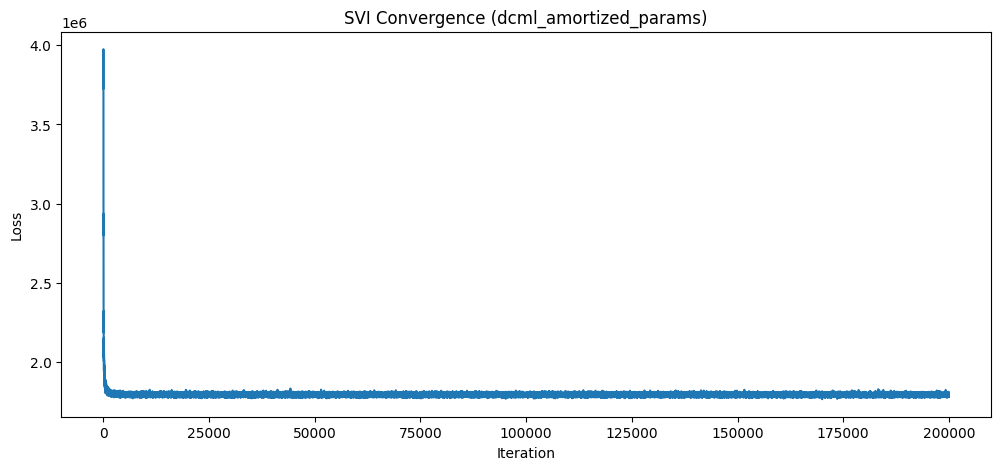

In [24]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=200000, lr=0.05, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

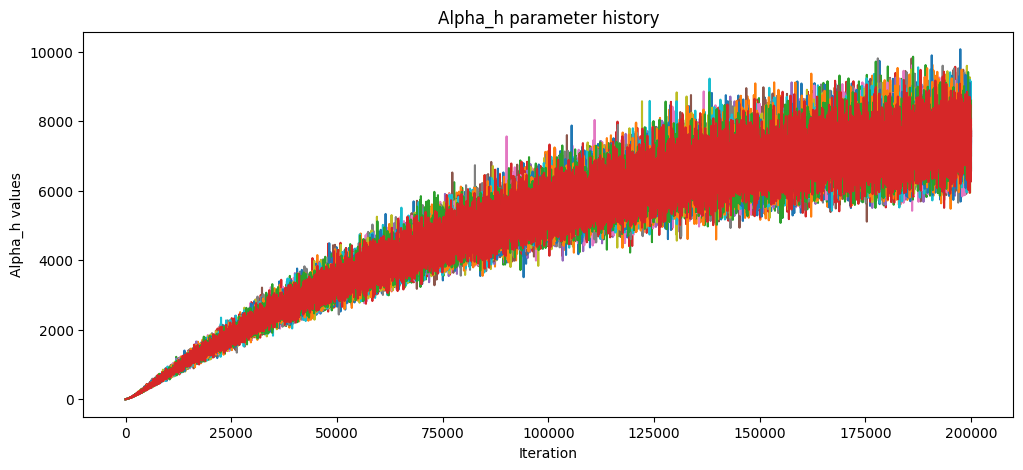

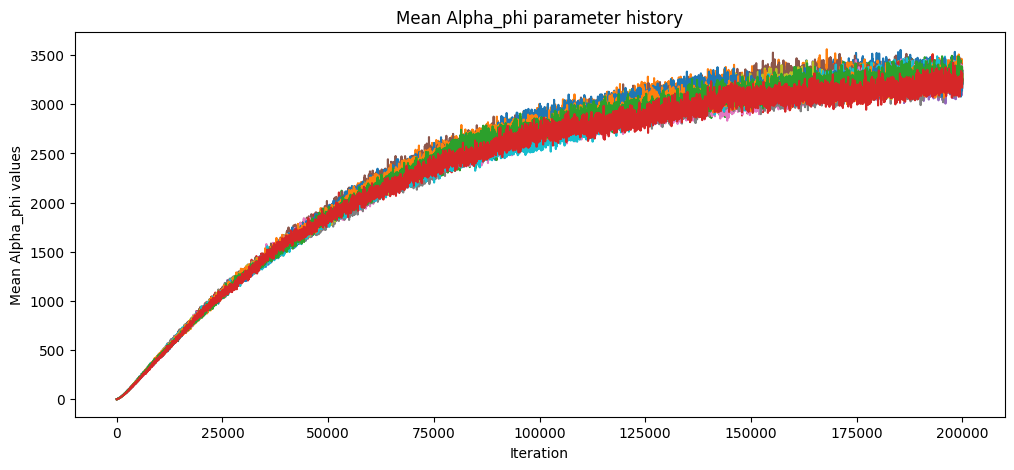

In [25]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

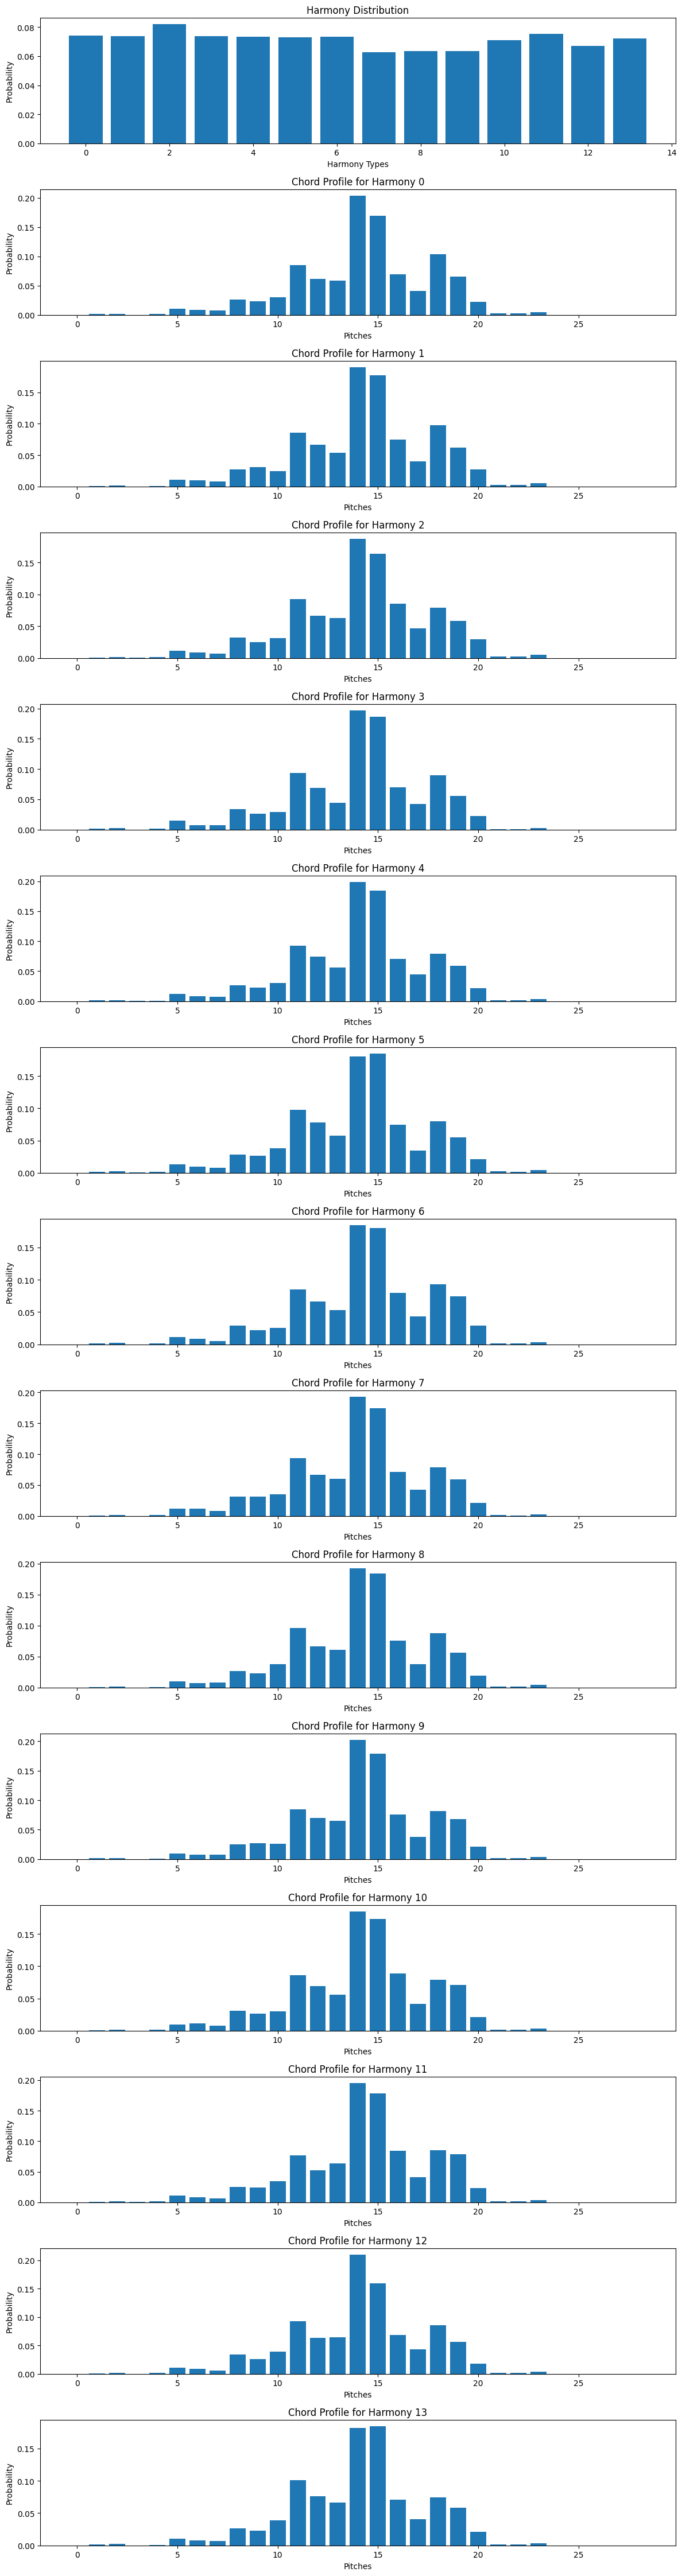

In [26]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")